In [1]:
from vit_pytorch import ViT
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from frequency_augmentations import rearrange_matrix, concentric_square_bandwidth_filter, phase_shift_fourier, mask_frequency_spectrum, mask_frequency_spectrum_patches

In [2]:

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [3]:
def fft_transform(data):
    processed_data = []
    for img, _ in data:
        img_np = img.numpy().squeeze()
        fft = np.fft.fft2(img_np)
        processed_data.append((img_np, fft))
    return processed_data

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)

def normalize_fft(fft_data):
    normalized_data = []
    for img_np, fft in fft_data:
        # Calculate magnitude and phase
        magnitude = np.abs(fft)
        phase = np.angle(fft)
        
        # Normalize magnitude to [0, 1] range
        magnitude_min = np.min(magnitude)
        magnitude_max = np.max(magnitude)
        normalized_magnitude = (magnitude - magnitude_min) / (magnitude_max - magnitude_min)
        
        # Rebuild complex number using normalized magnitude and original phase
        normalized_fft = normalized_magnitude * np.exp(1j * phase)
        
        normalized_data.append((img_np, normalized_fft))
    
    return normalized_data

# train_fft = normalize_fft(train_fft)
# test_fft = normalize_fft(test_fft)

1.0 0.0 (299.0078472062014+0j) (-105.1554452474781-85.19899857776973j)


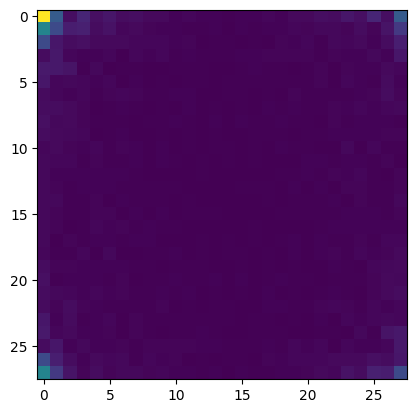

In [4]:
plt.imshow(np.abs(train_fft[0])[1])
print(train_fft[0][0].max(), train_fft[0][0].min(), train_fft[0][1].max(), train_fft[0][1].min())

In [38]:
class CustomTransform:
    def __init__(self, is_training=True):
        self.is_training = is_training
        
    def __call__(self, sample):
        img, fft = torch.tensor(np.array(sample))
        fft = torch.fft.fftshift(fft)
        if self.is_training: 
            fft = phase_shift_fourier(fft)
            
            # Choose a masking
            augmentation_method = random.choice([1, 2, 3])
    
            if augmentation_method == 1:
                fft = mask_frequency_spectrum(fft, 75)
            elif augmentation_method == 2:
                fft = concentric_square_bandwidth_filter(fft, min_size=0, max_size=None, band_width=None)
            else:
                fft = mask_frequency_spectrum_patches(fft, patch_size=7, max_mask_percentage=75)

        # Split the complex FFT into real and imaginary parts
        fft_real = torch.real(fft)
        fft_imag = torch.imag(fft)
        fft_stacked = torch.stack([fft_real, fft_imag])

        
        return fft_stacked.float()

In [39]:
class ComplexDataset(Dataset):
    def __init__(self, data, labels, is_training=True):
        self.data = data
        self.labels = labels
        self.transform = CustomTransform(is_training)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transform(sample)
        return sample, label

In [40]:
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels, is_training=True)

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels, is_training=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


In [54]:
item = next(iter(train_loader))

torch.Size([64, 2, 28, 28])


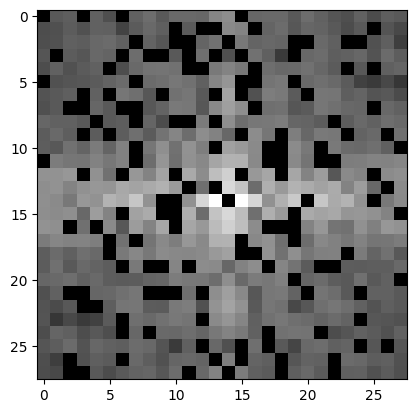

In [56]:
complex = torch.complex(item[0][0,0,:,:], item[0][0,1,:,:])
print(item[0].shape)
plt.imshow(torch.abs((complex))**(1/5), cmap="gray")

In [57]:
print(item[0][0][0][0].dtype)

torch.float32


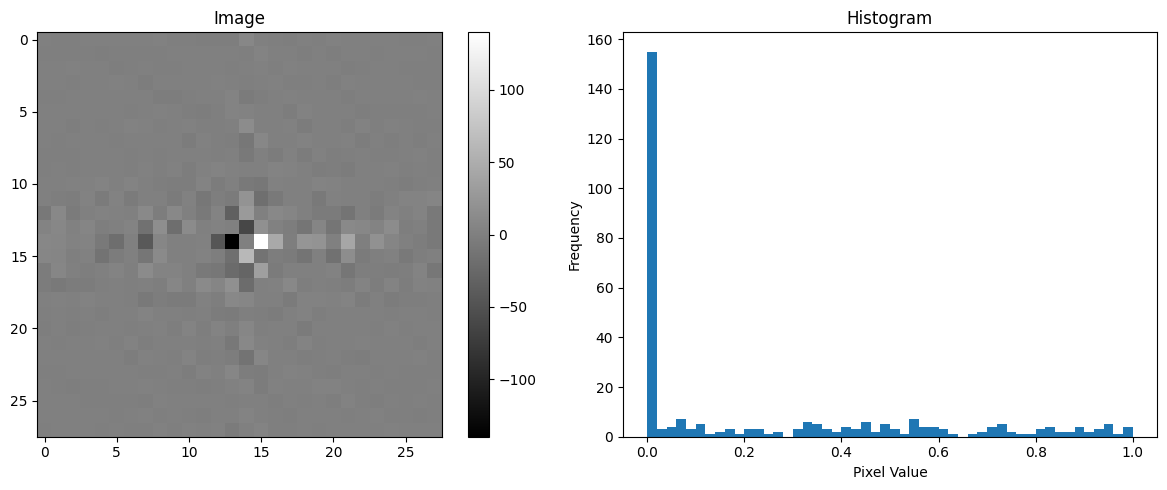

In [58]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the image
im = ax1.imshow(item[0][0,1,:,:], cmap="gray")
ax1.set_title("Image")
fig.colorbar(im, ax=ax1)

# Plot the histogram
ax2.hist(item[0][0,1,:,:].ravel(), bins=50, range=(0, 1))
ax2.set_title("Histogram")
ax2.set_xlabel("Pixel Value")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [59]:
model = ViT(
    image_size = 28,
    patch_size = 7,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 12,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 2
)

img = torch.randn(1, 2, 28, 28)

preds = model(img) # (1, 1000)

In [60]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 6337486


In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [62]:
writer = SummaryWriter('runs/experiment_1') 

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
        
        # Log batch-level metrics
        writer.add_scalar('Loss/Train Batch', loss.item(), epoch * len(train_loader) + batch_idx)
        writer.add_scalar('Accuracy/Train Batch', 100. * correct / total, epoch * len(train_loader) + batch_idx)
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Train Epoch', train_loss, epoch)
    writer.add_scalar('Accuracy/Train Epoch', train_accuracy, epoch)
    
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
    
    return test_loss, test_accuracy


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [65]:


model.to(device)
epochs = 2000
for epoch in range(689, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion, epoch)
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()


writer.close()

Epoch 689: 100%|██████████| 938/938 [00:17<00:00, 53.74batch/s, Train Loss=0.449, Train Acc=83]  


Epoch 689
Train Loss: 0.4494, Train Accuracy: 83.02%
Test Loss: 0.4303, Test Accuracy: 83.78%



Epoch 690: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.451, Train Acc=82.9]


Epoch 690
Train Loss: 0.4513, Train Accuracy: 82.92%
Test Loss: 0.4161, Test Accuracy: 83.95%



Epoch 691: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.449, Train Acc=83]  


Epoch 691
Train Loss: 0.4488, Train Accuracy: 83.04%
Test Loss: 0.4062, Test Accuracy: 84.16%



Epoch 692: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.446, Train Acc=83.3]


Epoch 692
Train Loss: 0.4460, Train Accuracy: 83.28%
Test Loss: 0.4040, Test Accuracy: 84.58%



Epoch 693: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.45, Train Acc=83]   


Epoch 693
Train Loss: 0.4496, Train Accuracy: 83.01%
Test Loss: 0.4113, Test Accuracy: 84.24%



Epoch 694: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.448, Train Acc=83]  


Epoch 694
Train Loss: 0.4481, Train Accuracy: 82.97%
Test Loss: 0.4112, Test Accuracy: 84.31%



Epoch 695: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.446, Train Acc=83.1]


Epoch 695
Train Loss: 0.4465, Train Accuracy: 83.14%
Test Loss: 0.4011, Test Accuracy: 84.75%



Epoch 696: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.44, Train Acc=83.4] 


Epoch 696
Train Loss: 0.4397, Train Accuracy: 83.36%
Test Loss: 0.4095, Test Accuracy: 84.20%



Epoch 697: 100%|██████████| 938/938 [00:16<00:00, 55.30batch/s, Train Loss=0.442, Train Acc=83.3]


Epoch 697
Train Loss: 0.4420, Train Accuracy: 83.28%
Test Loss: 0.4133, Test Accuracy: 84.31%



Epoch 698: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.44, Train Acc=83.3] 


Epoch 698
Train Loss: 0.4402, Train Accuracy: 83.30%
Test Loss: 0.4193, Test Accuracy: 84.37%



Epoch 699: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.439, Train Acc=83.4]


Epoch 699
Train Loss: 0.4387, Train Accuracy: 83.41%
Test Loss: 0.4224, Test Accuracy: 83.83%



Epoch 700: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.437, Train Acc=83.5]


Epoch 700
Train Loss: 0.4368, Train Accuracy: 83.48%
Test Loss: 0.4107, Test Accuracy: 84.86%



Epoch 701: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.44, Train Acc=83.3] 


Epoch 701
Train Loss: 0.4399, Train Accuracy: 83.32%
Test Loss: 0.4060, Test Accuracy: 84.79%



Epoch 702: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.438, Train Acc=83.3]


Epoch 702
Train Loss: 0.4385, Train Accuracy: 83.35%
Test Loss: 0.4019, Test Accuracy: 85.03%



Epoch 703: 100%|██████████| 938/938 [00:16<00:00, 55.28batch/s, Train Loss=0.434, Train Acc=83.5]


Epoch 703
Train Loss: 0.4337, Train Accuracy: 83.48%
Test Loss: 0.4174, Test Accuracy: 84.39%



Epoch 704: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.436, Train Acc=83.5]


Epoch 704
Train Loss: 0.4356, Train Accuracy: 83.50%
Test Loss: 0.4041, Test Accuracy: 84.58%



Epoch 705: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.432, Train Acc=83.7]


Epoch 705
Train Loss: 0.4322, Train Accuracy: 83.72%
Test Loss: 0.4011, Test Accuracy: 84.51%



Epoch 706: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.432, Train Acc=83.7]


Epoch 706
Train Loss: 0.4323, Train Accuracy: 83.70%
Test Loss: 0.4196, Test Accuracy: 83.88%



Epoch 707: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.433, Train Acc=83.5]


Epoch 707
Train Loss: 0.4334, Train Accuracy: 83.45%
Test Loss: 0.4032, Test Accuracy: 84.68%



Epoch 708: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.433, Train Acc=83.5]


Epoch 708
Train Loss: 0.4333, Train Accuracy: 83.50%
Test Loss: 0.4051, Test Accuracy: 84.56%



Epoch 709: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.433, Train Acc=83.6]


Epoch 709
Train Loss: 0.4328, Train Accuracy: 83.58%
Test Loss: 0.4094, Test Accuracy: 84.29%



Epoch 710: 100%|██████████| 938/938 [00:16<00:00, 55.36batch/s, Train Loss=0.429, Train Acc=83.9]


Epoch 710
Train Loss: 0.4288, Train Accuracy: 83.86%
Test Loss: 0.3929, Test Accuracy: 84.99%



Epoch 711: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.427, Train Acc=83.9]


Epoch 711
Train Loss: 0.4273, Train Accuracy: 83.86%
Test Loss: 0.4026, Test Accuracy: 84.58%



Epoch 712: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.429, Train Acc=83.8]


Epoch 712
Train Loss: 0.4290, Train Accuracy: 83.81%
Test Loss: 0.3980, Test Accuracy: 84.53%



Epoch 713: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.428, Train Acc=83.9]


Epoch 713
Train Loss: 0.4276, Train Accuracy: 83.86%
Test Loss: 0.4124, Test Accuracy: 84.21%



Epoch 714: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.424, Train Acc=83.8]


Epoch 714
Train Loss: 0.4243, Train Accuracy: 83.84%
Test Loss: 0.4041, Test Accuracy: 84.81%



Epoch 715: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.425, Train Acc=83.9]


Epoch 715
Train Loss: 0.4249, Train Accuracy: 83.94%
Test Loss: 0.3984, Test Accuracy: 84.87%



Epoch 716: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.424, Train Acc=83.9]


Epoch 716
Train Loss: 0.4238, Train Accuracy: 83.88%
Test Loss: 0.4029, Test Accuracy: 84.68%



Epoch 717: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.421, Train Acc=84.2]


Epoch 717
Train Loss: 0.4206, Train Accuracy: 84.17%
Test Loss: 0.4093, Test Accuracy: 84.60%



Epoch 718: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.42, Train Acc=84]   


Epoch 718
Train Loss: 0.4205, Train Accuracy: 84.00%
Test Loss: 0.3996, Test Accuracy: 84.85%



Epoch 719: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.423, Train Acc=84]  


Epoch 719
Train Loss: 0.4229, Train Accuracy: 83.99%
Test Loss: 0.4023, Test Accuracy: 84.48%



Epoch 720: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.42, Train Acc=84.1] 


Epoch 720
Train Loss: 0.4203, Train Accuracy: 84.06%
Test Loss: 0.3959, Test Accuracy: 85.13%



Epoch 721: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.426, Train Acc=83.9]


Epoch 721
Train Loss: 0.4256, Train Accuracy: 83.86%
Test Loss: 0.4050, Test Accuracy: 84.58%



Epoch 722: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.418, Train Acc=84.3]


Epoch 722
Train Loss: 0.4183, Train Accuracy: 84.25%
Test Loss: 0.4035, Test Accuracy: 84.84%



Epoch 723: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.42, Train Acc=84.1] 


Epoch 723
Train Loss: 0.4200, Train Accuracy: 84.12%
Test Loss: 0.3838, Test Accuracy: 85.28%



Epoch 724: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.414, Train Acc=84.5]


Epoch 724
Train Loss: 0.4138, Train Accuracy: 84.47%
Test Loss: 0.4001, Test Accuracy: 84.52%



Epoch 725: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.416, Train Acc=84.3]


Epoch 725
Train Loss: 0.4155, Train Accuracy: 84.30%
Test Loss: 0.3963, Test Accuracy: 85.08%



Epoch 726: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.42, Train Acc=84]   


Epoch 726
Train Loss: 0.4198, Train Accuracy: 84.00%
Test Loss: 0.3971, Test Accuracy: 85.13%



Epoch 727: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.412, Train Acc=84.3]


Epoch 727
Train Loss: 0.4115, Train Accuracy: 84.30%
Test Loss: 0.3848, Test Accuracy: 85.37%



Epoch 728: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.409, Train Acc=84.6]


Epoch 728
Train Loss: 0.4089, Train Accuracy: 84.55%
Test Loss: 0.3988, Test Accuracy: 85.35%



Epoch 729: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.413, Train Acc=84.5]


Epoch 729
Train Loss: 0.4129, Train Accuracy: 84.46%
Test Loss: 0.3829, Test Accuracy: 85.50%



Epoch 730: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.41, Train Acc=84.4] 


Epoch 730
Train Loss: 0.4102, Train Accuracy: 84.39%
Test Loss: 0.4005, Test Accuracy: 85.09%



Epoch 731: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.411, Train Acc=84.5]


Epoch 731
Train Loss: 0.4106, Train Accuracy: 84.55%
Test Loss: 0.3818, Test Accuracy: 85.55%



Epoch 732: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.408, Train Acc=84.4]


Epoch 732
Train Loss: 0.4079, Train Accuracy: 84.38%
Test Loss: 0.3859, Test Accuracy: 85.39%



Epoch 733: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.411, Train Acc=84.5]


Epoch 733
Train Loss: 0.4108, Train Accuracy: 84.52%
Test Loss: 0.3859, Test Accuracy: 85.26%



Epoch 734: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.412, Train Acc=84.2]


Epoch 734
Train Loss: 0.4124, Train Accuracy: 84.24%
Test Loss: 0.3881, Test Accuracy: 85.07%



Epoch 735: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.406, Train Acc=84.7]


Epoch 735
Train Loss: 0.4058, Train Accuracy: 84.69%
Test Loss: 0.3823, Test Accuracy: 85.24%



Epoch 736: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.41, Train Acc=84.5] 


Epoch 736
Train Loss: 0.4103, Train Accuracy: 84.54%
Test Loss: 0.3884, Test Accuracy: 85.32%



Epoch 737: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.409, Train Acc=84.4]


Epoch 737
Train Loss: 0.4089, Train Accuracy: 84.38%
Test Loss: 0.3811, Test Accuracy: 85.37%



Epoch 738: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.407, Train Acc=84.6]


Epoch 738
Train Loss: 0.4065, Train Accuracy: 84.58%
Test Loss: 0.3799, Test Accuracy: 85.65%



Epoch 739: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.399, Train Acc=84.9]


Epoch 739
Train Loss: 0.3989, Train Accuracy: 84.90%
Test Loss: 0.3915, Test Accuracy: 85.15%



Epoch 740: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.407, Train Acc=84.5]


Epoch 740
Train Loss: 0.4066, Train Accuracy: 84.53%
Test Loss: 0.3765, Test Accuracy: 85.78%



Epoch 741: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.4, Train Acc=84.8]  


Epoch 741
Train Loss: 0.3998, Train Accuracy: 84.83%
Test Loss: 0.3960, Test Accuracy: 84.55%



Epoch 742: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.405, Train Acc=84.8]


Epoch 742
Train Loss: 0.4047, Train Accuracy: 84.84%
Test Loss: 0.4071, Test Accuracy: 84.75%



Epoch 743: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.405, Train Acc=84.7]


Epoch 743
Train Loss: 0.4052, Train Accuracy: 84.65%
Test Loss: 0.4080, Test Accuracy: 84.41%



Epoch 744: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.402, Train Acc=84.7]


Epoch 744
Train Loss: 0.4022, Train Accuracy: 84.74%
Test Loss: 0.3854, Test Accuracy: 85.38%



Epoch 745: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.399, Train Acc=84.8]


Epoch 745
Train Loss: 0.3994, Train Accuracy: 84.77%
Test Loss: 0.3764, Test Accuracy: 85.57%



Epoch 746: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.4, Train Acc=84.8]  


Epoch 746
Train Loss: 0.3999, Train Accuracy: 84.85%
Test Loss: 0.3753, Test Accuracy: 85.75%



Epoch 747: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.399, Train Acc=84.9]


Epoch 747
Train Loss: 0.3987, Train Accuracy: 84.92%
Test Loss: 0.3774, Test Accuracy: 85.72%



Epoch 748: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.397, Train Acc=84.9]


Epoch 748
Train Loss: 0.3972, Train Accuracy: 84.88%
Test Loss: 0.3814, Test Accuracy: 85.65%



Epoch 749: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.4, Train Acc=84.8]  


Epoch 749
Train Loss: 0.4001, Train Accuracy: 84.84%
Test Loss: 0.3818, Test Accuracy: 85.32%



Epoch 750: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.398, Train Acc=84.9]


Epoch 750
Train Loss: 0.3976, Train Accuracy: 84.92%
Test Loss: 0.3763, Test Accuracy: 86.02%



Epoch 751: 100%|██████████| 938/938 [00:17<00:00, 54.77batch/s, Train Loss=0.397, Train Acc=85]  


Epoch 751
Train Loss: 0.3966, Train Accuracy: 85.03%
Test Loss: 0.3848, Test Accuracy: 85.44%



Epoch 752: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.397, Train Acc=85]  


Epoch 752
Train Loss: 0.3975, Train Accuracy: 84.95%
Test Loss: 0.3964, Test Accuracy: 85.14%



Epoch 753: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.397, Train Acc=85]  


Epoch 753
Train Loss: 0.3967, Train Accuracy: 84.97%
Test Loss: 0.3739, Test Accuracy: 85.52%



Epoch 754: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.396, Train Acc=85]  


Epoch 754
Train Loss: 0.3959, Train Accuracy: 84.99%
Test Loss: 0.3824, Test Accuracy: 85.93%



Epoch 755: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.394, Train Acc=85.1]


Epoch 755
Train Loss: 0.3942, Train Accuracy: 85.12%
Test Loss: 0.3710, Test Accuracy: 85.68%



Epoch 756: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.391, Train Acc=85.2]


Epoch 756
Train Loss: 0.3906, Train Accuracy: 85.18%
Test Loss: 0.3817, Test Accuracy: 85.67%



Epoch 757: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.392, Train Acc=85.1]


Epoch 757
Train Loss: 0.3923, Train Accuracy: 85.11%
Test Loss: 0.3888, Test Accuracy: 85.39%



Epoch 758: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.391, Train Acc=85.2]


Epoch 758
Train Loss: 0.3910, Train Accuracy: 85.18%
Test Loss: 0.3802, Test Accuracy: 85.53%



Epoch 759: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.388, Train Acc=85.2]


Epoch 759
Train Loss: 0.3875, Train Accuracy: 85.19%
Test Loss: 0.3735, Test Accuracy: 85.62%



Epoch 760: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.394, Train Acc=85]  


Epoch 760
Train Loss: 0.3943, Train Accuracy: 84.98%
Test Loss: 0.3950, Test Accuracy: 85.01%



Epoch 761: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.389, Train Acc=85.3]


Epoch 761
Train Loss: 0.3891, Train Accuracy: 85.28%
Test Loss: 0.3689, Test Accuracy: 86.03%



Epoch 762: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.388, Train Acc=85.3]


Epoch 762
Train Loss: 0.3880, Train Accuracy: 85.28%
Test Loss: 0.3673, Test Accuracy: 85.80%



Epoch 763: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.389, Train Acc=85.3]


Epoch 763
Train Loss: 0.3887, Train Accuracy: 85.30%
Test Loss: 0.3719, Test Accuracy: 86.02%



Epoch 764: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.39, Train Acc=85.5] 


Epoch 764
Train Loss: 0.3895, Train Accuracy: 85.48%
Test Loss: 0.3760, Test Accuracy: 85.65%



Epoch 765: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.386, Train Acc=85.2]


Epoch 765
Train Loss: 0.3857, Train Accuracy: 85.19%
Test Loss: 0.3767, Test Accuracy: 85.65%



Epoch 766: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.389, Train Acc=85.2]


Epoch 766
Train Loss: 0.3892, Train Accuracy: 85.23%
Test Loss: 0.3737, Test Accuracy: 85.80%



Epoch 767: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.382, Train Acc=85.6]


Epoch 767
Train Loss: 0.3817, Train Accuracy: 85.57%
Test Loss: 0.3867, Test Accuracy: 85.59%



Epoch 768: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.388, Train Acc=85.1]


Epoch 768
Train Loss: 0.3879, Train Accuracy: 85.09%
Test Loss: 0.4014, Test Accuracy: 84.82%



Epoch 769: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.384, Train Acc=85.4]


Epoch 769
Train Loss: 0.3839, Train Accuracy: 85.42%
Test Loss: 0.3814, Test Accuracy: 85.40%



Epoch 770: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.385, Train Acc=85.5]


Epoch 770
Train Loss: 0.3849, Train Accuracy: 85.51%
Test Loss: 0.3746, Test Accuracy: 85.75%



Epoch 771: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.383, Train Acc=85.5]


Epoch 771
Train Loss: 0.3835, Train Accuracy: 85.48%
Test Loss: 0.3738, Test Accuracy: 85.73%



Epoch 772: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.381, Train Acc=85.3]


Epoch 772
Train Loss: 0.3810, Train Accuracy: 85.33%
Test Loss: 0.3652, Test Accuracy: 85.99%



Epoch 773: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.382, Train Acc=85.3]


Epoch 773
Train Loss: 0.3820, Train Accuracy: 85.28%
Test Loss: 0.3709, Test Accuracy: 85.61%



Epoch 774: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.382, Train Acc=85.5]


Epoch 774
Train Loss: 0.3821, Train Accuracy: 85.50%
Test Loss: 0.3698, Test Accuracy: 85.40%



Epoch 775: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.381, Train Acc=85.6]


Epoch 775
Train Loss: 0.3807, Train Accuracy: 85.56%
Test Loss: 0.3672, Test Accuracy: 85.95%



Epoch 776: 100%|██████████| 938/938 [00:17<00:00, 54.85batch/s, Train Loss=0.383, Train Acc=85.4]


Epoch 776
Train Loss: 0.3833, Train Accuracy: 85.41%
Test Loss: 0.3843, Test Accuracy: 85.56%



Epoch 777: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.38, Train Acc=85.6] 


Epoch 777
Train Loss: 0.3800, Train Accuracy: 85.62%
Test Loss: 0.3578, Test Accuracy: 86.54%



Epoch 778: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.379, Train Acc=85.7]


Epoch 778
Train Loss: 0.3789, Train Accuracy: 85.65%
Test Loss: 0.3659, Test Accuracy: 86.24%



Epoch 779: 100%|██████████| 938/938 [00:17<00:00, 54.96batch/s, Train Loss=0.381, Train Acc=85.4]


Epoch 779
Train Loss: 0.3809, Train Accuracy: 85.41%
Test Loss: 0.3636, Test Accuracy: 86.38%



Epoch 780: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.377, Train Acc=85.7]


Epoch 780
Train Loss: 0.3768, Train Accuracy: 85.72%
Test Loss: 0.3666, Test Accuracy: 86.05%



Epoch 781: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.378, Train Acc=85.6]


Epoch 781
Train Loss: 0.3782, Train Accuracy: 85.58%
Test Loss: 0.3711, Test Accuracy: 85.85%



Epoch 782: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.38, Train Acc=85.6] 


Epoch 782
Train Loss: 0.3799, Train Accuracy: 85.59%
Test Loss: 0.3649, Test Accuracy: 86.07%



Epoch 783: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.375, Train Acc=85.8]


Epoch 783
Train Loss: 0.3747, Train Accuracy: 85.79%
Test Loss: 0.3729, Test Accuracy: 85.86%



Epoch 784: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.376, Train Acc=85.7]


Epoch 784
Train Loss: 0.3759, Train Accuracy: 85.72%
Test Loss: 0.3762, Test Accuracy: 85.78%



Epoch 785: 100%|██████████| 938/938 [00:17<00:00, 54.89batch/s, Train Loss=0.374, Train Acc=85.9]


Epoch 785
Train Loss: 0.3743, Train Accuracy: 85.89%
Test Loss: 0.3701, Test Accuracy: 85.97%



Epoch 786: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.375, Train Acc=85.7]


Epoch 786
Train Loss: 0.3746, Train Accuracy: 85.73%
Test Loss: 0.3767, Test Accuracy: 85.70%



Epoch 787: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.372, Train Acc=85.8]


Epoch 787
Train Loss: 0.3724, Train Accuracy: 85.83%
Test Loss: 0.3653, Test Accuracy: 86.18%



Epoch 788: 100%|██████████| 938/938 [00:17<00:00, 54.93batch/s, Train Loss=0.374, Train Acc=85.9]


Epoch 788
Train Loss: 0.3739, Train Accuracy: 85.87%
Test Loss: 0.3712, Test Accuracy: 85.66%



Epoch 789: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.373, Train Acc=85.7]


Epoch 789
Train Loss: 0.3734, Train Accuracy: 85.68%
Test Loss: 0.3608, Test Accuracy: 86.01%



Epoch 790: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.371, Train Acc=85.9]


Epoch 790
Train Loss: 0.3708, Train Accuracy: 85.88%
Test Loss: 0.3535, Test Accuracy: 86.48%



Epoch 791: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.374, Train Acc=85.8]


Epoch 791
Train Loss: 0.3735, Train Accuracy: 85.78%
Test Loss: 0.3792, Test Accuracy: 85.03%



Epoch 792: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.371, Train Acc=85.8]


Epoch 792
Train Loss: 0.3712, Train Accuracy: 85.79%
Test Loss: 0.3726, Test Accuracy: 85.77%



Epoch 793: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.373, Train Acc=85.9]


Epoch 793
Train Loss: 0.3733, Train Accuracy: 85.89%
Test Loss: 0.3569, Test Accuracy: 86.40%



Epoch 794: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.374, Train Acc=85.7]


Epoch 794
Train Loss: 0.3744, Train Accuracy: 85.71%
Test Loss: 0.3705, Test Accuracy: 85.98%



Epoch 795: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.372, Train Acc=85.7]


Epoch 795
Train Loss: 0.3718, Train Accuracy: 85.70%
Test Loss: 0.3724, Test Accuracy: 85.65%



Epoch 796: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.369, Train Acc=86]  


Epoch 796
Train Loss: 0.3688, Train Accuracy: 85.98%
Test Loss: 0.3523, Test Accuracy: 86.32%



Epoch 797: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.371, Train Acc=85.9]


Epoch 797
Train Loss: 0.3712, Train Accuracy: 85.87%
Test Loss: 0.3478, Test Accuracy: 86.57%



Epoch 798: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.368, Train Acc=86.1]


Epoch 798
Train Loss: 0.3683, Train Accuracy: 86.06%
Test Loss: 0.3630, Test Accuracy: 86.17%



Epoch 799: 100%|██████████| 938/938 [00:17<00:00, 54.89batch/s, Train Loss=0.37, Train Acc=85.8] 


Epoch 799
Train Loss: 0.3699, Train Accuracy: 85.84%
Test Loss: 0.3745, Test Accuracy: 85.86%



Epoch 800: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.369, Train Acc=86]  


Epoch 800
Train Loss: 0.3694, Train Accuracy: 85.96%
Test Loss: 0.3652, Test Accuracy: 86.11%



Epoch 801: 100%|██████████| 938/938 [00:17<00:00, 54.96batch/s, Train Loss=0.363, Train Acc=86.1]


Epoch 801
Train Loss: 0.3630, Train Accuracy: 86.08%
Test Loss: 0.3570, Test Accuracy: 86.31%



Epoch 802: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.368, Train Acc=86]  


Epoch 802
Train Loss: 0.3685, Train Accuracy: 86.05%
Test Loss: 0.3527, Test Accuracy: 86.55%



Epoch 803: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.37, Train Acc=85.9] 


Epoch 803
Train Loss: 0.3704, Train Accuracy: 85.94%
Test Loss: 0.3657, Test Accuracy: 86.23%



Epoch 804: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.365, Train Acc=86.1]


Epoch 804
Train Loss: 0.3652, Train Accuracy: 86.07%
Test Loss: 0.3675, Test Accuracy: 85.77%



Epoch 805: 100%|██████████| 938/938 [00:17<00:00, 54.93batch/s, Train Loss=0.365, Train Acc=86.1]


Epoch 805
Train Loss: 0.3652, Train Accuracy: 86.12%
Test Loss: 0.3572, Test Accuracy: 86.49%



Epoch 806: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.363, Train Acc=86.1]


Epoch 806
Train Loss: 0.3634, Train Accuracy: 86.10%
Test Loss: 0.3715, Test Accuracy: 85.61%



Epoch 807: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.363, Train Acc=86.3]


Epoch 807
Train Loss: 0.3635, Train Accuracy: 86.30%
Test Loss: 0.3722, Test Accuracy: 85.66%



Epoch 808: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.364, Train Acc=86.2]


Epoch 808
Train Loss: 0.3642, Train Accuracy: 86.17%
Test Loss: 0.3508, Test Accuracy: 86.99%



Epoch 809: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.364, Train Acc=86.1]


Epoch 809
Train Loss: 0.3640, Train Accuracy: 86.11%
Test Loss: 0.3468, Test Accuracy: 87.00%



Epoch 810: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.363, Train Acc=86.2]


Epoch 810
Train Loss: 0.3626, Train Accuracy: 86.16%
Test Loss: 0.3521, Test Accuracy: 86.75%



Epoch 811: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.363, Train Acc=86.1]


Epoch 811
Train Loss: 0.3629, Train Accuracy: 86.13%
Test Loss: 0.3476, Test Accuracy: 86.91%



Epoch 812: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.364, Train Acc=86.2]


Epoch 812
Train Loss: 0.3645, Train Accuracy: 86.15%
Test Loss: 0.3606, Test Accuracy: 86.73%



Epoch 813: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.361, Train Acc=86.1]


Epoch 813
Train Loss: 0.3613, Train Accuracy: 86.11%
Test Loss: 0.3518, Test Accuracy: 86.83%



Epoch 814: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.357, Train Acc=86.4]


Epoch 814
Train Loss: 0.3566, Train Accuracy: 86.41%
Test Loss: 0.3543, Test Accuracy: 86.84%



Epoch 815: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.364, Train Acc=86.1]


Epoch 815
Train Loss: 0.3641, Train Accuracy: 86.11%
Test Loss: 0.3408, Test Accuracy: 86.96%



Epoch 816: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.36, Train Acc=86.3] 


Epoch 816
Train Loss: 0.3603, Train Accuracy: 86.33%
Test Loss: 0.3521, Test Accuracy: 86.54%



Epoch 817: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.361, Train Acc=86.3]


Epoch 817
Train Loss: 0.3606, Train Accuracy: 86.28%
Test Loss: 0.3580, Test Accuracy: 86.19%



Epoch 818: 100%|██████████| 938/938 [00:17<00:00, 54.92batch/s, Train Loss=0.363, Train Acc=86.3]


Epoch 818
Train Loss: 0.3625, Train Accuracy: 86.31%
Test Loss: 0.3579, Test Accuracy: 86.29%



Epoch 819: 100%|██████████| 938/938 [00:17<00:00, 54.82batch/s, Train Loss=0.359, Train Acc=86.3]


Epoch 819
Train Loss: 0.3594, Train Accuracy: 86.35%
Test Loss: 0.3575, Test Accuracy: 86.32%



Epoch 820: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.355, Train Acc=86.4]


Epoch 820
Train Loss: 0.3549, Train Accuracy: 86.43%
Test Loss: 0.3429, Test Accuracy: 87.01%



Epoch 821: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.359, Train Acc=86.4]


Epoch 821
Train Loss: 0.3594, Train Accuracy: 86.45%
Test Loss: 0.3498, Test Accuracy: 86.76%



Epoch 822: 100%|██████████| 938/938 [00:17<00:00, 54.87batch/s, Train Loss=0.355, Train Acc=86.6]


Epoch 822
Train Loss: 0.3548, Train Accuracy: 86.57%
Test Loss: 0.3465, Test Accuracy: 86.77%



Epoch 823: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.354, Train Acc=86.6]


Epoch 823
Train Loss: 0.3543, Train Accuracy: 86.56%
Test Loss: 0.3534, Test Accuracy: 86.59%



Epoch 824: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.354, Train Acc=86.4]


Epoch 824
Train Loss: 0.3542, Train Accuracy: 86.36%
Test Loss: 0.3450, Test Accuracy: 86.97%



Epoch 825: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.355, Train Acc=86.5]


Epoch 825
Train Loss: 0.3546, Train Accuracy: 86.46%
Test Loss: 0.3767, Test Accuracy: 85.91%



Epoch 826: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.357, Train Acc=86.4]


Epoch 826
Train Loss: 0.3572, Train Accuracy: 86.41%
Test Loss: 0.3478, Test Accuracy: 87.03%



Epoch 827: 100%|██████████| 938/938 [00:17<00:00, 54.96batch/s, Train Loss=0.352, Train Acc=86.5]


Epoch 827
Train Loss: 0.3523, Train Accuracy: 86.53%
Test Loss: 0.3387, Test Accuracy: 87.11%



Epoch 828: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.354, Train Acc=86.5]


Epoch 828
Train Loss: 0.3536, Train Accuracy: 86.53%
Test Loss: 0.3577, Test Accuracy: 86.36%



Epoch 829: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.352, Train Acc=86.5]


Epoch 829
Train Loss: 0.3517, Train Accuracy: 86.54%
Test Loss: 0.3638, Test Accuracy: 86.12%



Epoch 830: 100%|██████████| 938/938 [00:17<00:00, 54.84batch/s, Train Loss=0.35, Train Acc=86.6] 


Epoch 830
Train Loss: 0.3501, Train Accuracy: 86.58%
Test Loss: 0.3494, Test Accuracy: 87.36%



Epoch 831: 100%|██████████| 938/938 [00:17<00:00, 54.90batch/s, Train Loss=0.352, Train Acc=86.6]


Epoch 831
Train Loss: 0.3519, Train Accuracy: 86.59%
Test Loss: 0.3594, Test Accuracy: 86.71%



Epoch 832: 100%|██████████| 938/938 [00:17<00:00, 54.90batch/s, Train Loss=0.35, Train Acc=86.7] 


Epoch 832
Train Loss: 0.3498, Train Accuracy: 86.68%
Test Loss: 0.3495, Test Accuracy: 86.63%



Epoch 833: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.349, Train Acc=86.6]


Epoch 833
Train Loss: 0.3494, Train Accuracy: 86.61%
Test Loss: 0.3559, Test Accuracy: 86.46%



Epoch 834: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.354, Train Acc=86.6]


Epoch 834
Train Loss: 0.3540, Train Accuracy: 86.58%
Test Loss: 0.3454, Test Accuracy: 86.82%



Epoch 835: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.349, Train Acc=86.7]


Epoch 835
Train Loss: 0.3492, Train Accuracy: 86.71%
Test Loss: 0.3357, Test Accuracy: 87.32%



Epoch 836: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.353, Train Acc=86.6]


Epoch 836
Train Loss: 0.3526, Train Accuracy: 86.56%
Test Loss: 0.3443, Test Accuracy: 87.10%



Epoch 837: 100%|██████████| 938/938 [00:17<00:00, 54.89batch/s, Train Loss=0.348, Train Acc=86.8]


Epoch 837
Train Loss: 0.3477, Train Accuracy: 86.77%
Test Loss: 0.3554, Test Accuracy: 86.50%



Epoch 838: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.349, Train Acc=86.7]


Epoch 838
Train Loss: 0.3485, Train Accuracy: 86.66%
Test Loss: 0.3559, Test Accuracy: 86.50%



Epoch 839: 100%|██████████| 938/938 [00:17<00:00, 54.92batch/s, Train Loss=0.348, Train Acc=86.7]


Epoch 839
Train Loss: 0.3485, Train Accuracy: 86.72%
Test Loss: 0.3408, Test Accuracy: 87.10%



Epoch 840: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.346, Train Acc=87]  


Epoch 840
Train Loss: 0.3462, Train Accuracy: 86.99%
Test Loss: 0.3529, Test Accuracy: 86.60%



Epoch 841: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.351, Train Acc=86.7]


Epoch 841
Train Loss: 0.3506, Train Accuracy: 86.66%
Test Loss: 0.3331, Test Accuracy: 87.24%



Epoch 842: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.346, Train Acc=86.8]


Epoch 842
Train Loss: 0.3464, Train Accuracy: 86.82%
Test Loss: 0.3517, Test Accuracy: 86.48%



Epoch 843: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.348, Train Acc=86.8]


Epoch 843
Train Loss: 0.3481, Train Accuracy: 86.78%
Test Loss: 0.3481, Test Accuracy: 86.47%



Epoch 844: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.345, Train Acc=86.9]


Epoch 844
Train Loss: 0.3447, Train Accuracy: 86.90%
Test Loss: 0.3340, Test Accuracy: 87.22%



Epoch 845: 100%|██████████| 938/938 [00:17<00:00, 54.90batch/s, Train Loss=0.345, Train Acc=86.8]


Epoch 845
Train Loss: 0.3452, Train Accuracy: 86.77%
Test Loss: 0.3542, Test Accuracy: 86.65%



Epoch 846: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.348, Train Acc=86.7]


Epoch 846
Train Loss: 0.3479, Train Accuracy: 86.67%
Test Loss: 0.3423, Test Accuracy: 87.26%



Epoch 847: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.347, Train Acc=86.6]


Epoch 847
Train Loss: 0.3470, Train Accuracy: 86.64%
Test Loss: 0.3599, Test Accuracy: 86.26%



Epoch 848: 100%|██████████| 938/938 [00:17<00:00, 54.96batch/s, Train Loss=0.344, Train Acc=86.9]


Epoch 848
Train Loss: 0.3438, Train Accuracy: 86.87%
Test Loss: 0.3625, Test Accuracy: 86.04%



Epoch 849: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.345, Train Acc=86.9]


Epoch 849
Train Loss: 0.3454, Train Accuracy: 86.91%
Test Loss: 0.3449, Test Accuracy: 86.97%



Epoch 850: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.344, Train Acc=86.8]


Epoch 850
Train Loss: 0.3442, Train Accuracy: 86.83%
Test Loss: 0.3385, Test Accuracy: 87.19%



Epoch 851: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.341, Train Acc=87]  


Epoch 851
Train Loss: 0.3411, Train Accuracy: 87.04%
Test Loss: 0.3388, Test Accuracy: 87.23%



Epoch 852: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.342, Train Acc=87]  


Epoch 852
Train Loss: 0.3418, Train Accuracy: 86.99%
Test Loss: 0.3383, Test Accuracy: 87.37%



Epoch 853: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.344, Train Acc=86.9]


Epoch 853
Train Loss: 0.3445, Train Accuracy: 86.89%
Test Loss: 0.3336, Test Accuracy: 87.11%



Epoch 854: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.343, Train Acc=87]  


Epoch 854
Train Loss: 0.3426, Train Accuracy: 87.00%
Test Loss: 0.3411, Test Accuracy: 87.08%



Epoch 855: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.342, Train Acc=86.9]


Epoch 855
Train Loss: 0.3424, Train Accuracy: 86.91%
Test Loss: 0.3335, Test Accuracy: 87.56%



Epoch 856: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.344, Train Acc=86.9]


Epoch 856
Train Loss: 0.3443, Train Accuracy: 86.89%
Test Loss: 0.3372, Test Accuracy: 87.26%



Epoch 857: 100%|██████████| 938/938 [00:17<00:00, 54.93batch/s, Train Loss=0.344, Train Acc=86.9]


Epoch 857
Train Loss: 0.3440, Train Accuracy: 86.88%
Test Loss: 0.3408, Test Accuracy: 87.35%



Epoch 858: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.34, Train Acc=87.1] 


Epoch 858
Train Loss: 0.3405, Train Accuracy: 87.12%
Test Loss: 0.3374, Test Accuracy: 87.55%



Epoch 859: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.341, Train Acc=87.1]


Epoch 859
Train Loss: 0.3408, Train Accuracy: 87.05%
Test Loss: 0.3337, Test Accuracy: 87.35%



Epoch 860: 100%|██████████| 938/938 [00:17<00:00, 54.86batch/s, Train Loss=0.34, Train Acc=87.2] 


Epoch 860
Train Loss: 0.3395, Train Accuracy: 87.22%
Test Loss: 0.3644, Test Accuracy: 86.42%



Epoch 861: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.338, Train Acc=87.1]


Epoch 861
Train Loss: 0.3377, Train Accuracy: 87.13%
Test Loss: 0.3391, Test Accuracy: 87.14%



Epoch 862: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.339, Train Acc=87]  


Epoch 862
Train Loss: 0.3390, Train Accuracy: 87.00%
Test Loss: 0.3535, Test Accuracy: 86.75%



Epoch 863: 100%|██████████| 938/938 [00:17<00:00, 54.93batch/s, Train Loss=0.34, Train Acc=87.1] 


Epoch 863
Train Loss: 0.3397, Train Accuracy: 87.06%
Test Loss: 0.3398, Test Accuracy: 87.33%



Epoch 864: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.338, Train Acc=87.1]


Epoch 864
Train Loss: 0.3382, Train Accuracy: 87.15%
Test Loss: 0.3384, Test Accuracy: 87.04%



Epoch 865: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.34, Train Acc=87]   


Epoch 865
Train Loss: 0.3399, Train Accuracy: 87.03%
Test Loss: 0.3321, Test Accuracy: 87.48%



Epoch 866: 100%|██████████| 938/938 [00:17<00:00, 54.92batch/s, Train Loss=0.338, Train Acc=87.1]


Epoch 866
Train Loss: 0.3382, Train Accuracy: 87.14%
Test Loss: 0.3299, Test Accuracy: 87.38%



Epoch 867: 100%|██████████| 938/938 [00:17<00:00, 54.76batch/s, Train Loss=0.336, Train Acc=87.1]


Epoch 867
Train Loss: 0.3356, Train Accuracy: 87.09%
Test Loss: 0.3389, Test Accuracy: 87.05%



Epoch 868: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.336, Train Acc=87.1]


Epoch 868
Train Loss: 0.3364, Train Accuracy: 87.09%
Test Loss: 0.3225, Test Accuracy: 87.72%



Epoch 869: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.336, Train Acc=87.2]


Epoch 869
Train Loss: 0.3360, Train Accuracy: 87.19%
Test Loss: 0.3296, Test Accuracy: 87.55%



Epoch 870: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.333, Train Acc=87.3]


Epoch 870
Train Loss: 0.3334, Train Accuracy: 87.28%
Test Loss: 0.3356, Test Accuracy: 87.46%



Epoch 871: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.335, Train Acc=87.2]


Epoch 871
Train Loss: 0.3353, Train Accuracy: 87.17%
Test Loss: 0.3247, Test Accuracy: 87.77%



Epoch 872: 100%|██████████| 938/938 [00:17<00:00, 54.92batch/s, Train Loss=0.331, Train Acc=87.4]


Epoch 872
Train Loss: 0.3312, Train Accuracy: 87.38%
Test Loss: 0.3317, Test Accuracy: 87.18%



Epoch 873: 100%|██████████| 938/938 [00:17<00:00, 54.93batch/s, Train Loss=0.333, Train Acc=87.3]


Epoch 873
Train Loss: 0.3325, Train Accuracy: 87.29%
Test Loss: 0.3312, Test Accuracy: 87.58%



Epoch 874: 100%|██████████| 938/938 [00:17<00:00, 54.92batch/s, Train Loss=0.338, Train Acc=87.1]


Epoch 874
Train Loss: 0.3384, Train Accuracy: 87.07%
Test Loss: 0.3317, Test Accuracy: 87.52%



Epoch 875: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.335, Train Acc=87.3]


Epoch 875
Train Loss: 0.3354, Train Accuracy: 87.28%
Test Loss: 0.3454, Test Accuracy: 86.89%



Epoch 876: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.332, Train Acc=87.4]


Epoch 876
Train Loss: 0.3320, Train Accuracy: 87.42%
Test Loss: 0.3292, Test Accuracy: 87.54%



Epoch 877: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.331, Train Acc=87.4]


Epoch 877
Train Loss: 0.3311, Train Accuracy: 87.36%
Test Loss: 0.3250, Test Accuracy: 87.84%



Epoch 878: 100%|██████████| 938/938 [00:17<00:00, 54.87batch/s, Train Loss=0.332, Train Acc=87.3]


Epoch 878
Train Loss: 0.3325, Train Accuracy: 87.34%
Test Loss: 0.3242, Test Accuracy: 87.86%



Epoch 879: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.332, Train Acc=87.4]


Epoch 879
Train Loss: 0.3322, Train Accuracy: 87.39%
Test Loss: 0.3308, Test Accuracy: 87.72%



Epoch 880: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.332, Train Acc=87.4]


Epoch 880
Train Loss: 0.3316, Train Accuracy: 87.44%
Test Loss: 0.3514, Test Accuracy: 87.02%



Epoch 881: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.331, Train Acc=87.4]


Epoch 881
Train Loss: 0.3307, Train Accuracy: 87.40%
Test Loss: 0.3450, Test Accuracy: 87.16%



Epoch 882: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.329, Train Acc=87.3]


Epoch 882
Train Loss: 0.3292, Train Accuracy: 87.33%
Test Loss: 0.3599, Test Accuracy: 86.63%



Epoch 883: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.327, Train Acc=87.5]


Epoch 883
Train Loss: 0.3267, Train Accuracy: 87.50%
Test Loss: 0.3258, Test Accuracy: 88.12%



Epoch 884: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.332, Train Acc=87.4]


Epoch 884
Train Loss: 0.3318, Train Accuracy: 87.39%
Test Loss: 0.3371, Test Accuracy: 87.13%



Epoch 885: 100%|██████████| 938/938 [00:17<00:00, 54.84batch/s, Train Loss=0.328, Train Acc=87.6]


Epoch 885
Train Loss: 0.3275, Train Accuracy: 87.62%
Test Loss: 0.3315, Test Accuracy: 87.68%



Epoch 886: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.328, Train Acc=87.4]


Epoch 886
Train Loss: 0.3275, Train Accuracy: 87.42%
Test Loss: 0.3532, Test Accuracy: 86.72%



Epoch 887: 100%|██████████| 938/938 [00:17<00:00, 54.87batch/s, Train Loss=0.331, Train Acc=87.5]


Epoch 887
Train Loss: 0.3307, Train Accuracy: 87.47%
Test Loss: 0.3215, Test Accuracy: 87.65%



Epoch 888: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.327, Train Acc=87.6]


Epoch 888
Train Loss: 0.3267, Train Accuracy: 87.56%
Test Loss: 0.3408, Test Accuracy: 87.11%



Epoch 889: 100%|██████████| 938/938 [00:17<00:00, 54.80batch/s, Train Loss=0.33, Train Acc=87.4] 


Epoch 889
Train Loss: 0.3304, Train Accuracy: 87.44%
Test Loss: 0.3349, Test Accuracy: 87.14%



Epoch 890: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.328, Train Acc=87.6]


Epoch 890
Train Loss: 0.3283, Train Accuracy: 87.56%
Test Loss: 0.3290, Test Accuracy: 87.79%



Epoch 891: 100%|██████████| 938/938 [00:17<00:00, 54.86batch/s, Train Loss=0.327, Train Acc=87.5]


Epoch 891
Train Loss: 0.3272, Train Accuracy: 87.45%
Test Loss: 0.3285, Test Accuracy: 87.43%



Epoch 892: 100%|██████████| 938/938 [00:17<00:00, 54.82batch/s, Train Loss=0.328, Train Acc=87.6]


Epoch 892
Train Loss: 0.3279, Train Accuracy: 87.56%
Test Loss: 0.3354, Test Accuracy: 87.25%



Epoch 893: 100%|██████████| 938/938 [00:17<00:00, 54.93batch/s, Train Loss=0.326, Train Acc=87.6]


Epoch 893
Train Loss: 0.3258, Train Accuracy: 87.61%
Test Loss: 0.3386, Test Accuracy: 87.34%



Epoch 894: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.325, Train Acc=87.7]


Epoch 894
Train Loss: 0.3252, Train Accuracy: 87.66%
Test Loss: 0.3210, Test Accuracy: 88.00%



Epoch 895: 100%|██████████| 938/938 [00:17<00:00, 54.92batch/s, Train Loss=0.325, Train Acc=87.5]


Epoch 895
Train Loss: 0.3250, Train Accuracy: 87.52%
Test Loss: 0.3312, Test Accuracy: 87.51%



Epoch 896: 100%|██████████| 938/938 [00:17<00:00, 54.93batch/s, Train Loss=0.326, Train Acc=87.5]


Epoch 896
Train Loss: 0.3261, Train Accuracy: 87.52%
Test Loss: 0.3222, Test Accuracy: 87.77%



Epoch 897: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.322, Train Acc=87.7]


Epoch 897
Train Loss: 0.3220, Train Accuracy: 87.68%
Test Loss: 0.3398, Test Accuracy: 87.09%



Epoch 898: 100%|██████████| 938/938 [00:17<00:00, 54.86batch/s, Train Loss=0.322, Train Acc=87.6]


Epoch 898
Train Loss: 0.3217, Train Accuracy: 87.64%
Test Loss: 0.3171, Test Accuracy: 88.29%



Epoch 899: 100%|██████████| 938/938 [00:17<00:00, 54.92batch/s, Train Loss=0.325, Train Acc=87.6]


Epoch 899
Train Loss: 0.3252, Train Accuracy: 87.56%
Test Loss: 0.3379, Test Accuracy: 87.01%



Epoch 900: 100%|██████████| 938/938 [00:17<00:00, 54.88batch/s, Train Loss=0.324, Train Acc=87.7]


Epoch 900
Train Loss: 0.3237, Train Accuracy: 87.69%
Test Loss: 0.3380, Test Accuracy: 87.53%



Epoch 901: 100%|██████████| 938/938 [00:17<00:00, 54.89batch/s, Train Loss=0.32, Train Acc=87.7] 


Epoch 901
Train Loss: 0.3204, Train Accuracy: 87.72%
Test Loss: 0.3277, Test Accuracy: 87.66%



Epoch 902: 100%|██████████| 938/938 [00:17<00:00, 54.85batch/s, Train Loss=0.323, Train Acc=87.7]


Epoch 902
Train Loss: 0.3231, Train Accuracy: 87.66%
Test Loss: 0.3309, Test Accuracy: 87.76%



Epoch 903: 100%|██████████| 938/938 [00:17<00:00, 54.90batch/s, Train Loss=0.32, Train Acc=87.9] 


Epoch 903
Train Loss: 0.3195, Train Accuracy: 87.86%
Test Loss: 0.3358, Test Accuracy: 87.38%



Epoch 904: 100%|██████████| 938/938 [00:17<00:00, 54.86batch/s, Train Loss=0.321, Train Acc=87.7]


Epoch 904
Train Loss: 0.3211, Train Accuracy: 87.71%
Test Loss: 0.3322, Test Accuracy: 87.54%



Epoch 905: 100%|██████████| 938/938 [00:17<00:00, 54.90batch/s, Train Loss=0.323, Train Acc=87.7]


Epoch 905
Train Loss: 0.3230, Train Accuracy: 87.69%
Test Loss: 0.3305, Test Accuracy: 87.59%



Epoch 906: 100%|██████████| 938/938 [00:17<00:00, 54.83batch/s, Train Loss=0.32, Train Acc=87.7] 


Epoch 906
Train Loss: 0.3199, Train Accuracy: 87.72%
Test Loss: 0.3266, Test Accuracy: 87.57%



Epoch 907: 100%|██████████| 938/938 [00:17<00:00, 54.85batch/s, Train Loss=0.321, Train Acc=87.7]


Epoch 907
Train Loss: 0.3212, Train Accuracy: 87.70%
Test Loss: 0.3455, Test Accuracy: 87.03%



Epoch 908: 100%|██████████| 938/938 [00:17<00:00, 54.88batch/s, Train Loss=0.319, Train Acc=87.9]


Epoch 908
Train Loss: 0.3192, Train Accuracy: 87.86%
Test Loss: 0.3254, Test Accuracy: 87.74%



Epoch 909: 100%|██████████| 938/938 [00:17<00:00, 54.80batch/s, Train Loss=0.319, Train Acc=87.9]


Epoch 909
Train Loss: 0.3188, Train Accuracy: 87.88%
Test Loss: 0.3148, Test Accuracy: 88.05%



Epoch 910: 100%|██████████| 938/938 [00:17<00:00, 54.96batch/s, Train Loss=0.32, Train Acc=87.8] 


Epoch 910
Train Loss: 0.3204, Train Accuracy: 87.77%
Test Loss: 0.3167, Test Accuracy: 88.29%



Epoch 911: 100%|██████████| 938/938 [00:17<00:00, 54.86batch/s, Train Loss=0.317, Train Acc=87.7]


Epoch 911
Train Loss: 0.3170, Train Accuracy: 87.69%
Test Loss: 0.3228, Test Accuracy: 87.86%



Epoch 912: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.318, Train Acc=87.8]


Epoch 912
Train Loss: 0.3185, Train Accuracy: 87.83%
Test Loss: 0.3186, Test Accuracy: 88.02%



Epoch 913: 100%|██████████| 938/938 [00:17<00:00, 54.87batch/s, Train Loss=0.318, Train Acc=87.8]


Epoch 913
Train Loss: 0.3184, Train Accuracy: 87.80%
Test Loss: 0.3263, Test Accuracy: 87.76%



Epoch 914: 100%|██████████| 938/938 [00:17<00:00, 54.89batch/s, Train Loss=0.318, Train Acc=87.9]


Epoch 914
Train Loss: 0.3176, Train Accuracy: 87.87%
Test Loss: 0.3183, Test Accuracy: 87.77%



Epoch 915: 100%|██████████| 938/938 [00:17<00:00, 54.88batch/s, Train Loss=0.316, Train Acc=88.1]


Epoch 915
Train Loss: 0.3155, Train Accuracy: 88.05%
Test Loss: 0.3194, Test Accuracy: 88.12%



Epoch 916: 100%|██████████| 938/938 [00:17<00:00, 54.85batch/s, Train Loss=0.321, Train Acc=87.9]


Epoch 916
Train Loss: 0.3211, Train Accuracy: 87.85%
Test Loss: 0.3260, Test Accuracy: 87.64%



Epoch 917: 100%|██████████| 938/938 [00:17<00:00, 54.83batch/s, Train Loss=0.321, Train Acc=87.8]


Epoch 917
Train Loss: 0.3207, Train Accuracy: 87.80%
Test Loss: 0.3206, Test Accuracy: 87.97%



Epoch 918: 100%|██████████| 938/938 [00:17<00:00, 54.79batch/s, Train Loss=0.318, Train Acc=88]  


Epoch 918
Train Loss: 0.3175, Train Accuracy: 87.99%
Test Loss: 0.3304, Test Accuracy: 87.53%



Epoch 919: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.314, Train Acc=88]  


Epoch 919
Train Loss: 0.3140, Train Accuracy: 87.97%
Test Loss: 0.3279, Test Accuracy: 87.79%



Epoch 920: 100%|██████████| 938/938 [00:17<00:00, 54.79batch/s, Train Loss=0.317, Train Acc=87.9]


Epoch 920
Train Loss: 0.3175, Train Accuracy: 87.92%
Test Loss: 0.3211, Test Accuracy: 88.20%



Epoch 921: 100%|██████████| 938/938 [00:17<00:00, 54.81batch/s, Train Loss=0.316, Train Acc=88]  


Epoch 921
Train Loss: 0.3160, Train Accuracy: 87.95%
Test Loss: 0.3324, Test Accuracy: 87.67%



Epoch 922: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.316, Train Acc=87.9]


Epoch 922
Train Loss: 0.3158, Train Accuracy: 87.91%
Test Loss: 0.3259, Test Accuracy: 87.96%



Epoch 923: 100%|██████████| 938/938 [00:17<00:00, 54.86batch/s, Train Loss=0.316, Train Acc=88]  


Epoch 923
Train Loss: 0.3157, Train Accuracy: 87.95%
Test Loss: 0.3342, Test Accuracy: 87.59%



Epoch 924: 100%|██████████| 938/938 [00:17<00:00, 54.84batch/s, Train Loss=0.316, Train Acc=87.9]


Epoch 924
Train Loss: 0.3157, Train Accuracy: 87.94%
Test Loss: 0.3247, Test Accuracy: 88.00%



Epoch 925: 100%|██████████| 938/938 [00:17<00:00, 54.81batch/s, Train Loss=0.313, Train Acc=88]  


Epoch 925
Train Loss: 0.3132, Train Accuracy: 88.01%
Test Loss: 0.3220, Test Accuracy: 87.91%



Epoch 926: 100%|██████████| 938/938 [00:17<00:00, 54.92batch/s, Train Loss=0.309, Train Acc=88.2]


Epoch 926
Train Loss: 0.3085, Train Accuracy: 88.19%
Test Loss: 0.3235, Test Accuracy: 87.99%



Epoch 927: 100%|██████████| 938/938 [00:17<00:00, 54.87batch/s, Train Loss=0.313, Train Acc=88.1]


Epoch 927
Train Loss: 0.3133, Train Accuracy: 88.11%
Test Loss: 0.3279, Test Accuracy: 87.86%



Epoch 928: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.312, Train Acc=88]  


Epoch 928
Train Loss: 0.3117, Train Accuracy: 88.05%
Test Loss: 0.3180, Test Accuracy: 87.93%



Epoch 929: 100%|██████████| 938/938 [00:17<00:00, 54.86batch/s, Train Loss=0.315, Train Acc=88]  


Epoch 929
Train Loss: 0.3146, Train Accuracy: 88.00%
Test Loss: 0.3260, Test Accuracy: 87.80%



Epoch 930: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.312, Train Acc=88.2]


Epoch 930
Train Loss: 0.3119, Train Accuracy: 88.21%
Test Loss: 0.3273, Test Accuracy: 87.72%



Epoch 931: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.313, Train Acc=88.2]


Epoch 931
Train Loss: 0.3129, Train Accuracy: 88.17%
Test Loss: 0.3246, Test Accuracy: 87.70%



Epoch 932: 100%|██████████| 938/938 [00:17<00:00, 54.76batch/s, Train Loss=0.31, Train Acc=88.2] 


Epoch 932
Train Loss: 0.3102, Train Accuracy: 88.19%
Test Loss: 0.3299, Test Accuracy: 87.48%



Epoch 933: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.309, Train Acc=88.4]


Epoch 933
Train Loss: 0.3094, Train Accuracy: 88.42%
Test Loss: 0.3224, Test Accuracy: 88.13%



Epoch 934: 100%|██████████| 938/938 [00:17<00:00, 54.89batch/s, Train Loss=0.31, Train Acc=88.2] 


Epoch 934
Train Loss: 0.3099, Train Accuracy: 88.21%
Test Loss: 0.3149, Test Accuracy: 88.37%



Epoch 935: 100%|██████████| 938/938 [00:17<00:00, 54.84batch/s, Train Loss=0.308, Train Acc=88.2]


Epoch 935
Train Loss: 0.3081, Train Accuracy: 88.22%
Test Loss: 0.3210, Test Accuracy: 87.70%



Epoch 936: 100%|██████████| 938/938 [00:17<00:00, 54.86batch/s, Train Loss=0.311, Train Acc=88.2]


Epoch 936
Train Loss: 0.3114, Train Accuracy: 88.20%
Test Loss: 0.3172, Test Accuracy: 87.98%



Epoch 937: 100%|██████████| 938/938 [00:17<00:00, 54.90batch/s, Train Loss=0.309, Train Acc=88.3]


Epoch 937
Train Loss: 0.3092, Train Accuracy: 88.27%
Test Loss: 0.3146, Test Accuracy: 88.11%



Epoch 938: 100%|██████████| 938/938 [00:17<00:00, 54.78batch/s, Train Loss=0.309, Train Acc=88.2]


Epoch 938
Train Loss: 0.3091, Train Accuracy: 88.22%
Test Loss: 0.3142, Test Accuracy: 88.25%



Epoch 939: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.307, Train Acc=88.2]


Epoch 939
Train Loss: 0.3071, Train Accuracy: 88.16%
Test Loss: 0.3166, Test Accuracy: 88.23%



Epoch 940: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.308, Train Acc=88.2]


Epoch 940
Train Loss: 0.3083, Train Accuracy: 88.23%
Test Loss: 0.3223, Test Accuracy: 87.81%



Epoch 941: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.307, Train Acc=88.2]


Epoch 941
Train Loss: 0.3075, Train Accuracy: 88.20%
Test Loss: 0.3294, Test Accuracy: 87.55%



Epoch 942: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.307, Train Acc=88.3]


Epoch 942
Train Loss: 0.3070, Train Accuracy: 88.31%
Test Loss: 0.3180, Test Accuracy: 88.20%



Epoch 943: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.306, Train Acc=88.2]


Epoch 943
Train Loss: 0.3065, Train Accuracy: 88.20%
Test Loss: 0.3143, Test Accuracy: 88.38%



Epoch 944: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.306, Train Acc=88.3]


Epoch 944
Train Loss: 0.3056, Train Accuracy: 88.26%
Test Loss: 0.3115, Test Accuracy: 88.27%



Epoch 945: 100%|██████████| 938/938 [00:16<00:00, 55.31batch/s, Train Loss=0.309, Train Acc=88.2]


Epoch 945
Train Loss: 0.3093, Train Accuracy: 88.24%
Test Loss: 0.3272, Test Accuracy: 87.89%



Epoch 946: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.309, Train Acc=88.2]


Epoch 946
Train Loss: 0.3088, Train Accuracy: 88.22%
Test Loss: 0.3184, Test Accuracy: 88.29%



Epoch 947: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.306, Train Acc=88.4]


Epoch 947
Train Loss: 0.3056, Train Accuracy: 88.39%
Test Loss: 0.3230, Test Accuracy: 87.83%



Epoch 948: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.305, Train Acc=88.2]


Epoch 948
Train Loss: 0.3047, Train Accuracy: 88.22%
Test Loss: 0.3172, Test Accuracy: 88.11%



Epoch 949: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.304, Train Acc=88.4]


Epoch 949
Train Loss: 0.3037, Train Accuracy: 88.42%
Test Loss: 0.3182, Test Accuracy: 88.12%



Epoch 950: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.304, Train Acc=88.4]


Epoch 950
Train Loss: 0.3039, Train Accuracy: 88.38%
Test Loss: 0.3287, Test Accuracy: 87.97%



Epoch 951: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.303, Train Acc=88.4]


Epoch 951
Train Loss: 0.3031, Train Accuracy: 88.36%
Test Loss: 0.3248, Test Accuracy: 88.02%



Epoch 952: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.303, Train Acc=88.5]


Epoch 952
Train Loss: 0.3035, Train Accuracy: 88.47%
Test Loss: 0.3125, Test Accuracy: 88.35%



Epoch 953: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.306, Train Acc=88.4]


Epoch 953
Train Loss: 0.3060, Train Accuracy: 88.36%
Test Loss: 0.3204, Test Accuracy: 87.88%



Epoch 954: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.306, Train Acc=88.3]


Epoch 954
Train Loss: 0.3057, Train Accuracy: 88.30%
Test Loss: 0.3045, Test Accuracy: 88.38%



Epoch 955: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.299, Train Acc=88.6]


Epoch 955
Train Loss: 0.2992, Train Accuracy: 88.65%
Test Loss: 0.3223, Test Accuracy: 88.34%



Epoch 956: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.303, Train Acc=88.3]


Epoch 956
Train Loss: 0.3026, Train Accuracy: 88.28%
Test Loss: 0.3212, Test Accuracy: 87.77%



Epoch 957: 100%|██████████| 938/938 [00:16<00:00, 55.38batch/s, Train Loss=0.299, Train Acc=88.6]


Epoch 957
Train Loss: 0.2995, Train Accuracy: 88.62%
Test Loss: 0.3078, Test Accuracy: 88.45%



Epoch 958: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.304, Train Acc=88.3]


Epoch 958
Train Loss: 0.3042, Train Accuracy: 88.33%
Test Loss: 0.3122, Test Accuracy: 88.41%



Epoch 959: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.302, Train Acc=88.5]


Epoch 959
Train Loss: 0.3024, Train Accuracy: 88.50%
Test Loss: 0.3213, Test Accuracy: 88.02%



Epoch 960: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.3, Train Acc=88.6]  


Epoch 960
Train Loss: 0.3005, Train Accuracy: 88.61%
Test Loss: 0.3132, Test Accuracy: 88.74%



Epoch 961: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.303, Train Acc=88.5]


Epoch 961
Train Loss: 0.3030, Train Accuracy: 88.50%
Test Loss: 0.3253, Test Accuracy: 88.12%



Epoch 962: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.296, Train Acc=88.6]


Epoch 962
Train Loss: 0.2963, Train Accuracy: 88.56%
Test Loss: 0.3231, Test Accuracy: 88.21%



Epoch 963: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.3, Train Acc=88.5]  


Epoch 963
Train Loss: 0.3003, Train Accuracy: 88.55%
Test Loss: 0.3086, Test Accuracy: 88.55%



Epoch 964: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.297, Train Acc=88.5]


Epoch 964
Train Loss: 0.2973, Train Accuracy: 88.50%
Test Loss: 0.3130, Test Accuracy: 88.45%



Epoch 965: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.3, Train Acc=88.5]  


Epoch 965
Train Loss: 0.3002, Train Accuracy: 88.52%
Test Loss: 0.3158, Test Accuracy: 88.61%



Epoch 966: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.299, Train Acc=88.5]


Epoch 966
Train Loss: 0.2989, Train Accuracy: 88.53%
Test Loss: 0.3108, Test Accuracy: 88.67%



Epoch 967: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.298, Train Acc=88.7]


Epoch 967
Train Loss: 0.2978, Train Accuracy: 88.67%
Test Loss: 0.3090, Test Accuracy: 88.57%



Epoch 968: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.301, Train Acc=88.6]


Epoch 968
Train Loss: 0.3008, Train Accuracy: 88.60%
Test Loss: 0.3202, Test Accuracy: 88.11%



Epoch 969: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.296, Train Acc=88.6]


Epoch 969
Train Loss: 0.2956, Train Accuracy: 88.64%
Test Loss: 0.3154, Test Accuracy: 88.62%



Epoch 970: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.298, Train Acc=88.6]


Epoch 970
Train Loss: 0.2977, Train Accuracy: 88.56%
Test Loss: 0.3289, Test Accuracy: 88.00%



Epoch 971: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.296, Train Acc=88.7]


Epoch 971
Train Loss: 0.2955, Train Accuracy: 88.69%
Test Loss: 0.3152, Test Accuracy: 88.52%



Epoch 972: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.297, Train Acc=88.7]


Epoch 972
Train Loss: 0.2973, Train Accuracy: 88.69%
Test Loss: 0.3087, Test Accuracy: 88.73%



Epoch 973: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.298, Train Acc=88.4]


Epoch 973
Train Loss: 0.2977, Train Accuracy: 88.44%
Test Loss: 0.3181, Test Accuracy: 88.22%



Epoch 974: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.296, Train Acc=88.8]


Epoch 974
Train Loss: 0.2956, Train Accuracy: 88.81%
Test Loss: 0.3164, Test Accuracy: 88.43%



Epoch 975: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.296, Train Acc=88.6]


Epoch 975
Train Loss: 0.2956, Train Accuracy: 88.64%
Test Loss: 0.3315, Test Accuracy: 87.48%



Epoch 976: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.294, Train Acc=88.8]


Epoch 976
Train Loss: 0.2942, Train Accuracy: 88.81%
Test Loss: 0.3136, Test Accuracy: 88.47%



Epoch 977: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.293, Train Acc=88.7]


Epoch 977
Train Loss: 0.2932, Train Accuracy: 88.68%
Test Loss: 0.3187, Test Accuracy: 88.33%



Epoch 978: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.295, Train Acc=88.6]


Epoch 978
Train Loss: 0.2946, Train Accuracy: 88.65%
Test Loss: 0.3218, Test Accuracy: 88.25%



Epoch 979: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.295, Train Acc=88.8]


Epoch 979
Train Loss: 0.2949, Train Accuracy: 88.77%
Test Loss: 0.3232, Test Accuracy: 87.91%



Epoch 980: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.294, Train Acc=88.8]


Epoch 980
Train Loss: 0.2945, Train Accuracy: 88.75%
Test Loss: 0.3212, Test Accuracy: 87.96%



Epoch 981: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.293, Train Acc=88.8]


Epoch 981
Train Loss: 0.2930, Train Accuracy: 88.85%
Test Loss: 0.3079, Test Accuracy: 88.34%



Epoch 982: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.291, Train Acc=88.9]


Epoch 982
Train Loss: 0.2911, Train Accuracy: 88.89%
Test Loss: 0.3262, Test Accuracy: 87.56%



Epoch 983: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.297, Train Acc=88.7]


Epoch 983
Train Loss: 0.2972, Train Accuracy: 88.69%
Test Loss: 0.3066, Test Accuracy: 88.73%



Epoch 984: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.295, Train Acc=88.6]


Epoch 984
Train Loss: 0.2955, Train Accuracy: 88.57%
Test Loss: 0.3098, Test Accuracy: 88.40%



Epoch 985: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.289, Train Acc=88.9]


Epoch 985
Train Loss: 0.2886, Train Accuracy: 88.87%
Test Loss: 0.3052, Test Accuracy: 88.58%



Epoch 986: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.294, Train Acc=88.7]


Epoch 986
Train Loss: 0.2945, Train Accuracy: 88.66%
Test Loss: 0.3123, Test Accuracy: 88.18%



Epoch 987: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.291, Train Acc=88.9]


Epoch 987
Train Loss: 0.2914, Train Accuracy: 88.90%
Test Loss: 0.3039, Test Accuracy: 88.48%



Epoch 988: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.292, Train Acc=88.8]


Epoch 988
Train Loss: 0.2923, Train Accuracy: 88.84%
Test Loss: 0.3026, Test Accuracy: 88.74%



Epoch 989: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.294, Train Acc=88.6]


Epoch 989
Train Loss: 0.2935, Train Accuracy: 88.59%
Test Loss: 0.3089, Test Accuracy: 88.69%



Epoch 990: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.29, Train Acc=88.9] 


Epoch 990
Train Loss: 0.2900, Train Accuracy: 88.88%
Test Loss: 0.3110, Test Accuracy: 88.41%



Epoch 991: 100%|██████████| 938/938 [00:16<00:00, 55.34batch/s, Train Loss=0.288, Train Acc=88.9]


Epoch 991
Train Loss: 0.2884, Train Accuracy: 88.91%
Test Loss: 0.3072, Test Accuracy: 88.76%



Epoch 992: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.291, Train Acc=88.8]


Epoch 992
Train Loss: 0.2914, Train Accuracy: 88.76%
Test Loss: 0.3103, Test Accuracy: 88.59%



Epoch 993: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.289, Train Acc=88.9]


Epoch 993
Train Loss: 0.2886, Train Accuracy: 88.88%
Test Loss: 0.3136, Test Accuracy: 88.44%



Epoch 994: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.291, Train Acc=88.7]


Epoch 994
Train Loss: 0.2914, Train Accuracy: 88.66%
Test Loss: 0.3148, Test Accuracy: 88.50%



Epoch 995: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.29, Train Acc=88.9] 


Epoch 995
Train Loss: 0.2895, Train Accuracy: 88.86%
Test Loss: 0.3149, Test Accuracy: 88.33%



Epoch 996: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.289, Train Acc=89]  


Epoch 996
Train Loss: 0.2886, Train Accuracy: 88.98%
Test Loss: 0.3203, Test Accuracy: 88.17%



Epoch 997: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.288, Train Acc=89.1]


Epoch 997
Train Loss: 0.2878, Train Accuracy: 89.10%
Test Loss: 0.3104, Test Accuracy: 88.49%



Epoch 998: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.29, Train Acc=89]   


Epoch 998
Train Loss: 0.2898, Train Accuracy: 89.00%
Test Loss: 0.3299, Test Accuracy: 87.92%



Epoch 999: 100%|██████████| 938/938 [00:16<00:00, 55.32batch/s, Train Loss=0.29, Train Acc=88.8] 


Epoch 999
Train Loss: 0.2896, Train Accuracy: 88.77%
Test Loss: 0.3217, Test Accuracy: 88.32%



Epoch 1000: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.288, Train Acc=89]  


Epoch 1000
Train Loss: 0.2879, Train Accuracy: 89.02%
Test Loss: 0.3118, Test Accuracy: 88.68%



Epoch 1001: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.287, Train Acc=89]  


Epoch 1001
Train Loss: 0.2866, Train Accuracy: 88.96%
Test Loss: 0.3240, Test Accuracy: 88.07%



Epoch 1002: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.288, Train Acc=89]  


Epoch 1002
Train Loss: 0.2875, Train Accuracy: 89.00%
Test Loss: 0.3158, Test Accuracy: 88.52%



Epoch 1003: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.287, Train Acc=89.1]


Epoch 1003
Train Loss: 0.2867, Train Accuracy: 89.14%
Test Loss: 0.3211, Test Accuracy: 88.40%



Epoch 1004: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.287, Train Acc=89]  


Epoch 1004
Train Loss: 0.2875, Train Accuracy: 89.02%
Test Loss: 0.3162, Test Accuracy: 88.25%



Epoch 1005: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.286, Train Acc=89.1]


Epoch 1005
Train Loss: 0.2862, Train Accuracy: 89.13%
Test Loss: 0.3049, Test Accuracy: 88.51%



Epoch 1006: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.283, Train Acc=89.2]


Epoch 1006
Train Loss: 0.2831, Train Accuracy: 89.15%
Test Loss: 0.3143, Test Accuracy: 88.46%



Epoch 1007: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.283, Train Acc=89.2]


Epoch 1007
Train Loss: 0.2825, Train Accuracy: 89.23%
Test Loss: 0.3061, Test Accuracy: 88.84%



Epoch 1008: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.286, Train Acc=89.1]


Epoch 1008
Train Loss: 0.2860, Train Accuracy: 89.08%
Test Loss: 0.3238, Test Accuracy: 88.17%



Epoch 1009: 100%|██████████| 938/938 [00:16<00:00, 55.31batch/s, Train Loss=0.285, Train Acc=89.1]


Epoch 1009
Train Loss: 0.2854, Train Accuracy: 89.11%
Test Loss: 0.3128, Test Accuracy: 88.62%



Epoch 1010: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.284, Train Acc=89.1]


Epoch 1010
Train Loss: 0.2838, Train Accuracy: 89.13%
Test Loss: 0.3114, Test Accuracy: 88.48%



Epoch 1011: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.285, Train Acc=89]  


Epoch 1011
Train Loss: 0.2853, Train Accuracy: 88.98%
Test Loss: 0.3150, Test Accuracy: 88.24%



Epoch 1012: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.284, Train Acc=89.1]


Epoch 1012
Train Loss: 0.2839, Train Accuracy: 89.12%
Test Loss: 0.3106, Test Accuracy: 88.40%



Epoch 1013: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.284, Train Acc=89.2]


Epoch 1013
Train Loss: 0.2844, Train Accuracy: 89.18%
Test Loss: 0.3173, Test Accuracy: 88.28%



Epoch 1014: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.282, Train Acc=89.3]


Epoch 1014
Train Loss: 0.2824, Train Accuracy: 89.32%
Test Loss: 0.3057, Test Accuracy: 88.89%



Epoch 1015: 100%|██████████| 938/938 [00:16<00:00, 55.33batch/s, Train Loss=0.283, Train Acc=89.2]


Epoch 1015
Train Loss: 0.2831, Train Accuracy: 89.17%
Test Loss: 0.3169, Test Accuracy: 88.30%



Epoch 1016: 100%|██████████| 938/938 [00:16<00:00, 55.30batch/s, Train Loss=0.281, Train Acc=89.2]


Epoch 1016
Train Loss: 0.2812, Train Accuracy: 89.23%
Test Loss: 0.3114, Test Accuracy: 88.78%



Epoch 1017: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.28, Train Acc=89.3] 


Epoch 1017
Train Loss: 0.2803, Train Accuracy: 89.26%
Test Loss: 0.3099, Test Accuracy: 88.66%



Epoch 1018: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.28, Train Acc=89.2] 


Epoch 1018
Train Loss: 0.2799, Train Accuracy: 89.23%
Test Loss: 0.3073, Test Accuracy: 88.77%



Epoch 1019: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.282, Train Acc=89.3]


Epoch 1019
Train Loss: 0.2821, Train Accuracy: 89.27%
Test Loss: 0.3087, Test Accuracy: 88.85%



Epoch 1020: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.28, Train Acc=89.4] 


Epoch 1020
Train Loss: 0.2804, Train Accuracy: 89.42%
Test Loss: 0.3127, Test Accuracy: 88.57%



Epoch 1021: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.28, Train Acc=89.3] 


Epoch 1021
Train Loss: 0.2802, Train Accuracy: 89.30%
Test Loss: 0.3198, Test Accuracy: 88.62%



Epoch 1022: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.281, Train Acc=89.3]


Epoch 1022
Train Loss: 0.2805, Train Accuracy: 89.28%
Test Loss: 0.3097, Test Accuracy: 88.53%



Epoch 1023: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.28, Train Acc=89.3] 


Epoch 1023
Train Loss: 0.2804, Train Accuracy: 89.26%
Test Loss: 0.3214, Test Accuracy: 88.08%



Epoch 1024: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.282, Train Acc=89.2]


Epoch 1024
Train Loss: 0.2820, Train Accuracy: 89.22%
Test Loss: 0.3102, Test Accuracy: 88.49%



Epoch 1025: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.279, Train Acc=89.3]


Epoch 1025
Train Loss: 0.2793, Train Accuracy: 89.27%
Test Loss: 0.3122, Test Accuracy: 88.17%



Epoch 1026: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.277, Train Acc=89.3]


Epoch 1026
Train Loss: 0.2774, Train Accuracy: 89.33%
Test Loss: 0.3043, Test Accuracy: 88.34%



Epoch 1027: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.273, Train Acc=89.6]


Epoch 1027
Train Loss: 0.2726, Train Accuracy: 89.59%
Test Loss: 0.3107, Test Accuracy: 88.25%



Epoch 1028: 100%|██████████| 938/938 [00:17<00:00, 54.86batch/s, Train Loss=0.279, Train Acc=89.4]


Epoch 1028
Train Loss: 0.2787, Train Accuracy: 89.44%
Test Loss: 0.3108, Test Accuracy: 88.43%



Epoch 1029: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.276, Train Acc=89.4]


Epoch 1029
Train Loss: 0.2755, Train Accuracy: 89.42%
Test Loss: 0.3075, Test Accuracy: 88.47%



Epoch 1030: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.277, Train Acc=89.4]


Epoch 1030
Train Loss: 0.2775, Train Accuracy: 89.43%
Test Loss: 0.3113, Test Accuracy: 88.44%



Epoch 1031: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.276, Train Acc=89.5]


Epoch 1031
Train Loss: 0.2762, Train Accuracy: 89.48%
Test Loss: 0.3195, Test Accuracy: 88.34%



Epoch 1032: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.275, Train Acc=89.4]


Epoch 1032
Train Loss: 0.2750, Train Accuracy: 89.38%
Test Loss: 0.3137, Test Accuracy: 88.44%



Epoch 1033: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.273, Train Acc=89.5]


Epoch 1033
Train Loss: 0.2725, Train Accuracy: 89.48%
Test Loss: 0.3114, Test Accuracy: 88.54%



Epoch 1034: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.278, Train Acc=89.4]


Epoch 1034
Train Loss: 0.2782, Train Accuracy: 89.39%
Test Loss: 0.3133, Test Accuracy: 88.45%



Epoch 1035: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.274, Train Acc=89.4]


Epoch 1035
Train Loss: 0.2743, Train Accuracy: 89.44%
Test Loss: 0.3156, Test Accuracy: 88.54%



Epoch 1036: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.276, Train Acc=89.5]


Epoch 1036
Train Loss: 0.2756, Train Accuracy: 89.53%
Test Loss: 0.3207, Test Accuracy: 88.35%



Epoch 1037: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.276, Train Acc=89.4]


Epoch 1037
Train Loss: 0.2756, Train Accuracy: 89.42%
Test Loss: 0.3048, Test Accuracy: 89.23%



Epoch 1038: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.277, Train Acc=89.5]


Epoch 1038
Train Loss: 0.2769, Train Accuracy: 89.50%
Test Loss: 0.3163, Test Accuracy: 88.39%



Epoch 1039: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.275, Train Acc=89.5]


Epoch 1039
Train Loss: 0.2749, Train Accuracy: 89.51%
Test Loss: 0.3142, Test Accuracy: 88.45%



Epoch 1040: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.275, Train Acc=89.5]


Epoch 1040
Train Loss: 0.2747, Train Accuracy: 89.52%
Test Loss: 0.3106, Test Accuracy: 88.61%



Epoch 1041: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.273, Train Acc=89.6]


Epoch 1041
Train Loss: 0.2733, Train Accuracy: 89.59%
Test Loss: 0.2958, Test Accuracy: 89.19%



Epoch 1042: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.273, Train Acc=89.5]


Epoch 1042
Train Loss: 0.2732, Train Accuracy: 89.55%
Test Loss: 0.2975, Test Accuracy: 89.14%



Epoch 1043: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.274, Train Acc=89.5]


Epoch 1043
Train Loss: 0.2736, Train Accuracy: 89.54%
Test Loss: 0.2989, Test Accuracy: 88.95%



Epoch 1044: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.272, Train Acc=89.6]


Epoch 1044
Train Loss: 0.2720, Train Accuracy: 89.64%
Test Loss: 0.3184, Test Accuracy: 88.27%



Epoch 1045: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.277, Train Acc=89.5]


Epoch 1045
Train Loss: 0.2766, Train Accuracy: 89.47%
Test Loss: 0.3069, Test Accuracy: 88.70%



Epoch 1046: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.273, Train Acc=89.4]


Epoch 1046
Train Loss: 0.2727, Train Accuracy: 89.41%
Test Loss: 0.3091, Test Accuracy: 88.69%



Epoch 1047: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.273, Train Acc=89.5]


Epoch 1047
Train Loss: 0.2726, Train Accuracy: 89.47%
Test Loss: 0.3089, Test Accuracy: 88.26%



Epoch 1048: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.274, Train Acc=89.5]


Epoch 1048
Train Loss: 0.2740, Train Accuracy: 89.50%
Test Loss: 0.3184, Test Accuracy: 88.27%



Epoch 1049: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.27, Train Acc=89.8] 


Epoch 1049
Train Loss: 0.2701, Train Accuracy: 89.83%
Test Loss: 0.3047, Test Accuracy: 89.03%



Epoch 1050: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.27, Train Acc=89.6] 


Epoch 1050
Train Loss: 0.2697, Train Accuracy: 89.62%
Test Loss: 0.3177, Test Accuracy: 88.45%



Epoch 1051: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.269, Train Acc=89.9]


Epoch 1051
Train Loss: 0.2686, Train Accuracy: 89.95%
Test Loss: 0.3040, Test Accuracy: 88.91%



Epoch 1052: 100%|██████████| 938/938 [00:16<00:00, 55.32batch/s, Train Loss=0.274, Train Acc=89.5]


Epoch 1052
Train Loss: 0.2738, Train Accuracy: 89.51%
Test Loss: 0.3071, Test Accuracy: 89.02%



Epoch 1053: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.269, Train Acc=89.7]


Epoch 1053
Train Loss: 0.2694, Train Accuracy: 89.72%
Test Loss: 0.3223, Test Accuracy: 88.55%



Epoch 1054: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.269, Train Acc=89.6]


Epoch 1054
Train Loss: 0.2691, Train Accuracy: 89.59%
Test Loss: 0.3064, Test Accuracy: 89.07%



Epoch 1055: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.27, Train Acc=89.6] 


Epoch 1055
Train Loss: 0.2705, Train Accuracy: 89.61%
Test Loss: 0.3066, Test Accuracy: 88.92%



Epoch 1056: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.268, Train Acc=89.7]


Epoch 1056
Train Loss: 0.2676, Train Accuracy: 89.70%
Test Loss: 0.3065, Test Accuracy: 89.12%



Epoch 1057: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.271, Train Acc=89.6]


Epoch 1057
Train Loss: 0.2705, Train Accuracy: 89.63%
Test Loss: 0.3093, Test Accuracy: 88.72%



Epoch 1058: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.269, Train Acc=89.6]


Epoch 1058
Train Loss: 0.2689, Train Accuracy: 89.64%
Test Loss: 0.2968, Test Accuracy: 89.43%



Epoch 1059: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.27, Train Acc=89.7] 


Epoch 1059
Train Loss: 0.2698, Train Accuracy: 89.70%
Test Loss: 0.3061, Test Accuracy: 89.02%



Epoch 1060: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.267, Train Acc=89.7]


Epoch 1060
Train Loss: 0.2673, Train Accuracy: 89.68%
Test Loss: 0.3005, Test Accuracy: 88.95%



Epoch 1061: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.269, Train Acc=89.7]


Epoch 1061
Train Loss: 0.2694, Train Accuracy: 89.74%
Test Loss: 0.3020, Test Accuracy: 89.14%



Epoch 1062: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.27, Train Acc=89.6] 


Epoch 1062
Train Loss: 0.2697, Train Accuracy: 89.62%
Test Loss: 0.3096, Test Accuracy: 88.66%



Epoch 1063: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.265, Train Acc=89.9]


Epoch 1063
Train Loss: 0.2649, Train Accuracy: 89.88%
Test Loss: 0.3073, Test Accuracy: 89.08%



Epoch 1064: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.266, Train Acc=89.7]


Epoch 1064
Train Loss: 0.2656, Train Accuracy: 89.75%
Test Loss: 0.3072, Test Accuracy: 88.96%



Epoch 1065: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.266, Train Acc=89.8]


Epoch 1065
Train Loss: 0.2661, Train Accuracy: 89.77%
Test Loss: 0.3097, Test Accuracy: 88.99%



Epoch 1066: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.265, Train Acc=89.9]


Epoch 1066
Train Loss: 0.2647, Train Accuracy: 89.89%
Test Loss: 0.3021, Test Accuracy: 89.08%



Epoch 1067: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.265, Train Acc=89.8]


Epoch 1067
Train Loss: 0.2649, Train Accuracy: 89.79%
Test Loss: 0.3091, Test Accuracy: 88.52%



Epoch 1068: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.264, Train Acc=89.9]


Epoch 1068
Train Loss: 0.2636, Train Accuracy: 89.94%
Test Loss: 0.3160, Test Accuracy: 88.97%



Epoch 1069: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.268, Train Acc=89.8]


Epoch 1069
Train Loss: 0.2679, Train Accuracy: 89.81%
Test Loss: 0.3018, Test Accuracy: 88.97%



Epoch 1070: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.265, Train Acc=89.8]


Epoch 1070
Train Loss: 0.2654, Train Accuracy: 89.83%
Test Loss: 0.3081, Test Accuracy: 89.08%



Epoch 1071: 100%|██████████| 938/938 [00:16<00:00, 55.32batch/s, Train Loss=0.264, Train Acc=89.8]


Epoch 1071
Train Loss: 0.2645, Train Accuracy: 89.83%
Test Loss: 0.3113, Test Accuracy: 88.92%



Epoch 1072: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.265, Train Acc=89.8]


Epoch 1072
Train Loss: 0.2652, Train Accuracy: 89.83%
Test Loss: 0.3111, Test Accuracy: 88.86%



Epoch 1073: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.264, Train Acc=89.8]


Epoch 1073
Train Loss: 0.2644, Train Accuracy: 89.77%
Test Loss: 0.3052, Test Accuracy: 88.95%



Epoch 1074: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.267, Train Acc=89.7]


Epoch 1074
Train Loss: 0.2671, Train Accuracy: 89.74%
Test Loss: 0.3004, Test Accuracy: 89.12%



Epoch 1075: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 1075
Train Loss: 0.2610, Train Accuracy: 89.97%
Test Loss: 0.3104, Test Accuracy: 88.75%



Epoch 1076: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.263, Train Acc=90]  


Epoch 1076
Train Loss: 0.2632, Train Accuracy: 90.00%
Test Loss: 0.3048, Test Accuracy: 89.00%



Epoch 1077: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.262, Train Acc=90]  


Epoch 1077
Train Loss: 0.2617, Train Accuracy: 90.05%
Test Loss: 0.3026, Test Accuracy: 89.06%



Epoch 1078: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.262, Train Acc=89.9]


Epoch 1078
Train Loss: 0.2618, Train Accuracy: 89.89%
Test Loss: 0.3047, Test Accuracy: 89.06%



Epoch 1079: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.26, Train Acc=90]   


Epoch 1079
Train Loss: 0.2602, Train Accuracy: 89.97%
Test Loss: 0.3021, Test Accuracy: 89.11%



Epoch 1080: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.263, Train Acc=89.9]


Epoch 1080
Train Loss: 0.2628, Train Accuracy: 89.91%
Test Loss: 0.3069, Test Accuracy: 88.82%



Epoch 1081: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.262, Train Acc=90]  


Epoch 1081
Train Loss: 0.2623, Train Accuracy: 89.97%
Test Loss: 0.3018, Test Accuracy: 88.96%



Epoch 1082: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.263, Train Acc=89.9]


Epoch 1082
Train Loss: 0.2626, Train Accuracy: 89.93%
Test Loss: 0.3100, Test Accuracy: 88.81%



Epoch 1083: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.263, Train Acc=89.9]


Epoch 1083
Train Loss: 0.2627, Train Accuracy: 89.92%
Test Loss: 0.3212, Test Accuracy: 88.88%



Epoch 1084: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.261, Train Acc=90.2]


Epoch 1084
Train Loss: 0.2614, Train Accuracy: 90.18%
Test Loss: 0.3027, Test Accuracy: 89.05%



Epoch 1085: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.257, Train Acc=90.3]


Epoch 1085
Train Loss: 0.2570, Train Accuracy: 90.29%
Test Loss: 0.3217, Test Accuracy: 88.59%



Epoch 1086: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.262, Train Acc=89.9]


Epoch 1086
Train Loss: 0.2617, Train Accuracy: 89.92%
Test Loss: 0.3203, Test Accuracy: 88.43%



Epoch 1087: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 1087
Train Loss: 0.2611, Train Accuracy: 89.98%
Test Loss: 0.3041, Test Accuracy: 89.04%



Epoch 1088: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.259, Train Acc=90]  


Epoch 1088
Train Loss: 0.2593, Train Accuracy: 90.00%
Test Loss: 0.3120, Test Accuracy: 88.74%



Epoch 1089: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 1089
Train Loss: 0.2608, Train Accuracy: 89.97%
Test Loss: 0.3190, Test Accuracy: 88.63%



Epoch 1090: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.259, Train Acc=90.1]


Epoch 1090
Train Loss: 0.2592, Train Accuracy: 90.06%
Test Loss: 0.3135, Test Accuracy: 88.93%



Epoch 1091: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.259, Train Acc=90.1]


Epoch 1091
Train Loss: 0.2591, Train Accuracy: 90.11%
Test Loss: 0.3091, Test Accuracy: 89.00%



Epoch 1092: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.257, Train Acc=90.3]


Epoch 1092
Train Loss: 0.2569, Train Accuracy: 90.26%
Test Loss: 0.3098, Test Accuracy: 88.84%



Epoch 1093: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.259, Train Acc=90.1]


Epoch 1093
Train Loss: 0.2585, Train Accuracy: 90.10%
Test Loss: 0.3073, Test Accuracy: 89.12%



Epoch 1094: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.259, Train Acc=90.1]


Epoch 1094
Train Loss: 0.2591, Train Accuracy: 90.09%
Test Loss: 0.3013, Test Accuracy: 89.28%



Epoch 1095: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.254, Train Acc=90.2]


Epoch 1095
Train Loss: 0.2545, Train Accuracy: 90.17%
Test Loss: 0.3035, Test Accuracy: 89.14%



Epoch 1096: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.255, Train Acc=90.3]


Epoch 1096
Train Loss: 0.2550, Train Accuracy: 90.27%
Test Loss: 0.3109, Test Accuracy: 88.67%



Epoch 1097: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.258, Train Acc=90.2]


Epoch 1097
Train Loss: 0.2580, Train Accuracy: 90.19%
Test Loss: 0.3194, Test Accuracy: 88.64%



Epoch 1098: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.256, Train Acc=90.2]


Epoch 1098
Train Loss: 0.2557, Train Accuracy: 90.25%
Test Loss: 0.3026, Test Accuracy: 89.17%



Epoch 1099: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.257, Train Acc=90.2]


Epoch 1099
Train Loss: 0.2574, Train Accuracy: 90.17%
Test Loss: 0.3094, Test Accuracy: 88.85%



Epoch 1100: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.256, Train Acc=90.2]


Epoch 1100
Train Loss: 0.2555, Train Accuracy: 90.18%
Test Loss: 0.3059, Test Accuracy: 89.02%



Epoch 1101: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.259, Train Acc=90.2]


Epoch 1101
Train Loss: 0.2592, Train Accuracy: 90.20%
Test Loss: 0.3058, Test Accuracy: 89.07%



Epoch 1102: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.256, Train Acc=90.2]


Epoch 1102
Train Loss: 0.2555, Train Accuracy: 90.15%
Test Loss: 0.2925, Test Accuracy: 89.36%



Epoch 1103: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.256, Train Acc=90.1]


Epoch 1103
Train Loss: 0.2558, Train Accuracy: 90.14%
Test Loss: 0.2934, Test Accuracy: 89.27%



Epoch 1104: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.252, Train Acc=90.2]


Epoch 1104
Train Loss: 0.2519, Train Accuracy: 90.25%
Test Loss: 0.3007, Test Accuracy: 89.19%



Epoch 1105: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.258, Train Acc=90.1]


Epoch 1105
Train Loss: 0.2580, Train Accuracy: 90.08%
Test Loss: 0.2953, Test Accuracy: 89.24%



Epoch 1106: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 1106
Train Loss: 0.2550, Train Accuracy: 90.19%
Test Loss: 0.3081, Test Accuracy: 88.77%



Epoch 1107: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.254, Train Acc=90.3]


Epoch 1107
Train Loss: 0.2537, Train Accuracy: 90.31%
Test Loss: 0.3058, Test Accuracy: 88.95%



Epoch 1108: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.253, Train Acc=90.3]


Epoch 1108
Train Loss: 0.2533, Train Accuracy: 90.28%
Test Loss: 0.3043, Test Accuracy: 88.99%



Epoch 1109: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.254, Train Acc=90.3]


Epoch 1109
Train Loss: 0.2540, Train Accuracy: 90.28%
Test Loss: 0.3025, Test Accuracy: 88.77%



Epoch 1110: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.254, Train Acc=90.3]


Epoch 1110
Train Loss: 0.2540, Train Accuracy: 90.28%
Test Loss: 0.3003, Test Accuracy: 88.88%



Epoch 1111: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.252, Train Acc=90.4]


Epoch 1111
Train Loss: 0.2518, Train Accuracy: 90.42%
Test Loss: 0.3020, Test Accuracy: 89.12%



Epoch 1112: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 1112
Train Loss: 0.2547, Train Accuracy: 90.21%
Test Loss: 0.3082, Test Accuracy: 88.89%



Epoch 1113: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.254, Train Acc=90.2]


Epoch 1113
Train Loss: 0.2537, Train Accuracy: 90.22%
Test Loss: 0.3089, Test Accuracy: 89.09%



Epoch 1114: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.248, Train Acc=90.4]


Epoch 1114
Train Loss: 0.2479, Train Accuracy: 90.38%
Test Loss: 0.3084, Test Accuracy: 88.74%



Epoch 1115: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.253, Train Acc=90.1]


Epoch 1115
Train Loss: 0.2534, Train Accuracy: 90.14%
Test Loss: 0.3069, Test Accuracy: 89.29%



Epoch 1116: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.251, Train Acc=90.3]


Epoch 1116
Train Loss: 0.2506, Train Accuracy: 90.30%
Test Loss: 0.3067, Test Accuracy: 89.30%



Epoch 1117: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.251, Train Acc=90.4]


Epoch 1117
Train Loss: 0.2512, Train Accuracy: 90.35%
Test Loss: 0.2953, Test Accuracy: 89.15%



Epoch 1118: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 1118
Train Loss: 0.2548, Train Accuracy: 90.24%
Test Loss: 0.3037, Test Accuracy: 88.93%



Epoch 1119: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.252, Train Acc=90.3]


Epoch 1119
Train Loss: 0.2517, Train Accuracy: 90.29%
Test Loss: 0.2984, Test Accuracy: 89.39%



Epoch 1120: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.254, Train Acc=90.3]


Epoch 1120
Train Loss: 0.2538, Train Accuracy: 90.30%
Test Loss: 0.3032, Test Accuracy: 88.97%



Epoch 1121: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.252, Train Acc=90.3]


Epoch 1121
Train Loss: 0.2524, Train Accuracy: 90.29%
Test Loss: 0.3043, Test Accuracy: 89.14%



Epoch 1122: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.25, Train Acc=90.4] 


Epoch 1122
Train Loss: 0.2502, Train Accuracy: 90.41%
Test Loss: 0.3057, Test Accuracy: 89.19%



Epoch 1123: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.253, Train Acc=90.2]


Epoch 1123
Train Loss: 0.2535, Train Accuracy: 90.23%
Test Loss: 0.3080, Test Accuracy: 89.01%



Epoch 1124: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.25, Train Acc=90.3] 


Epoch 1124
Train Loss: 0.2502, Train Accuracy: 90.35%
Test Loss: 0.3003, Test Accuracy: 89.43%



Epoch 1125: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.25, Train Acc=90.4] 


Epoch 1125
Train Loss: 0.2502, Train Accuracy: 90.39%
Test Loss: 0.2969, Test Accuracy: 89.52%



Epoch 1126: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.249, Train Acc=90.5]


Epoch 1126
Train Loss: 0.2487, Train Accuracy: 90.49%
Test Loss: 0.3111, Test Accuracy: 89.07%



Epoch 1127: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.246, Train Acc=90.5]


Epoch 1127
Train Loss: 0.2463, Train Accuracy: 90.53%
Test Loss: 0.3015, Test Accuracy: 89.30%



Epoch 1128: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.248, Train Acc=90.5]


Epoch 1128
Train Loss: 0.2484, Train Accuracy: 90.48%
Test Loss: 0.3150, Test Accuracy: 89.16%



Epoch 1129: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.248, Train Acc=90.5]


Epoch 1129
Train Loss: 0.2480, Train Accuracy: 90.48%
Test Loss: 0.3015, Test Accuracy: 89.44%



Epoch 1130: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.252, Train Acc=90.3]


Epoch 1130
Train Loss: 0.2520, Train Accuracy: 90.34%
Test Loss: 0.2980, Test Accuracy: 89.36%



Epoch 1131: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.245, Train Acc=90.6]


Epoch 1131
Train Loss: 0.2453, Train Accuracy: 90.59%
Test Loss: 0.3021, Test Accuracy: 89.25%



Epoch 1132: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.249, Train Acc=90.6]


Epoch 1132
Train Loss: 0.2489, Train Accuracy: 90.59%
Test Loss: 0.3037, Test Accuracy: 89.58%



Epoch 1133: 100%|██████████| 938/938 [00:16<00:00, 55.28batch/s, Train Loss=0.25, Train Acc=90.5] 


Epoch 1133
Train Loss: 0.2504, Train Accuracy: 90.46%
Test Loss: 0.2977, Test Accuracy: 89.52%



Epoch 1134: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.25, Train Acc=90.5] 


Epoch 1134
Train Loss: 0.2505, Train Accuracy: 90.48%
Test Loss: 0.2991, Test Accuracy: 89.14%



Epoch 1135: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.248, Train Acc=90.5]


Epoch 1135
Train Loss: 0.2476, Train Accuracy: 90.52%
Test Loss: 0.2989, Test Accuracy: 89.70%



Epoch 1136: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.247, Train Acc=90.6]


Epoch 1136
Train Loss: 0.2466, Train Accuracy: 90.58%
Test Loss: 0.3009, Test Accuracy: 89.40%



Epoch 1137: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.245, Train Acc=90.6]


Epoch 1137
Train Loss: 0.2446, Train Accuracy: 90.61%
Test Loss: 0.3057, Test Accuracy: 89.06%



Epoch 1138: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.246, Train Acc=90.5]


Epoch 1138
Train Loss: 0.2460, Train Accuracy: 90.53%
Test Loss: 0.2967, Test Accuracy: 89.47%



Epoch 1139: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.245, Train Acc=90.5]


Epoch 1139
Train Loss: 0.2449, Train Accuracy: 90.45%
Test Loss: 0.2957, Test Accuracy: 89.50%



Epoch 1140: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.247, Train Acc=90.5]


Epoch 1140
Train Loss: 0.2472, Train Accuracy: 90.54%
Test Loss: 0.2951, Test Accuracy: 89.61%



Epoch 1141: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.247, Train Acc=90.5]


Epoch 1141
Train Loss: 0.2471, Train Accuracy: 90.47%
Test Loss: 0.2973, Test Accuracy: 89.50%



Epoch 1142: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.248, Train Acc=90.4]


Epoch 1142
Train Loss: 0.2478, Train Accuracy: 90.44%
Test Loss: 0.2995, Test Accuracy: 89.55%



Epoch 1143: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.244, Train Acc=90.5]


Epoch 1143
Train Loss: 0.2444, Train Accuracy: 90.54%
Test Loss: 0.3050, Test Accuracy: 89.19%



Epoch 1144: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 1144
Train Loss: 0.2420, Train Accuracy: 90.66%
Test Loss: 0.2973, Test Accuracy: 89.30%



Epoch 1145: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.246, Train Acc=90.5]


Epoch 1145
Train Loss: 0.2455, Train Accuracy: 90.52%
Test Loss: 0.3051, Test Accuracy: 89.21%



Epoch 1146: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.245, Train Acc=90.7]


Epoch 1146
Train Loss: 0.2451, Train Accuracy: 90.66%
Test Loss: 0.3070, Test Accuracy: 88.89%



Epoch 1147: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.248, Train Acc=90.5]


Epoch 1147
Train Loss: 0.2479, Train Accuracy: 90.46%
Test Loss: 0.3133, Test Accuracy: 88.92%



Epoch 1148: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.245, Train Acc=90.6]


Epoch 1148
Train Loss: 0.2445, Train Accuracy: 90.59%
Test Loss: 0.2963, Test Accuracy: 89.61%



Epoch 1149: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.245, Train Acc=90.7]


Epoch 1149
Train Loss: 0.2454, Train Accuracy: 90.65%
Test Loss: 0.3045, Test Accuracy: 89.24%



Epoch 1150: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.244, Train Acc=90.5]


Epoch 1150
Train Loss: 0.2444, Train Accuracy: 90.51%
Test Loss: 0.3031, Test Accuracy: 89.36%



Epoch 1151: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.246, Train Acc=90.6]


Epoch 1151
Train Loss: 0.2462, Train Accuracy: 90.60%
Test Loss: 0.3006, Test Accuracy: 89.19%



Epoch 1152: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.241, Train Acc=90.8]


Epoch 1152
Train Loss: 0.2411, Train Accuracy: 90.85%
Test Loss: 0.3012, Test Accuracy: 89.26%



Epoch 1153: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 1153
Train Loss: 0.2399, Train Accuracy: 90.81%
Test Loss: 0.2962, Test Accuracy: 89.41%



Epoch 1154: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.241, Train Acc=90.7]


Epoch 1154
Train Loss: 0.2413, Train Accuracy: 90.71%
Test Loss: 0.2992, Test Accuracy: 89.28%



Epoch 1155: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.244, Train Acc=90.6]


Epoch 1155
Train Loss: 0.2437, Train Accuracy: 90.55%
Test Loss: 0.3008, Test Accuracy: 89.32%



Epoch 1156: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.239, Train Acc=90.8]


Epoch 1156
Train Loss: 0.2394, Train Accuracy: 90.82%
Test Loss: 0.3062, Test Accuracy: 89.18%



Epoch 1157: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 1157
Train Loss: 0.2417, Train Accuracy: 90.68%
Test Loss: 0.3098, Test Accuracy: 89.03%



Epoch 1158: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.244, Train Acc=90.7]


Epoch 1158
Train Loss: 0.2436, Train Accuracy: 90.67%
Test Loss: 0.2939, Test Accuracy: 89.45%



Epoch 1159: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.241, Train Acc=90.7]


Epoch 1159
Train Loss: 0.2407, Train Accuracy: 90.72%
Test Loss: 0.2967, Test Accuracy: 89.58%



Epoch 1160: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.238, Train Acc=90.8]


Epoch 1160
Train Loss: 0.2381, Train Accuracy: 90.83%
Test Loss: 0.2950, Test Accuracy: 89.64%



Epoch 1161: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.238, Train Acc=90.8]


Epoch 1161
Train Loss: 0.2383, Train Accuracy: 90.75%
Test Loss: 0.2993, Test Accuracy: 89.44%



Epoch 1162: 100%|██████████| 938/938 [00:16<00:00, 55.31batch/s, Train Loss=0.243, Train Acc=90.7]


Epoch 1162
Train Loss: 0.2427, Train Accuracy: 90.68%
Test Loss: 0.2941, Test Accuracy: 89.46%



Epoch 1163: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.239, Train Acc=91.1]


Epoch 1163
Train Loss: 0.2386, Train Accuracy: 91.05%
Test Loss: 0.2940, Test Accuracy: 89.73%



Epoch 1164: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.24, Train Acc=90.9] 


Epoch 1164
Train Loss: 0.2399, Train Accuracy: 90.92%
Test Loss: 0.2947, Test Accuracy: 89.38%



Epoch 1165: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.243, Train Acc=90.7]


Epoch 1165
Train Loss: 0.2426, Train Accuracy: 90.66%
Test Loss: 0.2966, Test Accuracy: 89.63%



Epoch 1166: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.239, Train Acc=90.9]


Epoch 1166
Train Loss: 0.2392, Train Accuracy: 90.87%
Test Loss: 0.3047, Test Accuracy: 89.53%



Epoch 1167: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.241, Train Acc=90.7]


Epoch 1167
Train Loss: 0.2406, Train Accuracy: 90.69%
Test Loss: 0.3023, Test Accuracy: 89.68%



Epoch 1168: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.241, Train Acc=90.8]


Epoch 1168
Train Loss: 0.2410, Train Accuracy: 90.79%
Test Loss: 0.2937, Test Accuracy: 89.44%



Epoch 1169: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.238, Train Acc=90.8]


Epoch 1169
Train Loss: 0.2384, Train Accuracy: 90.79%
Test Loss: 0.2931, Test Accuracy: 89.71%



Epoch 1170: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.237, Train Acc=90.9]


Epoch 1170
Train Loss: 0.2371, Train Accuracy: 90.92%
Test Loss: 0.2940, Test Accuracy: 89.34%



Epoch 1171: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.241, Train Acc=90.7]


Epoch 1171
Train Loss: 0.2408, Train Accuracy: 90.72%
Test Loss: 0.2973, Test Accuracy: 89.77%



Epoch 1172: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.238, Train Acc=90.9]


Epoch 1172
Train Loss: 0.2376, Train Accuracy: 90.89%
Test Loss: 0.2887, Test Accuracy: 89.84%



Epoch 1173: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.238, Train Acc=90.9]


Epoch 1173
Train Loss: 0.2383, Train Accuracy: 90.86%
Test Loss: 0.2929, Test Accuracy: 89.75%



Epoch 1174: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.237, Train Acc=90.9]


Epoch 1174
Train Loss: 0.2374, Train Accuracy: 90.92%
Test Loss: 0.3035, Test Accuracy: 89.59%



Epoch 1175: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.239, Train Acc=90.8]


Epoch 1175
Train Loss: 0.2392, Train Accuracy: 90.77%
Test Loss: 0.3102, Test Accuracy: 89.54%



Epoch 1176: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.234, Train Acc=91.1]


Epoch 1176
Train Loss: 0.2338, Train Accuracy: 91.06%
Test Loss: 0.2965, Test Accuracy: 89.89%



Epoch 1177: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.236, Train Acc=90.8]


Epoch 1177
Train Loss: 0.2363, Train Accuracy: 90.83%
Test Loss: 0.3010, Test Accuracy: 89.51%



Epoch 1178: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 1178
Train Loss: 0.2397, Train Accuracy: 90.82%
Test Loss: 0.2922, Test Accuracy: 89.84%



Epoch 1179: 100%|██████████| 938/938 [00:16<00:00, 55.28batch/s, Train Loss=0.237, Train Acc=90.9]


Epoch 1179
Train Loss: 0.2371, Train Accuracy: 90.91%
Test Loss: 0.2873, Test Accuracy: 89.87%



Epoch 1180: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.236, Train Acc=90.9]


Epoch 1180
Train Loss: 0.2363, Train Accuracy: 90.91%
Test Loss: 0.2893, Test Accuracy: 89.88%



Epoch 1181: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.235, Train Acc=90.9]


Epoch 1181
Train Loss: 0.2354, Train Accuracy: 90.90%
Test Loss: 0.2946, Test Accuracy: 89.83%



Epoch 1182: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.237, Train Acc=90.8]


Epoch 1182
Train Loss: 0.2369, Train Accuracy: 90.79%
Test Loss: 0.3023, Test Accuracy: 89.50%



Epoch 1183: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.235, Train Acc=91]  


Epoch 1183
Train Loss: 0.2355, Train Accuracy: 90.96%
Test Loss: 0.3101, Test Accuracy: 89.22%



Epoch 1184: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.233, Train Acc=91]  


Epoch 1184
Train Loss: 0.2328, Train Accuracy: 91.05%
Test Loss: 0.3047, Test Accuracy: 89.58%



Epoch 1185: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.235, Train Acc=91]  


Epoch 1185
Train Loss: 0.2350, Train Accuracy: 91.01%
Test Loss: 0.3074, Test Accuracy: 89.45%



Epoch 1186: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.234, Train Acc=91]  


Epoch 1186
Train Loss: 0.2338, Train Accuracy: 91.02%
Test Loss: 0.2993, Test Accuracy: 89.72%



Epoch 1187: 100%|██████████| 938/938 [00:16<00:00, 55.32batch/s, Train Loss=0.232, Train Acc=91.1]


Epoch 1187
Train Loss: 0.2321, Train Accuracy: 91.05%
Test Loss: 0.3002, Test Accuracy: 89.47%



Epoch 1188: 100%|██████████| 938/938 [00:16<00:00, 55.40batch/s, Train Loss=0.232, Train Acc=91.2]


Epoch 1188
Train Loss: 0.2317, Train Accuracy: 91.15%
Test Loss: 0.2960, Test Accuracy: 89.69%



Epoch 1189: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.236, Train Acc=90.9]


Epoch 1189
Train Loss: 0.2358, Train Accuracy: 90.88%
Test Loss: 0.3024, Test Accuracy: 89.28%



Epoch 1190: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.232, Train Acc=91.1]


Epoch 1190
Train Loss: 0.2319, Train Accuracy: 91.08%
Test Loss: 0.2957, Test Accuracy: 89.71%



Epoch 1191: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.233, Train Acc=91.1]


Epoch 1191
Train Loss: 0.2328, Train Accuracy: 91.11%
Test Loss: 0.2911, Test Accuracy: 89.97%



Epoch 1192: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.231, Train Acc=91.1]


Epoch 1192
Train Loss: 0.2313, Train Accuracy: 91.14%
Test Loss: 0.2934, Test Accuracy: 89.61%



Epoch 1193: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.236, Train Acc=91]  


Epoch 1193
Train Loss: 0.2364, Train Accuracy: 90.96%
Test Loss: 0.2942, Test Accuracy: 89.84%



Epoch 1194: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.232, Train Acc=91]  


Epoch 1194
Train Loss: 0.2320, Train Accuracy: 90.97%
Test Loss: 0.2938, Test Accuracy: 89.75%



Epoch 1195: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.232, Train Acc=91]  


Epoch 1195
Train Loss: 0.2319, Train Accuracy: 91.03%
Test Loss: 0.3050, Test Accuracy: 89.68%



Epoch 1196: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.233, Train Acc=91]  


Epoch 1196
Train Loss: 0.2329, Train Accuracy: 90.98%
Test Loss: 0.2966, Test Accuracy: 89.87%



Epoch 1197: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.232, Train Acc=91.1]


Epoch 1197
Train Loss: 0.2323, Train Accuracy: 91.11%
Test Loss: 0.2913, Test Accuracy: 89.97%



Epoch 1198: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.231, Train Acc=91.2]


Epoch 1198
Train Loss: 0.2311, Train Accuracy: 91.16%
Test Loss: 0.3038, Test Accuracy: 89.67%



Epoch 1199: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.233, Train Acc=91.2]


Epoch 1199
Train Loss: 0.2331, Train Accuracy: 91.16%
Test Loss: 0.2905, Test Accuracy: 89.99%



Epoch 1200: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.231, Train Acc=91.1]


Epoch 1200
Train Loss: 0.2306, Train Accuracy: 91.13%
Test Loss: 0.2977, Test Accuracy: 89.75%



Epoch 1201: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.233, Train Acc=91]  


Epoch 1201
Train Loss: 0.2329, Train Accuracy: 90.98%
Test Loss: 0.2879, Test Accuracy: 89.77%



Epoch 1202: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.23, Train Acc=91.2] 


Epoch 1202
Train Loss: 0.2304, Train Accuracy: 91.16%
Test Loss: 0.3002, Test Accuracy: 89.31%



Epoch 1203: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.232, Train Acc=91]  


Epoch 1203
Train Loss: 0.2318, Train Accuracy: 91.01%
Test Loss: 0.2965, Test Accuracy: 89.63%



Epoch 1204: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.231, Train Acc=91]  


Epoch 1204
Train Loss: 0.2311, Train Accuracy: 91.03%
Test Loss: 0.2902, Test Accuracy: 89.80%



Epoch 1205: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.23, Train Acc=91.1] 


Epoch 1205
Train Loss: 0.2297, Train Accuracy: 91.14%
Test Loss: 0.2919, Test Accuracy: 89.84%



Epoch 1206: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.228, Train Acc=91.2]


Epoch 1206
Train Loss: 0.2278, Train Accuracy: 91.24%
Test Loss: 0.3026, Test Accuracy: 89.65%



Epoch 1207: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.23, Train Acc=91.1] 


Epoch 1207
Train Loss: 0.2300, Train Accuracy: 91.14%
Test Loss: 0.3029, Test Accuracy: 89.40%



Epoch 1208: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.23, Train Acc=91.2] 


Epoch 1208
Train Loss: 0.2295, Train Accuracy: 91.19%
Test Loss: 0.3024, Test Accuracy: 89.34%



Epoch 1209: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.227, Train Acc=91.2]


Epoch 1209
Train Loss: 0.2274, Train Accuracy: 91.22%
Test Loss: 0.2963, Test Accuracy: 89.51%



Epoch 1210: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.23, Train Acc=91.2] 


Epoch 1210
Train Loss: 0.2304, Train Accuracy: 91.19%
Test Loss: 0.2993, Test Accuracy: 89.63%



Epoch 1211: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.226, Train Acc=91.2]


Epoch 1211
Train Loss: 0.2264, Train Accuracy: 91.23%
Test Loss: 0.3050, Test Accuracy: 89.58%



Epoch 1212: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.233, Train Acc=91]  


Epoch 1212
Train Loss: 0.2331, Train Accuracy: 90.99%
Test Loss: 0.3018, Test Accuracy: 89.76%



Epoch 1213: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.229, Train Acc=91.3]


Epoch 1213
Train Loss: 0.2289, Train Accuracy: 91.31%
Test Loss: 0.2971, Test Accuracy: 89.63%



Epoch 1214: 100%|██████████| 938/938 [00:16<00:00, 55.33batch/s, Train Loss=0.232, Train Acc=91.1]


Epoch 1214
Train Loss: 0.2316, Train Accuracy: 91.14%
Test Loss: 0.3003, Test Accuracy: 89.51%



Epoch 1215: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.224, Train Acc=91.4]


Epoch 1215
Train Loss: 0.2240, Train Accuracy: 91.41%
Test Loss: 0.3012, Test Accuracy: 89.48%



Epoch 1216: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.229, Train Acc=91.2]


Epoch 1216
Train Loss: 0.2287, Train Accuracy: 91.17%
Test Loss: 0.2988, Test Accuracy: 89.56%



Epoch 1217: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.226, Train Acc=91.4]


Epoch 1217
Train Loss: 0.2263, Train Accuracy: 91.36%
Test Loss: 0.2957, Test Accuracy: 89.88%



Epoch 1218: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.228, Train Acc=91.2]


Epoch 1218
Train Loss: 0.2283, Train Accuracy: 91.22%
Test Loss: 0.3030, Test Accuracy: 89.52%



Epoch 1219: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.227, Train Acc=91.2]


Epoch 1219
Train Loss: 0.2272, Train Accuracy: 91.20%
Test Loss: 0.2964, Test Accuracy: 89.84%



Epoch 1220: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.225, Train Acc=91.4]


Epoch 1220
Train Loss: 0.2254, Train Accuracy: 91.41%
Test Loss: 0.3007, Test Accuracy: 89.44%



Epoch 1221: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.225, Train Acc=91.4]


Epoch 1221
Train Loss: 0.2253, Train Accuracy: 91.41%
Test Loss: 0.2941, Test Accuracy: 89.74%



Epoch 1222: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 1222
Train Loss: 0.2260, Train Accuracy: 91.32%
Test Loss: 0.3044, Test Accuracy: 89.23%



Epoch 1223: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.227, Train Acc=91.3]


Epoch 1223
Train Loss: 0.2268, Train Accuracy: 91.27%
Test Loss: 0.3061, Test Accuracy: 89.18%



Epoch 1224: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 1224
Train Loss: 0.2260, Train Accuracy: 91.31%
Test Loss: 0.3088, Test Accuracy: 89.65%



Epoch 1225: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.227, Train Acc=91.2]


Epoch 1225
Train Loss: 0.2273, Train Accuracy: 91.19%
Test Loss: 0.3015, Test Accuracy: 89.72%



Epoch 1226: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 1226
Train Loss: 0.2258, Train Accuracy: 91.30%
Test Loss: 0.3069, Test Accuracy: 89.26%



Epoch 1227: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.225, Train Acc=91.4]


Epoch 1227
Train Loss: 0.2246, Train Accuracy: 91.39%
Test Loss: 0.2989, Test Accuracy: 89.57%



Epoch 1228: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.226, Train Acc=91.2]


Epoch 1228
Train Loss: 0.2263, Train Accuracy: 91.16%
Test Loss: 0.2982, Test Accuracy: 89.42%



Epoch 1229: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.223, Train Acc=91.4]


Epoch 1229
Train Loss: 0.2233, Train Accuracy: 91.43%
Test Loss: 0.2941, Test Accuracy: 90.00%



Epoch 1230: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.224, Train Acc=91.5]


Epoch 1230
Train Loss: 0.2239, Train Accuracy: 91.48%
Test Loss: 0.3039, Test Accuracy: 89.54%



Epoch 1231: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 1231
Train Loss: 0.2260, Train Accuracy: 91.32%
Test Loss: 0.2999, Test Accuracy: 89.94%



Epoch 1232: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.223, Train Acc=91.4]


Epoch 1232
Train Loss: 0.2229, Train Accuracy: 91.39%
Test Loss: 0.3045, Test Accuracy: 89.78%



Epoch 1233: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.224, Train Acc=91.3]


Epoch 1233
Train Loss: 0.2245, Train Accuracy: 91.27%
Test Loss: 0.3011, Test Accuracy: 89.63%



Epoch 1234: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.223, Train Acc=91.5]


Epoch 1234
Train Loss: 0.2226, Train Accuracy: 91.50%
Test Loss: 0.3055, Test Accuracy: 89.64%



Epoch 1235: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.227, Train Acc=91.3]


Epoch 1235
Train Loss: 0.2267, Train Accuracy: 91.34%
Test Loss: 0.3014, Test Accuracy: 89.84%



Epoch 1236: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.223, Train Acc=91.3]


Epoch 1236
Train Loss: 0.2232, Train Accuracy: 91.32%
Test Loss: 0.3089, Test Accuracy: 89.52%



Epoch 1237: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.225, Train Acc=91.5]


Epoch 1237
Train Loss: 0.2247, Train Accuracy: 91.45%
Test Loss: 0.3031, Test Accuracy: 89.53%



Epoch 1238: 100%|██████████| 938/938 [00:17<00:00, 54.92batch/s, Train Loss=0.22, Train Acc=91.5] 


Epoch 1238
Train Loss: 0.2204, Train Accuracy: 91.48%
Test Loss: 0.3023, Test Accuracy: 89.80%



Epoch 1239: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.225, Train Acc=91.3]


Epoch 1239
Train Loss: 0.2252, Train Accuracy: 91.30%
Test Loss: 0.3010, Test Accuracy: 89.83%



Epoch 1240: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.222, Train Acc=91.4]


Epoch 1240
Train Loss: 0.2225, Train Accuracy: 91.41%
Test Loss: 0.3024, Test Accuracy: 90.08%



Epoch 1241: 100%|██████████| 938/938 [00:16<00:00, 55.28batch/s, Train Loss=0.22, Train Acc=91.6] 


Epoch 1241
Train Loss: 0.2196, Train Accuracy: 91.59%
Test Loss: 0.3001, Test Accuracy: 89.91%



Epoch 1242: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.226, Train Acc=91.3]


Epoch 1242
Train Loss: 0.2259, Train Accuracy: 91.33%
Test Loss: 0.3044, Test Accuracy: 89.62%



Epoch 1243: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.224, Train Acc=91.5]


Epoch 1243
Train Loss: 0.2237, Train Accuracy: 91.47%
Test Loss: 0.3131, Test Accuracy: 89.37%



Epoch 1244: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.223, Train Acc=91.4]


Epoch 1244
Train Loss: 0.2234, Train Accuracy: 91.39%
Test Loss: 0.3043, Test Accuracy: 90.04%



Epoch 1245: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 1245
Train Loss: 0.2193, Train Accuracy: 91.62%
Test Loss: 0.3032, Test Accuracy: 89.49%



Epoch 1246: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.222, Train Acc=91.5]


Epoch 1246
Train Loss: 0.2215, Train Accuracy: 91.47%
Test Loss: 0.3024, Test Accuracy: 89.55%



Epoch 1247: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.222, Train Acc=91.5]


Epoch 1247
Train Loss: 0.2220, Train Accuracy: 91.50%
Test Loss: 0.2974, Test Accuracy: 89.90%



Epoch 1248: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.225, Train Acc=91.4]


Epoch 1248
Train Loss: 0.2252, Train Accuracy: 91.38%
Test Loss: 0.2970, Test Accuracy: 89.70%



Epoch 1249: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.22, Train Acc=91.6] 


Epoch 1249
Train Loss: 0.2205, Train Accuracy: 91.58%
Test Loss: 0.3033, Test Accuracy: 89.43%



Epoch 1250: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.221, Train Acc=91.5]


Epoch 1250
Train Loss: 0.2211, Train Accuracy: 91.54%
Test Loss: 0.3009, Test Accuracy: 89.61%



Epoch 1251: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 1251
Train Loss: 0.2194, Train Accuracy: 91.59%
Test Loss: 0.3179, Test Accuracy: 89.12%



Epoch 1252: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.217, Train Acc=91.8]


Epoch 1252
Train Loss: 0.2169, Train Accuracy: 91.75%
Test Loss: 0.3019, Test Accuracy: 89.93%



Epoch 1253: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 1253
Train Loss: 0.2194, Train Accuracy: 91.64%
Test Loss: 0.2911, Test Accuracy: 89.76%



Epoch 1254: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.217, Train Acc=91.7]


Epoch 1254
Train Loss: 0.2167, Train Accuracy: 91.70%
Test Loss: 0.2926, Test Accuracy: 90.06%



Epoch 1255: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 1255
Train Loss: 0.2187, Train Accuracy: 91.61%
Test Loss: 0.2927, Test Accuracy: 89.93%



Epoch 1256: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.221, Train Acc=91.6]


Epoch 1256
Train Loss: 0.2208, Train Accuracy: 91.58%
Test Loss: 0.2971, Test Accuracy: 89.97%



Epoch 1257: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.22, Train Acc=91.5] 


Epoch 1257
Train Loss: 0.2204, Train Accuracy: 91.49%
Test Loss: 0.3067, Test Accuracy: 89.70%



Epoch 1258: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 1258
Train Loss: 0.2188, Train Accuracy: 91.55%
Test Loss: 0.2965, Test Accuracy: 90.04%



Epoch 1259: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.215, Train Acc=91.8]


Epoch 1259
Train Loss: 0.2146, Train Accuracy: 91.84%
Test Loss: 0.3026, Test Accuracy: 90.03%



Epoch 1260: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.217, Train Acc=91.6]


Epoch 1260
Train Loss: 0.2171, Train Accuracy: 91.64%
Test Loss: 0.3040, Test Accuracy: 90.08%



Epoch 1261: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.216, Train Acc=91.5]


Epoch 1261
Train Loss: 0.2165, Train Accuracy: 91.53%
Test Loss: 0.2988, Test Accuracy: 89.97%



Epoch 1262: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 1262
Train Loss: 0.2189, Train Accuracy: 91.64%
Test Loss: 0.3102, Test Accuracy: 89.40%



Epoch 1263: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.215, Train Acc=91.9]


Epoch 1263
Train Loss: 0.2146, Train Accuracy: 91.86%
Test Loss: 0.3102, Test Accuracy: 89.42%



Epoch 1264: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.218, Train Acc=91.7]


Epoch 1264
Train Loss: 0.2177, Train Accuracy: 91.69%
Test Loss: 0.2945, Test Accuracy: 89.99%



Epoch 1265: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.218, Train Acc=91.6]


Epoch 1265
Train Loss: 0.2178, Train Accuracy: 91.64%
Test Loss: 0.2936, Test Accuracy: 90.09%



Epoch 1266: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1266
Train Loss: 0.2160, Train Accuracy: 91.69%
Test Loss: 0.2966, Test Accuracy: 90.21%



Epoch 1267: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.217, Train Acc=91.6]


Epoch 1267
Train Loss: 0.2165, Train Accuracy: 91.57%
Test Loss: 0.2979, Test Accuracy: 90.15%



Epoch 1268: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.213, Train Acc=91.8]


Epoch 1268
Train Loss: 0.2125, Train Accuracy: 91.80%
Test Loss: 0.2965, Test Accuracy: 90.09%



Epoch 1269: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.215, Train Acc=91.6]


Epoch 1269
Train Loss: 0.2153, Train Accuracy: 91.61%
Test Loss: 0.2995, Test Accuracy: 89.98%



Epoch 1270: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1270
Train Loss: 0.2160, Train Accuracy: 91.69%
Test Loss: 0.3036, Test Accuracy: 90.00%



Epoch 1271: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.213, Train Acc=91.8]


Epoch 1271
Train Loss: 0.2135, Train Accuracy: 91.77%
Test Loss: 0.3033, Test Accuracy: 89.77%



Epoch 1272: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.212, Train Acc=91.8]


Epoch 1272
Train Loss: 0.2115, Train Accuracy: 91.83%
Test Loss: 0.2992, Test Accuracy: 90.01%



Epoch 1273: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.218, Train Acc=91.8]


Epoch 1273
Train Loss: 0.2177, Train Accuracy: 91.76%
Test Loss: 0.2993, Test Accuracy: 89.80%



Epoch 1274: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.219, Train Acc=91.6]


Epoch 1274
Train Loss: 0.2192, Train Accuracy: 91.63%
Test Loss: 0.3033, Test Accuracy: 89.83%



Epoch 1275: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.214, Train Acc=91.8]


Epoch 1275
Train Loss: 0.2140, Train Accuracy: 91.85%
Test Loss: 0.3061, Test Accuracy: 89.79%



Epoch 1276: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.215, Train Acc=91.9]


Epoch 1276
Train Loss: 0.2152, Train Accuracy: 91.86%
Test Loss: 0.2990, Test Accuracy: 89.86%



Epoch 1277: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.213, Train Acc=92]  


Epoch 1277
Train Loss: 0.2127, Train Accuracy: 91.98%
Test Loss: 0.2982, Test Accuracy: 90.06%



Epoch 1278: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1278
Train Loss: 0.2163, Train Accuracy: 91.67%
Test Loss: 0.2977, Test Accuracy: 89.88%



Epoch 1279: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.215, Train Acc=91.8]


Epoch 1279
Train Loss: 0.2145, Train Accuracy: 91.81%
Test Loss: 0.3025, Test Accuracy: 89.71%



Epoch 1280: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.213, Train Acc=91.9]


Epoch 1280
Train Loss: 0.2133, Train Accuracy: 91.88%
Test Loss: 0.3080, Test Accuracy: 89.99%



Epoch 1281: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.212, Train Acc=91.8]


Epoch 1281
Train Loss: 0.2121, Train Accuracy: 91.84%
Test Loss: 0.3134, Test Accuracy: 89.54%



Epoch 1282: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.216, Train Acc=91.7]


Epoch 1282
Train Loss: 0.2157, Train Accuracy: 91.74%
Test Loss: 0.3006, Test Accuracy: 89.90%



Epoch 1283: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.213, Train Acc=91.8]


Epoch 1283
Train Loss: 0.2128, Train Accuracy: 91.83%
Test Loss: 0.3022, Test Accuracy: 89.72%



Epoch 1284: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.211, Train Acc=91.8]


Epoch 1284
Train Loss: 0.2114, Train Accuracy: 91.83%
Test Loss: 0.3020, Test Accuracy: 89.82%



Epoch 1285: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.213, Train Acc=91.9]


Epoch 1285
Train Loss: 0.2129, Train Accuracy: 91.90%
Test Loss: 0.2996, Test Accuracy: 90.01%



Epoch 1286: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.212, Train Acc=92]  


Epoch 1286
Train Loss: 0.2115, Train Accuracy: 91.97%
Test Loss: 0.3030, Test Accuracy: 90.04%



Epoch 1287: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.214, Train Acc=91.7]


Epoch 1287
Train Loss: 0.2140, Train Accuracy: 91.73%
Test Loss: 0.3049, Test Accuracy: 89.71%



Epoch 1288: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.21, Train Acc=91.9] 


Epoch 1288
Train Loss: 0.2102, Train Accuracy: 91.92%
Test Loss: 0.2976, Test Accuracy: 89.81%



Epoch 1289: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1289
Train Loss: 0.2109, Train Accuracy: 91.87%
Test Loss: 0.3020, Test Accuracy: 89.92%



Epoch 1290: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.21, Train Acc=92]   


Epoch 1290
Train Loss: 0.2101, Train Accuracy: 92.04%
Test Loss: 0.3174, Test Accuracy: 89.65%



Epoch 1291: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.215, Train Acc=91.7]


Epoch 1291
Train Loss: 0.2151, Train Accuracy: 91.69%
Test Loss: 0.3127, Test Accuracy: 89.75%



Epoch 1292: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.211, Train Acc=92]  


Epoch 1292
Train Loss: 0.2107, Train Accuracy: 91.95%
Test Loss: 0.3039, Test Accuracy: 89.94%



Epoch 1293: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.208, Train Acc=92]  


Epoch 1293
Train Loss: 0.2075, Train Accuracy: 91.98%
Test Loss: 0.3228, Test Accuracy: 89.53%



Epoch 1294: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1294
Train Loss: 0.2092, Train Accuracy: 91.97%
Test Loss: 0.2977, Test Accuracy: 89.86%



Epoch 1295: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.212, Train Acc=91.8]


Epoch 1295
Train Loss: 0.2117, Train Accuracy: 91.84%
Test Loss: 0.3050, Test Accuracy: 89.95%



Epoch 1296: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.212, Train Acc=91.8]


Epoch 1296
Train Loss: 0.2121, Train Accuracy: 91.84%
Test Loss: 0.3013, Test Accuracy: 90.05%



Epoch 1297: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 1297
Train Loss: 0.2114, Train Accuracy: 91.91%
Test Loss: 0.2989, Test Accuracy: 90.12%



Epoch 1298: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.209, Train Acc=91.9]


Epoch 1298
Train Loss: 0.2095, Train Accuracy: 91.89%
Test Loss: 0.3019, Test Accuracy: 89.83%



Epoch 1299: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.209, Train Acc=91.9]


Epoch 1299
Train Loss: 0.2093, Train Accuracy: 91.93%
Test Loss: 0.3016, Test Accuracy: 89.76%



Epoch 1300: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.208, Train Acc=92]  


Epoch 1300
Train Loss: 0.2084, Train Accuracy: 92.02%
Test Loss: 0.2929, Test Accuracy: 89.95%



Epoch 1301: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1301
Train Loss: 0.2091, Train Accuracy: 92.01%
Test Loss: 0.2943, Test Accuracy: 90.27%



Epoch 1302: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1302
Train Loss: 0.2086, Train Accuracy: 91.95%
Test Loss: 0.2982, Test Accuracy: 90.00%



Epoch 1303: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.207, Train Acc=92.1]


Epoch 1303
Train Loss: 0.2074, Train Accuracy: 92.12%
Test Loss: 0.3059, Test Accuracy: 89.98%



Epoch 1304: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.212, Train Acc=91.9]


Epoch 1304
Train Loss: 0.2117, Train Accuracy: 91.89%
Test Loss: 0.2922, Test Accuracy: 90.22%



Epoch 1305: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.207, Train Acc=92]  


Epoch 1305
Train Loss: 0.2069, Train Accuracy: 91.97%
Test Loss: 0.3022, Test Accuracy: 90.04%



Epoch 1306: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.21, Train Acc=91.9] 


Epoch 1306
Train Loss: 0.2098, Train Accuracy: 91.93%
Test Loss: 0.3045, Test Accuracy: 89.95%



Epoch 1307: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.209, Train Acc=92.1]


Epoch 1307
Train Loss: 0.2092, Train Accuracy: 92.08%
Test Loss: 0.3075, Test Accuracy: 89.74%



Epoch 1308: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.208, Train Acc=92.1]


Epoch 1308
Train Loss: 0.2076, Train Accuracy: 92.07%
Test Loss: 0.3037, Test Accuracy: 90.11%



Epoch 1309: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1309
Train Loss: 0.2092, Train Accuracy: 92.00%
Test Loss: 0.3109, Test Accuracy: 89.72%



Epoch 1310: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.206, Train Acc=92.1]


Epoch 1310
Train Loss: 0.2059, Train Accuracy: 92.14%
Test Loss: 0.3057, Test Accuracy: 89.58%



Epoch 1311: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.208, Train Acc=92]  


Epoch 1311
Train Loss: 0.2085, Train Accuracy: 91.96%
Test Loss: 0.3076, Test Accuracy: 90.13%



Epoch 1312: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.207, Train Acc=92.1]


Epoch 1312
Train Loss: 0.2066, Train Accuracy: 92.13%
Test Loss: 0.3063, Test Accuracy: 90.12%



Epoch 1313: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.208, Train Acc=91.9]


Epoch 1313
Train Loss: 0.2080, Train Accuracy: 91.89%
Test Loss: 0.3122, Test Accuracy: 89.92%



Epoch 1314: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.209, Train Acc=92]  


Epoch 1314
Train Loss: 0.2092, Train Accuracy: 91.99%
Test Loss: 0.3014, Test Accuracy: 90.29%



Epoch 1315: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.206, Train Acc=92.1]


Epoch 1315
Train Loss: 0.2057, Train Accuracy: 92.11%
Test Loss: 0.3050, Test Accuracy: 90.06%



Epoch 1316: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.207, Train Acc=92]  


Epoch 1316
Train Loss: 0.2075, Train Accuracy: 91.99%
Test Loss: 0.3106, Test Accuracy: 89.94%



Epoch 1317: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.207, Train Acc=92.1]


Epoch 1317
Train Loss: 0.2071, Train Accuracy: 92.08%
Test Loss: 0.2988, Test Accuracy: 90.17%



Epoch 1318: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.204, Train Acc=92.1]


Epoch 1318
Train Loss: 0.2045, Train Accuracy: 92.09%
Test Loss: 0.3046, Test Accuracy: 90.08%



Epoch 1319: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.207, Train Acc=92]  


Epoch 1319
Train Loss: 0.2074, Train Accuracy: 92.00%
Test Loss: 0.3027, Test Accuracy: 90.16%



Epoch 1320: 100%|██████████| 938/938 [00:16<00:00, 55.42batch/s, Train Loss=0.205, Train Acc=92.1]


Epoch 1320
Train Loss: 0.2049, Train Accuracy: 92.11%
Test Loss: 0.2992, Test Accuracy: 90.19%



Epoch 1321: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.207, Train Acc=92.2]


Epoch 1321
Train Loss: 0.2069, Train Accuracy: 92.20%
Test Loss: 0.3044, Test Accuracy: 90.05%



Epoch 1322: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.206, Train Acc=92.1]


Epoch 1322
Train Loss: 0.2059, Train Accuracy: 92.10%
Test Loss: 0.2991, Test Accuracy: 90.26%



Epoch 1323: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.205, Train Acc=92.2]


Epoch 1323
Train Loss: 0.2054, Train Accuracy: 92.16%
Test Loss: 0.2967, Test Accuracy: 90.35%



Epoch 1324: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.206, Train Acc=92.1]


Epoch 1324
Train Loss: 0.2065, Train Accuracy: 92.08%
Test Loss: 0.2993, Test Accuracy: 89.90%



Epoch 1325: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.203, Train Acc=92.2]


Epoch 1325
Train Loss: 0.2034, Train Accuracy: 92.23%
Test Loss: 0.3070, Test Accuracy: 89.91%



Epoch 1326: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.202, Train Acc=92.3]


Epoch 1326
Train Loss: 0.2015, Train Accuracy: 92.31%
Test Loss: 0.2984, Test Accuracy: 90.20%



Epoch 1327: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.204, Train Acc=92.1]


Epoch 1327
Train Loss: 0.2041, Train Accuracy: 92.14%
Test Loss: 0.3039, Test Accuracy: 90.08%



Epoch 1328: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.204, Train Acc=92.2]


Epoch 1328
Train Loss: 0.2037, Train Accuracy: 92.21%
Test Loss: 0.3034, Test Accuracy: 90.32%



Epoch 1329: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.206, Train Acc=92]  


Epoch 1329
Train Loss: 0.2056, Train Accuracy: 92.04%
Test Loss: 0.3126, Test Accuracy: 89.99%



Epoch 1330: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.205, Train Acc=92.2]


Epoch 1330
Train Loss: 0.2050, Train Accuracy: 92.16%
Test Loss: 0.3033, Test Accuracy: 90.16%



Epoch 1331: 100%|██████████| 938/938 [00:16<00:00, 55.30batch/s, Train Loss=0.202, Train Acc=92.3]


Epoch 1331
Train Loss: 0.2020, Train Accuracy: 92.26%
Test Loss: 0.3071, Test Accuracy: 89.97%



Epoch 1332: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.202, Train Acc=92.3]


Epoch 1332
Train Loss: 0.2019, Train Accuracy: 92.29%
Test Loss: 0.2974, Test Accuracy: 90.24%



Epoch 1333: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.202, Train Acc=92.2]


Epoch 1333
Train Loss: 0.2017, Train Accuracy: 92.21%
Test Loss: 0.3027, Test Accuracy: 89.98%



Epoch 1334: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.203, Train Acc=92.2]


Epoch 1334
Train Loss: 0.2033, Train Accuracy: 92.15%
Test Loss: 0.3018, Test Accuracy: 89.91%



Epoch 1335: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.203, Train Acc=92.2]


Epoch 1335
Train Loss: 0.2034, Train Accuracy: 92.17%
Test Loss: 0.3111, Test Accuracy: 89.80%



Epoch 1336: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.204, Train Acc=92.3]


Epoch 1336
Train Loss: 0.2036, Train Accuracy: 92.27%
Test Loss: 0.3143, Test Accuracy: 89.63%



Epoch 1337: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.205, Train Acc=92]  


Epoch 1337
Train Loss: 0.2045, Train Accuracy: 92.04%
Test Loss: 0.3042, Test Accuracy: 90.15%



Epoch 1338: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.2, Train Acc=92.3]  


Epoch 1338
Train Loss: 0.1999, Train Accuracy: 92.32%
Test Loss: 0.3123, Test Accuracy: 89.90%



Epoch 1339: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.2, Train Acc=92.3]  


Epoch 1339
Train Loss: 0.1996, Train Accuracy: 92.27%
Test Loss: 0.3204, Test Accuracy: 89.89%



Epoch 1340: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.199, Train Acc=92.4]


Epoch 1340
Train Loss: 0.1994, Train Accuracy: 92.35%
Test Loss: 0.3202, Test Accuracy: 89.61%



Epoch 1341: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.201, Train Acc=92.4]


Epoch 1341
Train Loss: 0.2009, Train Accuracy: 92.36%
Test Loss: 0.3068, Test Accuracy: 89.82%



Epoch 1342: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.198, Train Acc=92.5]


Epoch 1342
Train Loss: 0.1977, Train Accuracy: 92.47%
Test Loss: 0.3052, Test Accuracy: 90.22%



Epoch 1343: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.199, Train Acc=92.4]


Epoch 1343
Train Loss: 0.1988, Train Accuracy: 92.44%
Test Loss: 0.3123, Test Accuracy: 89.90%



Epoch 1344: 100%|██████████| 938/938 [00:17<00:00, 54.90batch/s, Train Loss=0.202, Train Acc=92.3]


Epoch 1344
Train Loss: 0.2025, Train Accuracy: 92.28%
Test Loss: 0.3050, Test Accuracy: 90.03%



Epoch 1345: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.198, Train Acc=92.5]


Epoch 1345
Train Loss: 0.1979, Train Accuracy: 92.45%
Test Loss: 0.3063, Test Accuracy: 90.01%



Epoch 1346: 100%|██████████| 938/938 [00:16<00:00, 55.32batch/s, Train Loss=0.202, Train Acc=92.2]


Epoch 1346
Train Loss: 0.2023, Train Accuracy: 92.16%
Test Loss: 0.2971, Test Accuracy: 90.11%



Epoch 1347: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.201, Train Acc=92.2]


Epoch 1347
Train Loss: 0.2006, Train Accuracy: 92.22%
Test Loss: 0.2989, Test Accuracy: 90.08%



Epoch 1348: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.199, Train Acc=92.5]


Epoch 1348
Train Loss: 0.1987, Train Accuracy: 92.47%
Test Loss: 0.3092, Test Accuracy: 89.96%



Epoch 1349: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.205, Train Acc=92.1]


Epoch 1349
Train Loss: 0.2045, Train Accuracy: 92.08%
Test Loss: 0.3041, Test Accuracy: 90.14%



Epoch 1350: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.202, Train Acc=92.1]


Epoch 1350
Train Loss: 0.2021, Train Accuracy: 92.11%
Test Loss: 0.3090, Test Accuracy: 89.93%



Epoch 1351: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.198, Train Acc=92.3]


Epoch 1351
Train Loss: 0.1980, Train Accuracy: 92.31%
Test Loss: 0.3123, Test Accuracy: 89.58%



Epoch 1352: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.2, Train Acc=92.4]  


Epoch 1352
Train Loss: 0.1997, Train Accuracy: 92.40%
Test Loss: 0.3038, Test Accuracy: 90.15%



Epoch 1353: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.202, Train Acc=92.3]


Epoch 1353
Train Loss: 0.2023, Train Accuracy: 92.28%
Test Loss: 0.2999, Test Accuracy: 90.08%



Epoch 1354: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.2, Train Acc=92.4]  


Epoch 1354
Train Loss: 0.2000, Train Accuracy: 92.42%
Test Loss: 0.2996, Test Accuracy: 90.14%



Epoch 1355: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.201, Train Acc=92.3]


Epoch 1355
Train Loss: 0.2011, Train Accuracy: 92.31%
Test Loss: 0.2993, Test Accuracy: 90.22%



Epoch 1356: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.194, Train Acc=92.5]


Epoch 1356
Train Loss: 0.1944, Train Accuracy: 92.48%
Test Loss: 0.3067, Test Accuracy: 90.02%



Epoch 1357: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.196, Train Acc=92.4]


Epoch 1357
Train Loss: 0.1955, Train Accuracy: 92.42%
Test Loss: 0.3035, Test Accuracy: 90.26%



Epoch 1358: 100%|██████████| 938/938 [00:16<00:00, 55.30batch/s, Train Loss=0.198, Train Acc=92.4]


Epoch 1358
Train Loss: 0.1981, Train Accuracy: 92.38%
Test Loss: 0.3085, Test Accuracy: 90.04%



Epoch 1359: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.198, Train Acc=92.4]


Epoch 1359
Train Loss: 0.1978, Train Accuracy: 92.36%
Test Loss: 0.3130, Test Accuracy: 90.03%



Epoch 1360: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.195, Train Acc=92.4]


Epoch 1360
Train Loss: 0.1950, Train Accuracy: 92.40%
Test Loss: 0.3193, Test Accuracy: 89.74%



Epoch 1361: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.194, Train Acc=92.7]


Epoch 1361
Train Loss: 0.1941, Train Accuracy: 92.66%
Test Loss: 0.3096, Test Accuracy: 89.99%



Epoch 1362: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.197, Train Acc=92.5]


Epoch 1362
Train Loss: 0.1972, Train Accuracy: 92.53%
Test Loss: 0.2970, Test Accuracy: 90.20%



Epoch 1363: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.194, Train Acc=92.7]


Epoch 1363
Train Loss: 0.1944, Train Accuracy: 92.65%
Test Loss: 0.2982, Test Accuracy: 90.23%



Epoch 1364: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.197, Train Acc=92.5]


Epoch 1364
Train Loss: 0.1970, Train Accuracy: 92.47%
Test Loss: 0.3094, Test Accuracy: 90.04%



Epoch 1365: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.197, Train Acc=92.3]


Epoch 1365
Train Loss: 0.1971, Train Accuracy: 92.33%
Test Loss: 0.3121, Test Accuracy: 89.80%



Epoch 1366: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.199, Train Acc=92.4]


Epoch 1366
Train Loss: 0.1989, Train Accuracy: 92.38%
Test Loss: 0.3021, Test Accuracy: 90.06%



Epoch 1367: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.197, Train Acc=92.4]


Epoch 1367
Train Loss: 0.1967, Train Accuracy: 92.38%
Test Loss: 0.3230, Test Accuracy: 89.87%



Epoch 1368: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.193, Train Acc=92.5]


Epoch 1368
Train Loss: 0.1927, Train Accuracy: 92.53%
Test Loss: 0.3277, Test Accuracy: 89.75%



Epoch 1369: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.194, Train Acc=92.5]


Epoch 1369
Train Loss: 0.1938, Train Accuracy: 92.52%
Test Loss: 0.3157, Test Accuracy: 90.08%



Epoch 1370: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.196, Train Acc=92.5]


Epoch 1370
Train Loss: 0.1956, Train Accuracy: 92.45%
Test Loss: 0.3108, Test Accuracy: 89.89%



Epoch 1371: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.199, Train Acc=92.3]


Epoch 1371
Train Loss: 0.1990, Train Accuracy: 92.34%
Test Loss: 0.3197, Test Accuracy: 89.80%



Epoch 1372: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.195, Train Acc=92.4]


Epoch 1372
Train Loss: 0.1954, Train Accuracy: 92.43%
Test Loss: 0.3205, Test Accuracy: 89.63%



Epoch 1373: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.195, Train Acc=92.5]


Epoch 1373
Train Loss: 0.1954, Train Accuracy: 92.49%
Test Loss: 0.3216, Test Accuracy: 90.04%



Epoch 1374: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.195, Train Acc=92.6]


Epoch 1374
Train Loss: 0.1951, Train Accuracy: 92.62%
Test Loss: 0.3177, Test Accuracy: 89.78%



Epoch 1375: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.193, Train Acc=92.6]


Epoch 1375
Train Loss: 0.1932, Train Accuracy: 92.61%
Test Loss: 0.3139, Test Accuracy: 89.66%



Epoch 1376: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.194, Train Acc=92.5]


Epoch 1376
Train Loss: 0.1940, Train Accuracy: 92.50%
Test Loss: 0.3021, Test Accuracy: 90.08%



Epoch 1377: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.196, Train Acc=92.4]


Epoch 1377
Train Loss: 0.1961, Train Accuracy: 92.43%
Test Loss: 0.3174, Test Accuracy: 90.20%



Epoch 1378: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.197, Train Acc=92.5]


Epoch 1378
Train Loss: 0.1966, Train Accuracy: 92.48%
Test Loss: 0.3128, Test Accuracy: 89.76%



Epoch 1379: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.196, Train Acc=92.5]


Epoch 1379
Train Loss: 0.1962, Train Accuracy: 92.54%
Test Loss: 0.3146, Test Accuracy: 90.06%



Epoch 1380: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.195, Train Acc=92.5]


Epoch 1380
Train Loss: 0.1945, Train Accuracy: 92.50%
Test Loss: 0.3219, Test Accuracy: 89.85%



Epoch 1381: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.193, Train Acc=92.6]


Epoch 1381
Train Loss: 0.1931, Train Accuracy: 92.59%
Test Loss: 0.3115, Test Accuracy: 90.48%



Epoch 1382: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.194, Train Acc=92.5]


Epoch 1382
Train Loss: 0.1944, Train Accuracy: 92.53%
Test Loss: 0.3046, Test Accuracy: 90.12%



Epoch 1383: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.196, Train Acc=92.5]


Epoch 1383
Train Loss: 0.1958, Train Accuracy: 92.55%
Test Loss: 0.3057, Test Accuracy: 90.18%



Epoch 1384: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.195, Train Acc=92.4]


Epoch 1384
Train Loss: 0.1953, Train Accuracy: 92.44%
Test Loss: 0.3004, Test Accuracy: 90.26%



Epoch 1385: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.192, Train Acc=92.6]


Epoch 1385
Train Loss: 0.1917, Train Accuracy: 92.58%
Test Loss: 0.3201, Test Accuracy: 90.15%



Epoch 1386: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.193, Train Acc=92.6]


Epoch 1386
Train Loss: 0.1933, Train Accuracy: 92.57%
Test Loss: 0.3090, Test Accuracy: 90.22%



Epoch 1387: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.192, Train Acc=92.6]


Epoch 1387
Train Loss: 0.1915, Train Accuracy: 92.61%
Test Loss: 0.3142, Test Accuracy: 90.21%



Epoch 1388: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.196, Train Acc=92.5]


Epoch 1388
Train Loss: 0.1955, Train Accuracy: 92.55%
Test Loss: 0.3144, Test Accuracy: 90.18%



Epoch 1389: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.192, Train Acc=92.7]


Epoch 1389
Train Loss: 0.1919, Train Accuracy: 92.69%
Test Loss: 0.3074, Test Accuracy: 90.24%



Epoch 1390: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.191, Train Acc=92.6]


Epoch 1390
Train Loss: 0.1906, Train Accuracy: 92.63%
Test Loss: 0.3080, Test Accuracy: 90.38%



Epoch 1391: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.191, Train Acc=92.6]


Epoch 1391
Train Loss: 0.1913, Train Accuracy: 92.62%
Test Loss: 0.3101, Test Accuracy: 90.18%



Epoch 1392: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.195, Train Acc=92.6]


Epoch 1392
Train Loss: 0.1946, Train Accuracy: 92.63%
Test Loss: 0.3043, Test Accuracy: 90.19%



Epoch 1393: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.193, Train Acc=92.6]


Epoch 1393
Train Loss: 0.1927, Train Accuracy: 92.62%
Test Loss: 0.3056, Test Accuracy: 90.40%



Epoch 1394: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.195, Train Acc=92.6]


Epoch 1394
Train Loss: 0.1950, Train Accuracy: 92.63%
Test Loss: 0.3126, Test Accuracy: 90.06%



Epoch 1395: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.195, Train Acc=92.6]


Epoch 1395
Train Loss: 0.1949, Train Accuracy: 92.65%
Test Loss: 0.3099, Test Accuracy: 89.99%



Epoch 1396: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.192, Train Acc=92.7]


Epoch 1396
Train Loss: 0.1921, Train Accuracy: 92.67%
Test Loss: 0.3121, Test Accuracy: 90.29%



Epoch 1397: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.192, Train Acc=92.6]


Epoch 1397
Train Loss: 0.1916, Train Accuracy: 92.55%
Test Loss: 0.3139, Test Accuracy: 90.40%



Epoch 1398: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.194, Train Acc=92.5]


Epoch 1398
Train Loss: 0.1936, Train Accuracy: 92.50%
Test Loss: 0.3134, Test Accuracy: 89.75%



Epoch 1399: 100%|██████████| 938/938 [00:17<00:00, 55.18batch/s, Train Loss=0.194, Train Acc=92.6]


Epoch 1399
Train Loss: 0.1935, Train Accuracy: 92.58%
Test Loss: 0.3220, Test Accuracy: 89.89%



Epoch 1400: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.19, Train Acc=92.7] 


Epoch 1400
Train Loss: 0.1899, Train Accuracy: 92.72%
Test Loss: 0.3166, Test Accuracy: 90.02%



Epoch 1401: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.191, Train Acc=92.6]


Epoch 1401
Train Loss: 0.1913, Train Accuracy: 92.61%
Test Loss: 0.3240, Test Accuracy: 89.80%



Epoch 1402: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.191, Train Acc=92.7]


Epoch 1402
Train Loss: 0.1909, Train Accuracy: 92.73%
Test Loss: 0.3167, Test Accuracy: 89.93%



Epoch 1403: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.191, Train Acc=92.6]


Epoch 1403
Train Loss: 0.1911, Train Accuracy: 92.64%
Test Loss: 0.3139, Test Accuracy: 89.73%



Epoch 1404: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.19, Train Acc=92.7] 


Epoch 1404
Train Loss: 0.1901, Train Accuracy: 92.69%
Test Loss: 0.3221, Test Accuracy: 89.90%



Epoch 1405: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.19, Train Acc=92.7] 


Epoch 1405
Train Loss: 0.1897, Train Accuracy: 92.68%
Test Loss: 0.3229, Test Accuracy: 90.12%



Epoch 1406: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.189, Train Acc=92.7]


Epoch 1406
Train Loss: 0.1892, Train Accuracy: 92.74%
Test Loss: 0.3195, Test Accuracy: 90.11%



Epoch 1407: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.19, Train Acc=92.7] 


Epoch 1407
Train Loss: 0.1898, Train Accuracy: 92.71%
Test Loss: 0.3175, Test Accuracy: 90.13%



Epoch 1408: 100%|██████████| 938/938 [00:17<00:00, 55.18batch/s, Train Loss=0.19, Train Acc=92.8] 


Epoch 1408
Train Loss: 0.1898, Train Accuracy: 92.75%
Test Loss: 0.3110, Test Accuracy: 90.08%



Epoch 1409: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.191, Train Acc=92.7]


Epoch 1409
Train Loss: 0.1914, Train Accuracy: 92.71%
Test Loss: 0.3165, Test Accuracy: 89.91%



Epoch 1410: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.189, Train Acc=92.7]


Epoch 1410
Train Loss: 0.1894, Train Accuracy: 92.65%
Test Loss: 0.3199, Test Accuracy: 89.92%



Epoch 1411: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.19, Train Acc=92.8] 


Epoch 1411
Train Loss: 0.1898, Train Accuracy: 92.83%
Test Loss: 0.3110, Test Accuracy: 90.24%



Epoch 1412: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.19, Train Acc=92.8] 


Epoch 1412
Train Loss: 0.1902, Train Accuracy: 92.76%
Test Loss: 0.3164, Test Accuracy: 89.98%



Epoch 1413: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.19, Train Acc=92.8] 


Epoch 1413
Train Loss: 0.1901, Train Accuracy: 92.75%
Test Loss: 0.3154, Test Accuracy: 89.77%



Epoch 1414: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.19, Train Acc=92.7] 


Epoch 1414
Train Loss: 0.1901, Train Accuracy: 92.75%
Test Loss: 0.3098, Test Accuracy: 90.23%



Epoch 1415: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.189, Train Acc=92.8]


Epoch 1415
Train Loss: 0.1885, Train Accuracy: 92.76%
Test Loss: 0.3165, Test Accuracy: 90.22%



Epoch 1416: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.188, Train Acc=92.8]


Epoch 1416
Train Loss: 0.1884, Train Accuracy: 92.79%
Test Loss: 0.3196, Test Accuracy: 89.82%



Epoch 1417: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.185, Train Acc=92.9]


Epoch 1417
Train Loss: 0.1853, Train Accuracy: 92.89%
Test Loss: 0.3264, Test Accuracy: 89.71%



Epoch 1418: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.187, Train Acc=92.8]


Epoch 1418
Train Loss: 0.1874, Train Accuracy: 92.84%
Test Loss: 0.3290, Test Accuracy: 89.80%



Epoch 1419: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.184, Train Acc=92.9]


Epoch 1419
Train Loss: 0.1836, Train Accuracy: 92.92%
Test Loss: 0.3208, Test Accuracy: 90.00%



Epoch 1420: 100%|██████████| 938/938 [00:16<00:00, 55.35batch/s, Train Loss=0.189, Train Acc=92.7]


Epoch 1420
Train Loss: 0.1892, Train Accuracy: 92.72%
Test Loss: 0.3098, Test Accuracy: 90.27%



Epoch 1421: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.188, Train Acc=92.8]


Epoch 1421
Train Loss: 0.1882, Train Accuracy: 92.77%
Test Loss: 0.3124, Test Accuracy: 90.01%



Epoch 1422: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.187, Train Acc=92.9]


Epoch 1422
Train Loss: 0.1873, Train Accuracy: 92.89%
Test Loss: 0.3144, Test Accuracy: 90.05%



Epoch 1423: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.184, Train Acc=92.9]


Epoch 1423
Train Loss: 0.1836, Train Accuracy: 92.92%
Test Loss: 0.3157, Test Accuracy: 90.24%



Epoch 1424: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.188, Train Acc=92.9]


Epoch 1424
Train Loss: 0.1875, Train Accuracy: 92.85%
Test Loss: 0.3077, Test Accuracy: 90.29%



Epoch 1425: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.187, Train Acc=92.8]


Epoch 1425
Train Loss: 0.1873, Train Accuracy: 92.78%
Test Loss: 0.3199, Test Accuracy: 90.01%



Epoch 1426: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.186, Train Acc=92.8]


Epoch 1426
Train Loss: 0.1860, Train Accuracy: 92.80%
Test Loss: 0.3168, Test Accuracy: 90.07%



Epoch 1427: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.184, Train Acc=93]  


Epoch 1427
Train Loss: 0.1841, Train Accuracy: 93.02%
Test Loss: 0.3165, Test Accuracy: 90.05%



Epoch 1428: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.183, Train Acc=92.9]


Epoch 1428
Train Loss: 0.1828, Train Accuracy: 92.91%
Test Loss: 0.3204, Test Accuracy: 90.16%



Epoch 1429: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.189, Train Acc=92.7]


Epoch 1429
Train Loss: 0.1885, Train Accuracy: 92.75%
Test Loss: 0.3095, Test Accuracy: 90.44%



Epoch 1430: 100%|██████████| 938/938 [00:16<00:00, 55.33batch/s, Train Loss=0.183, Train Acc=93]  


Epoch 1430
Train Loss: 0.1830, Train Accuracy: 92.98%
Test Loss: 0.3166, Test Accuracy: 90.28%



Epoch 1431: 100%|██████████| 938/938 [00:17<00:00, 54.86batch/s, Train Loss=0.187, Train Acc=92.8]


Epoch 1431
Train Loss: 0.1871, Train Accuracy: 92.84%
Test Loss: 0.3141, Test Accuracy: 90.33%



Epoch 1432: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.183, Train Acc=93]  


Epoch 1432
Train Loss: 0.1829, Train Accuracy: 92.97%
Test Loss: 0.3122, Test Accuracy: 90.20%



Epoch 1433: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.187, Train Acc=92.9]


Epoch 1433
Train Loss: 0.1868, Train Accuracy: 92.94%
Test Loss: 0.3238, Test Accuracy: 89.98%



Epoch 1434: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.185, Train Acc=92.9]


Epoch 1434
Train Loss: 0.1854, Train Accuracy: 92.90%
Test Loss: 0.3074, Test Accuracy: 90.18%



Epoch 1435: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.187, Train Acc=92.9]


Epoch 1435
Train Loss: 0.1868, Train Accuracy: 92.86%
Test Loss: 0.3053, Test Accuracy: 90.01%



Epoch 1436: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.184, Train Acc=92.9]


Epoch 1436
Train Loss: 0.1840, Train Accuracy: 92.93%
Test Loss: 0.3190, Test Accuracy: 90.12%



Epoch 1437: 100%|██████████| 938/938 [00:16<00:00, 55.36batch/s, Train Loss=0.187, Train Acc=92.8]


Epoch 1437
Train Loss: 0.1872, Train Accuracy: 92.83%
Test Loss: 0.3126, Test Accuracy: 90.14%



Epoch 1438: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.184, Train Acc=93]  


Epoch 1438
Train Loss: 0.1843, Train Accuracy: 93.00%
Test Loss: 0.3087, Test Accuracy: 90.22%



Epoch 1439: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.185, Train Acc=93]  


Epoch 1439
Train Loss: 0.1846, Train Accuracy: 92.95%
Test Loss: 0.3116, Test Accuracy: 90.18%



Epoch 1440: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.184, Train Acc=93]  


Epoch 1440
Train Loss: 0.1837, Train Accuracy: 93.00%
Test Loss: 0.3116, Test Accuracy: 90.29%



Epoch 1441: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.185, Train Acc=92.8]


Epoch 1441
Train Loss: 0.1853, Train Accuracy: 92.76%
Test Loss: 0.3102, Test Accuracy: 90.21%



Epoch 1442: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.183, Train Acc=93.1]


Epoch 1442
Train Loss: 0.1834, Train Accuracy: 93.08%
Test Loss: 0.3058, Test Accuracy: 90.02%



Epoch 1443: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.183, Train Acc=93]  


Epoch 1443
Train Loss: 0.1832, Train Accuracy: 92.97%
Test Loss: 0.3113, Test Accuracy: 89.83%



Epoch 1444: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.185, Train Acc=92.9]


Epoch 1444
Train Loss: 0.1847, Train Accuracy: 92.92%
Test Loss: 0.3099, Test Accuracy: 90.16%



Epoch 1445: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.183, Train Acc=93]  


Epoch 1445
Train Loss: 0.1835, Train Accuracy: 93.01%
Test Loss: 0.3152, Test Accuracy: 89.89%



Epoch 1446: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.184, Train Acc=92.9]


Epoch 1446
Train Loss: 0.1838, Train Accuracy: 92.89%
Test Loss: 0.3163, Test Accuracy: 89.95%



Epoch 1447: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.184, Train Acc=93]  


Epoch 1447
Train Loss: 0.1844, Train Accuracy: 93.05%
Test Loss: 0.3103, Test Accuracy: 90.15%



Epoch 1448: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.182, Train Acc=93.1]


Epoch 1448
Train Loss: 0.1818, Train Accuracy: 93.06%
Test Loss: 0.3131, Test Accuracy: 90.11%



Epoch 1449: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.183, Train Acc=93]  


Epoch 1449
Train Loss: 0.1826, Train Accuracy: 93.05%
Test Loss: 0.3168, Test Accuracy: 89.90%



Epoch 1450: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.184, Train Acc=93]  


Epoch 1450
Train Loss: 0.1836, Train Accuracy: 92.98%
Test Loss: 0.3088, Test Accuracy: 90.32%



Epoch 1451: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.182, Train Acc=93]  


Epoch 1451
Train Loss: 0.1819, Train Accuracy: 92.96%
Test Loss: 0.3273, Test Accuracy: 89.77%



Epoch 1452: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.182, Train Acc=93.1]


Epoch 1452
Train Loss: 0.1822, Train Accuracy: 93.08%
Test Loss: 0.3224, Test Accuracy: 89.90%



Epoch 1453: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.179, Train Acc=93.2]


Epoch 1453
Train Loss: 0.1794, Train Accuracy: 93.17%
Test Loss: 0.3165, Test Accuracy: 89.96%



Epoch 1454: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.184, Train Acc=92.9]


Epoch 1454
Train Loss: 0.1844, Train Accuracy: 92.92%
Test Loss: 0.3176, Test Accuracy: 90.20%



Epoch 1455: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.184, Train Acc=93]  


Epoch 1455
Train Loss: 0.1840, Train Accuracy: 92.99%
Test Loss: 0.3207, Test Accuracy: 90.02%



Epoch 1456: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.181, Train Acc=93]  


Epoch 1456
Train Loss: 0.1809, Train Accuracy: 93.05%
Test Loss: 0.3188, Test Accuracy: 90.51%



Epoch 1457: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.184, Train Acc=92.9]


Epoch 1457
Train Loss: 0.1843, Train Accuracy: 92.87%
Test Loss: 0.3193, Test Accuracy: 90.21%



Epoch 1458: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.181, Train Acc=93.1]


Epoch 1458
Train Loss: 0.1811, Train Accuracy: 93.11%
Test Loss: 0.3130, Test Accuracy: 90.06%



Epoch 1459: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.184, Train Acc=92.9]


Epoch 1459
Train Loss: 0.1835, Train Accuracy: 92.89%
Test Loss: 0.3225, Test Accuracy: 90.19%



Epoch 1460: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.18, Train Acc=93.1] 


Epoch 1460
Train Loss: 0.1798, Train Accuracy: 93.07%
Test Loss: 0.3231, Test Accuracy: 90.18%



Epoch 1461: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.185, Train Acc=92.9]


Epoch 1461
Train Loss: 0.1851, Train Accuracy: 92.92%
Test Loss: 0.3120, Test Accuracy: 90.14%



Epoch 1462: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.18, Train Acc=93.2] 


Epoch 1462
Train Loss: 0.1798, Train Accuracy: 93.15%
Test Loss: 0.3077, Test Accuracy: 90.26%



Epoch 1463: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.179, Train Acc=93.1]


Epoch 1463
Train Loss: 0.1787, Train Accuracy: 93.15%
Test Loss: 0.3020, Test Accuracy: 90.51%



Epoch 1464: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.181, Train Acc=93.1]


Epoch 1464
Train Loss: 0.1815, Train Accuracy: 93.06%
Test Loss: 0.3282, Test Accuracy: 89.90%



Epoch 1465: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.179, Train Acc=93.1]


Epoch 1465
Train Loss: 0.1793, Train Accuracy: 93.14%
Test Loss: 0.3171, Test Accuracy: 90.30%



Epoch 1466: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.179, Train Acc=93.1]


Epoch 1466
Train Loss: 0.1795, Train Accuracy: 93.09%
Test Loss: 0.3252, Test Accuracy: 89.89%



Epoch 1467: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.18, Train Acc=93.1] 


Epoch 1467
Train Loss: 0.1799, Train Accuracy: 93.12%
Test Loss: 0.3197, Test Accuracy: 90.07%



Epoch 1468: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.182, Train Acc=93]  


Epoch 1468
Train Loss: 0.1820, Train Accuracy: 92.99%
Test Loss: 0.3187, Test Accuracy: 89.95%



Epoch 1469: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.179, Train Acc=93.3]


Epoch 1469
Train Loss: 0.1789, Train Accuracy: 93.27%
Test Loss: 0.3245, Test Accuracy: 89.78%



Epoch 1470: 100%|██████████| 938/938 [00:17<00:00, 54.96batch/s, Train Loss=0.18, Train Acc=93.1] 


Epoch 1470
Train Loss: 0.1798, Train Accuracy: 93.08%
Test Loss: 0.3195, Test Accuracy: 90.43%



Epoch 1471: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.18, Train Acc=93]   


Epoch 1471
Train Loss: 0.1795, Train Accuracy: 92.96%
Test Loss: 0.3178, Test Accuracy: 90.55%



Epoch 1472: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.18, Train Acc=93]   


Epoch 1472
Train Loss: 0.1798, Train Accuracy: 93.05%
Test Loss: 0.3173, Test Accuracy: 90.00%



Epoch 1473: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.181, Train Acc=93.1]


Epoch 1473
Train Loss: 0.1807, Train Accuracy: 93.14%
Test Loss: 0.3135, Test Accuracy: 90.27%



Epoch 1474: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.182, Train Acc=92.9]


Epoch 1474
Train Loss: 0.1817, Train Accuracy: 92.86%
Test Loss: 0.3132, Test Accuracy: 90.42%



Epoch 1475: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.179, Train Acc=93.1]


Epoch 1475
Train Loss: 0.1788, Train Accuracy: 93.12%
Test Loss: 0.3158, Test Accuracy: 90.08%



Epoch 1476: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.178, Train Acc=93.2]


Epoch 1476
Train Loss: 0.1781, Train Accuracy: 93.23%
Test Loss: 0.3141, Test Accuracy: 90.34%



Epoch 1477: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.177, Train Acc=93.2]


Epoch 1477
Train Loss: 0.1766, Train Accuracy: 93.25%
Test Loss: 0.3190, Test Accuracy: 90.41%



Epoch 1478: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.179, Train Acc=93.1]


Epoch 1478
Train Loss: 0.1788, Train Accuracy: 93.15%
Test Loss: 0.3166, Test Accuracy: 90.00%



Epoch 1479: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.18, Train Acc=93.2] 


Epoch 1479
Train Loss: 0.1798, Train Accuracy: 93.18%
Test Loss: 0.3123, Test Accuracy: 90.00%



Epoch 1480: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.177, Train Acc=93.2]


Epoch 1480
Train Loss: 0.1770, Train Accuracy: 93.20%
Test Loss: 0.3307, Test Accuracy: 89.90%



Epoch 1481: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.178, Train Acc=93.2]


Epoch 1481
Train Loss: 0.1780, Train Accuracy: 93.20%
Test Loss: 0.3130, Test Accuracy: 90.34%



Epoch 1482: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.176, Train Acc=93.3]


Epoch 1482
Train Loss: 0.1758, Train Accuracy: 93.31%
Test Loss: 0.3195, Test Accuracy: 90.17%



Epoch 1483: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.174, Train Acc=93.3]


Epoch 1483
Train Loss: 0.1742, Train Accuracy: 93.27%
Test Loss: 0.3173, Test Accuracy: 90.04%



Epoch 1484: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.176, Train Acc=93.3]


Epoch 1484
Train Loss: 0.1756, Train Accuracy: 93.33%
Test Loss: 0.3186, Test Accuracy: 90.02%



Epoch 1485: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.175, Train Acc=93.2]


Epoch 1485
Train Loss: 0.1749, Train Accuracy: 93.22%
Test Loss: 0.3222, Test Accuracy: 89.75%



Epoch 1486: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.175, Train Acc=93.3]


Epoch 1486
Train Loss: 0.1751, Train Accuracy: 93.31%
Test Loss: 0.3160, Test Accuracy: 89.94%



Epoch 1487: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.177, Train Acc=93.2]


Epoch 1487
Train Loss: 0.1773, Train Accuracy: 93.15%
Test Loss: 0.3176, Test Accuracy: 90.21%



Epoch 1488: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.179, Train Acc=93.1]


Epoch 1488
Train Loss: 0.1791, Train Accuracy: 93.12%
Test Loss: 0.3083, Test Accuracy: 90.12%



Epoch 1489: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.177, Train Acc=93.2]


Epoch 1489
Train Loss: 0.1768, Train Accuracy: 93.24%
Test Loss: 0.3055, Test Accuracy: 90.49%



Epoch 1490: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.174, Train Acc=93.3]


Epoch 1490
Train Loss: 0.1740, Train Accuracy: 93.35%
Test Loss: 0.3095, Test Accuracy: 90.26%



Epoch 1491: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.178, Train Acc=93.2]


Epoch 1491
Train Loss: 0.1779, Train Accuracy: 93.22%
Test Loss: 0.3264, Test Accuracy: 90.14%



Epoch 1492: 100%|██████████| 938/938 [00:16<00:00, 55.28batch/s, Train Loss=0.177, Train Acc=93.2]


Epoch 1492
Train Loss: 0.1767, Train Accuracy: 93.22%
Test Loss: 0.3206, Test Accuracy: 90.15%



Epoch 1493: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.175, Train Acc=93.3]


Epoch 1493
Train Loss: 0.1747, Train Accuracy: 93.30%
Test Loss: 0.3285, Test Accuracy: 89.86%



Epoch 1494: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.174, Train Acc=93.3]


Epoch 1494
Train Loss: 0.1737, Train Accuracy: 93.33%
Test Loss: 0.3241, Test Accuracy: 90.33%



Epoch 1495: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.178, Train Acc=93.2]


Epoch 1495
Train Loss: 0.1784, Train Accuracy: 93.19%
Test Loss: 0.3257, Test Accuracy: 90.22%



Epoch 1496: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.175, Train Acc=93.3]


Epoch 1496
Train Loss: 0.1750, Train Accuracy: 93.28%
Test Loss: 0.3248, Test Accuracy: 89.92%



Epoch 1497: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.176, Train Acc=93.2]


Epoch 1497
Train Loss: 0.1765, Train Accuracy: 93.17%
Test Loss: 0.3136, Test Accuracy: 90.51%



Epoch 1498: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.175, Train Acc=93.3]


Epoch 1498
Train Loss: 0.1749, Train Accuracy: 93.26%
Test Loss: 0.3226, Test Accuracy: 90.33%



Epoch 1499: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.177, Train Acc=93.2]


Epoch 1499
Train Loss: 0.1772, Train Accuracy: 93.17%
Test Loss: 0.3193, Test Accuracy: 90.15%



Epoch 1500: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.173, Train Acc=93.4]


Epoch 1500
Train Loss: 0.1730, Train Accuracy: 93.36%
Test Loss: 0.3250, Test Accuracy: 90.50%



Epoch 1501: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.178, Train Acc=93.3]


Epoch 1501
Train Loss: 0.1776, Train Accuracy: 93.29%
Test Loss: 0.3154, Test Accuracy: 90.57%



Epoch 1502: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.172, Train Acc=93.3]


Epoch 1502
Train Loss: 0.1723, Train Accuracy: 93.30%
Test Loss: 0.3233, Test Accuracy: 90.48%



Epoch 1503: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.173, Train Acc=93.3]


Epoch 1503
Train Loss: 0.1727, Train Accuracy: 93.35%
Test Loss: 0.3188, Test Accuracy: 90.30%



Epoch 1504: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.175, Train Acc=93.2]


Epoch 1504
Train Loss: 0.1754, Train Accuracy: 93.24%
Test Loss: 0.3255, Test Accuracy: 90.21%



Epoch 1505: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.175, Train Acc=93.3]


Epoch 1505
Train Loss: 0.1751, Train Accuracy: 93.35%
Test Loss: 0.3490, Test Accuracy: 89.83%



Epoch 1506: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.173, Train Acc=93.4]


Epoch 1506
Train Loss: 0.1732, Train Accuracy: 93.37%
Test Loss: 0.3407, Test Accuracy: 89.91%



Epoch 1507: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.173, Train Acc=93.4]


Epoch 1507
Train Loss: 0.1727, Train Accuracy: 93.40%
Test Loss: 0.3341, Test Accuracy: 90.39%



Epoch 1508: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.175, Train Acc=93.3]


Epoch 1508
Train Loss: 0.1753, Train Accuracy: 93.32%
Test Loss: 0.3282, Test Accuracy: 90.47%



Epoch 1509: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.174, Train Acc=93.3]


Epoch 1509
Train Loss: 0.1745, Train Accuracy: 93.27%
Test Loss: 0.3250, Test Accuracy: 90.50%



Epoch 1510: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.172, Train Acc=93.4]


Epoch 1510
Train Loss: 0.1722, Train Accuracy: 93.39%
Test Loss: 0.3260, Test Accuracy: 90.27%



Epoch 1511: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.172, Train Acc=93.4]


Epoch 1511
Train Loss: 0.1723, Train Accuracy: 93.40%
Test Loss: 0.3423, Test Accuracy: 89.97%



Epoch 1512: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.171, Train Acc=93.5]


Epoch 1512
Train Loss: 0.1708, Train Accuracy: 93.46%
Test Loss: 0.3235, Test Accuracy: 90.04%



Epoch 1513: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.175, Train Acc=93.3]


Epoch 1513
Train Loss: 0.1753, Train Accuracy: 93.27%
Test Loss: 0.3260, Test Accuracy: 90.38%



Epoch 1514: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.173, Train Acc=93.3]


Epoch 1514
Train Loss: 0.1733, Train Accuracy: 93.30%
Test Loss: 0.3276, Test Accuracy: 90.26%



Epoch 1515: 100%|██████████| 938/938 [00:17<00:00, 54.93batch/s, Train Loss=0.169, Train Acc=93.5]


Epoch 1515
Train Loss: 0.1690, Train Accuracy: 93.47%
Test Loss: 0.3345, Test Accuracy: 90.42%



Epoch 1516: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.172, Train Acc=93.5]


Epoch 1516
Train Loss: 0.1720, Train Accuracy: 93.54%
Test Loss: 0.3354, Test Accuracy: 90.46%



Epoch 1517: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.174, Train Acc=93.4]


Epoch 1517
Train Loss: 0.1739, Train Accuracy: 93.40%
Test Loss: 0.3350, Test Accuracy: 90.60%



Epoch 1518: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.173, Train Acc=93.3]


Epoch 1518
Train Loss: 0.1732, Train Accuracy: 93.28%
Test Loss: 0.3305, Test Accuracy: 90.40%



Epoch 1519: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.171, Train Acc=93.5]


Epoch 1519
Train Loss: 0.1711, Train Accuracy: 93.51%
Test Loss: 0.3380, Test Accuracy: 90.32%



Epoch 1520: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.175, Train Acc=93.3]


Epoch 1520
Train Loss: 0.1748, Train Accuracy: 93.28%
Test Loss: 0.3205, Test Accuracy: 90.32%



Epoch 1521: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.171, Train Acc=93.4]


Epoch 1521
Train Loss: 0.1713, Train Accuracy: 93.36%
Test Loss: 0.3195, Test Accuracy: 90.29%



Epoch 1522: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.171, Train Acc=93.5]


Epoch 1522
Train Loss: 0.1710, Train Accuracy: 93.46%
Test Loss: 0.3215, Test Accuracy: 90.51%



Epoch 1523: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.171, Train Acc=93.4]


Epoch 1523
Train Loss: 0.1711, Train Accuracy: 93.39%
Test Loss: 0.3224, Test Accuracy: 90.17%



Epoch 1524: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.17, Train Acc=93.5] 


Epoch 1524
Train Loss: 0.1703, Train Accuracy: 93.52%
Test Loss: 0.3304, Test Accuracy: 90.38%



Epoch 1525: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.172, Train Acc=93.4]


Epoch 1525
Train Loss: 0.1724, Train Accuracy: 93.40%
Test Loss: 0.3333, Test Accuracy: 90.25%



Epoch 1526: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.172, Train Acc=93.5]


Epoch 1526
Train Loss: 0.1721, Train Accuracy: 93.46%
Test Loss: 0.3335, Test Accuracy: 90.34%



Epoch 1527: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.17, Train Acc=93.4] 


Epoch 1527
Train Loss: 0.1701, Train Accuracy: 93.44%
Test Loss: 0.3178, Test Accuracy: 90.50%



Epoch 1528: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.171, Train Acc=93.5]


Epoch 1528
Train Loss: 0.1706, Train Accuracy: 93.47%
Test Loss: 0.3170, Test Accuracy: 90.52%



Epoch 1529: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.172, Train Acc=93.5]


Epoch 1529
Train Loss: 0.1723, Train Accuracy: 93.48%
Test Loss: 0.3254, Test Accuracy: 90.30%



Epoch 1530: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.17, Train Acc=93.5] 


Epoch 1530
Train Loss: 0.1698, Train Accuracy: 93.47%
Test Loss: 0.3240, Test Accuracy: 90.43%



Epoch 1531: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.17, Train Acc=93.5] 


Epoch 1531
Train Loss: 0.1702, Train Accuracy: 93.52%
Test Loss: 0.3274, Test Accuracy: 90.51%



Epoch 1532: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.171, Train Acc=93.5]


Epoch 1532
Train Loss: 0.1712, Train Accuracy: 93.48%
Test Loss: 0.3305, Test Accuracy: 90.34%



Epoch 1533: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.168, Train Acc=93.7]


Epoch 1533
Train Loss: 0.1676, Train Accuracy: 93.70%
Test Loss: 0.3273, Test Accuracy: 90.30%



Epoch 1534: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.173, Train Acc=93.4]


Epoch 1534
Train Loss: 0.1731, Train Accuracy: 93.39%
Test Loss: 0.3294, Test Accuracy: 90.18%



Epoch 1535: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.172, Train Acc=93.3]


Epoch 1535
Train Loss: 0.1716, Train Accuracy: 93.32%
Test Loss: 0.3294, Test Accuracy: 90.32%



Epoch 1536: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.173, Train Acc=93.4]


Epoch 1536
Train Loss: 0.1728, Train Accuracy: 93.39%
Test Loss: 0.3316, Test Accuracy: 90.35%



Epoch 1537: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.169, Train Acc=93.5]


Epoch 1537
Train Loss: 0.1691, Train Accuracy: 93.50%
Test Loss: 0.3298, Test Accuracy: 90.08%



Epoch 1538: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.17, Train Acc=93.5] 


Epoch 1538
Train Loss: 0.1704, Train Accuracy: 93.49%
Test Loss: 0.3328, Test Accuracy: 90.16%



Epoch 1539: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.17, Train Acc=93.5] 


Epoch 1539
Train Loss: 0.1696, Train Accuracy: 93.48%
Test Loss: 0.3346, Test Accuracy: 90.35%



Epoch 1540: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.17, Train Acc=93.3] 


Epoch 1540
Train Loss: 0.1703, Train Accuracy: 93.32%
Test Loss: 0.3230, Test Accuracy: 90.10%



Epoch 1541: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.168, Train Acc=93.7]


Epoch 1541
Train Loss: 0.1683, Train Accuracy: 93.66%
Test Loss: 0.3405, Test Accuracy: 90.08%



Epoch 1542: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.171, Train Acc=93.3]


Epoch 1542
Train Loss: 0.1711, Train Accuracy: 93.32%
Test Loss: 0.3297, Test Accuracy: 90.39%



Epoch 1543: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.166, Train Acc=93.6]


Epoch 1543
Train Loss: 0.1658, Train Accuracy: 93.61%
Test Loss: 0.3385, Test Accuracy: 90.00%



Epoch 1544: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.169, Train Acc=93.5]


Epoch 1544
Train Loss: 0.1687, Train Accuracy: 93.51%
Test Loss: 0.3202, Test Accuracy: 90.54%



Epoch 1545: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.167, Train Acc=93.6]


Epoch 1545
Train Loss: 0.1672, Train Accuracy: 93.61%
Test Loss: 0.3310, Test Accuracy: 90.36%



Epoch 1546: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.171, Train Acc=93.4]


Epoch 1546
Train Loss: 0.1711, Train Accuracy: 93.44%
Test Loss: 0.3287, Test Accuracy: 90.17%



Epoch 1547: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.167, Train Acc=93.6]


Epoch 1547
Train Loss: 0.1671, Train Accuracy: 93.57%
Test Loss: 0.3255, Test Accuracy: 90.24%



Epoch 1548: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.167, Train Acc=93.6]


Epoch 1548
Train Loss: 0.1669, Train Accuracy: 93.61%
Test Loss: 0.3260, Test Accuracy: 90.47%



Epoch 1549: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.17, Train Acc=93.5] 


Epoch 1549
Train Loss: 0.1698, Train Accuracy: 93.51%
Test Loss: 0.3300, Test Accuracy: 90.15%



Epoch 1550: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.169, Train Acc=93.6]


Epoch 1550
Train Loss: 0.1692, Train Accuracy: 93.61%
Test Loss: 0.3370, Test Accuracy: 90.14%



Epoch 1551: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.167, Train Acc=93.7]


Epoch 1551
Train Loss: 0.1673, Train Accuracy: 93.67%
Test Loss: 0.3329, Test Accuracy: 90.11%



Epoch 1552: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.167, Train Acc=93.5]


Epoch 1552
Train Loss: 0.1671, Train Accuracy: 93.55%
Test Loss: 0.3153, Test Accuracy: 90.22%



Epoch 1553: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.166, Train Acc=93.7]


Epoch 1553
Train Loss: 0.1658, Train Accuracy: 93.70%
Test Loss: 0.3204, Test Accuracy: 90.31%



Epoch 1554: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.17, Train Acc=93.5] 


Epoch 1554
Train Loss: 0.1701, Train Accuracy: 93.52%
Test Loss: 0.3175, Test Accuracy: 90.56%



Epoch 1555: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.167, Train Acc=93.7]


Epoch 1555
Train Loss: 0.1668, Train Accuracy: 93.66%
Test Loss: 0.3294, Test Accuracy: 90.00%



Epoch 1556: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.166, Train Acc=93.6]


Epoch 1556
Train Loss: 0.1659, Train Accuracy: 93.64%
Test Loss: 0.3487, Test Accuracy: 90.12%



Epoch 1557: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.168, Train Acc=93.7]


Epoch 1557
Train Loss: 0.1681, Train Accuracy: 93.67%
Test Loss: 0.3310, Test Accuracy: 90.30%



Epoch 1558: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.166, Train Acc=93.6]


Epoch 1558
Train Loss: 0.1662, Train Accuracy: 93.57%
Test Loss: 0.3529, Test Accuracy: 90.01%



Epoch 1559: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.166, Train Acc=93.7]


Epoch 1559
Train Loss: 0.1659, Train Accuracy: 93.75%
Test Loss: 0.3314, Test Accuracy: 90.06%



Epoch 1560: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.166, Train Acc=93.6]


Epoch 1560
Train Loss: 0.1665, Train Accuracy: 93.56%
Test Loss: 0.3302, Test Accuracy: 90.48%



Epoch 1561: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.168, Train Acc=93.6]


Epoch 1561
Train Loss: 0.1679, Train Accuracy: 93.59%
Test Loss: 0.3244, Test Accuracy: 90.09%



Epoch 1562: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.165, Train Acc=93.6]


Epoch 1562
Train Loss: 0.1655, Train Accuracy: 93.61%
Test Loss: 0.3315, Test Accuracy: 90.30%



Epoch 1563: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.167, Train Acc=93.6]


Epoch 1563
Train Loss: 0.1675, Train Accuracy: 93.60%
Test Loss: 0.3388, Test Accuracy: 90.28%



Epoch 1564: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.169, Train Acc=93.4]


Epoch 1564
Train Loss: 0.1692, Train Accuracy: 93.42%
Test Loss: 0.3391, Test Accuracy: 90.37%



Epoch 1565: 100%|██████████| 938/938 [00:17<00:00, 55.18batch/s, Train Loss=0.167, Train Acc=93.6]


Epoch 1565
Train Loss: 0.1674, Train Accuracy: 93.59%
Test Loss: 0.3391, Test Accuracy: 89.99%



Epoch 1566: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.167, Train Acc=93.6]


Epoch 1566
Train Loss: 0.1668, Train Accuracy: 93.59%
Test Loss: 0.3341, Test Accuracy: 90.27%



Epoch 1567: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.166, Train Acc=93.7]


Epoch 1567
Train Loss: 0.1655, Train Accuracy: 93.72%
Test Loss: 0.3346, Test Accuracy: 90.62%



Epoch 1568: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.164, Train Acc=93.7]


Epoch 1568
Train Loss: 0.1641, Train Accuracy: 93.72%
Test Loss: 0.3370, Test Accuracy: 90.56%



Epoch 1569: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.164, Train Acc=93.8]


Epoch 1569
Train Loss: 0.1636, Train Accuracy: 93.77%
Test Loss: 0.3477, Test Accuracy: 90.24%



Epoch 1570: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.166, Train Acc=93.7]


Epoch 1570
Train Loss: 0.1659, Train Accuracy: 93.70%
Test Loss: 0.3433, Test Accuracy: 90.11%



Epoch 1571: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.166, Train Acc=93.6]


Epoch 1571
Train Loss: 0.1665, Train Accuracy: 93.61%
Test Loss: 0.3359, Test Accuracy: 90.41%



Epoch 1572: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.165, Train Acc=93.7]


Epoch 1572
Train Loss: 0.1650, Train Accuracy: 93.70%
Test Loss: 0.3329, Test Accuracy: 90.27%



Epoch 1573: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.162, Train Acc=93.7]


Epoch 1573
Train Loss: 0.1620, Train Accuracy: 93.72%
Test Loss: 0.3274, Test Accuracy: 90.30%



Epoch 1574: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.164, Train Acc=93.6]


Epoch 1574
Train Loss: 0.1638, Train Accuracy: 93.65%
Test Loss: 0.3281, Test Accuracy: 90.31%



Epoch 1575: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.165, Train Acc=93.7]


Epoch 1575
Train Loss: 0.1647, Train Accuracy: 93.66%
Test Loss: 0.3311, Test Accuracy: 90.21%



Epoch 1576: 100%|██████████| 938/938 [00:16<00:00, 55.26batch/s, Train Loss=0.167, Train Acc=93.6]


Epoch 1576
Train Loss: 0.1672, Train Accuracy: 93.61%
Test Loss: 0.3330, Test Accuracy: 90.18%



Epoch 1577: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.165, Train Acc=93.8]


Epoch 1577
Train Loss: 0.1648, Train Accuracy: 93.76%
Test Loss: 0.3537, Test Accuracy: 89.77%



Epoch 1578: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.161, Train Acc=93.8]


Epoch 1578
Train Loss: 0.1605, Train Accuracy: 93.78%
Test Loss: 0.3483, Test Accuracy: 90.09%



Epoch 1579: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.162, Train Acc=93.8]


Epoch 1579
Train Loss: 0.1616, Train Accuracy: 93.84%
Test Loss: 0.3441, Test Accuracy: 90.46%



Epoch 1580: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.165, Train Acc=93.8]


Epoch 1580
Train Loss: 0.1645, Train Accuracy: 93.80%
Test Loss: 0.3339, Test Accuracy: 89.99%



Epoch 1581: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.166, Train Acc=93.8]


Epoch 1581
Train Loss: 0.1661, Train Accuracy: 93.82%
Test Loss: 0.3338, Test Accuracy: 90.11%



Epoch 1582: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.167, Train Acc=93.6]


Epoch 1582
Train Loss: 0.1671, Train Accuracy: 93.64%
Test Loss: 0.3384, Test Accuracy: 90.10%



Epoch 1583: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.163, Train Acc=93.8]


Epoch 1583
Train Loss: 0.1633, Train Accuracy: 93.81%
Test Loss: 0.3338, Test Accuracy: 90.25%



Epoch 1584: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.166, Train Acc=93.7]


Epoch 1584
Train Loss: 0.1659, Train Accuracy: 93.67%
Test Loss: 0.3519, Test Accuracy: 89.68%



Epoch 1585: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.161, Train Acc=93.8]


Epoch 1585
Train Loss: 0.1607, Train Accuracy: 93.85%
Test Loss: 0.3257, Test Accuracy: 90.25%



Epoch 1586: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.161, Train Acc=93.9]


Epoch 1586
Train Loss: 0.1610, Train Accuracy: 93.86%
Test Loss: 0.3419, Test Accuracy: 90.17%



Epoch 1587: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.163, Train Acc=93.7]


Epoch 1587
Train Loss: 0.1632, Train Accuracy: 93.70%
Test Loss: 0.3456, Test Accuracy: 90.26%



Epoch 1588: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.164, Train Acc=93.8]


Epoch 1588
Train Loss: 0.1636, Train Accuracy: 93.79%
Test Loss: 0.3413, Test Accuracy: 90.01%



Epoch 1589: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.163, Train Acc=93.7]


Epoch 1589
Train Loss: 0.1632, Train Accuracy: 93.74%
Test Loss: 0.3378, Test Accuracy: 90.20%



Epoch 1590: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.165, Train Acc=93.7]


Epoch 1590
Train Loss: 0.1650, Train Accuracy: 93.69%
Test Loss: 0.3311, Test Accuracy: 90.44%



Epoch 1591: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.166, Train Acc=93.6]


Epoch 1591
Train Loss: 0.1657, Train Accuracy: 93.60%
Test Loss: 0.3414, Test Accuracy: 90.32%



Epoch 1592: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.162, Train Acc=93.9]


Epoch 1592
Train Loss: 0.1622, Train Accuracy: 93.89%
Test Loss: 0.3441, Test Accuracy: 90.11%



Epoch 1593: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.16, Train Acc=93.9] 


Epoch 1593
Train Loss: 0.1601, Train Accuracy: 93.94%
Test Loss: 0.3508, Test Accuracy: 90.06%



Epoch 1594: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.163, Train Acc=93.8]


Epoch 1594
Train Loss: 0.1630, Train Accuracy: 93.79%
Test Loss: 0.3456, Test Accuracy: 90.14%



Epoch 1595: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.163, Train Acc=93.9]


Epoch 1595
Train Loss: 0.1631, Train Accuracy: 93.86%
Test Loss: 0.3425, Test Accuracy: 90.01%



Epoch 1596: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.163, Train Acc=93.8]


Epoch 1596
Train Loss: 0.1627, Train Accuracy: 93.81%
Test Loss: 0.3333, Test Accuracy: 90.29%



Epoch 1597: 100%|██████████| 938/938 [00:16<00:00, 55.28batch/s, Train Loss=0.163, Train Acc=93.8]


Epoch 1597
Train Loss: 0.1625, Train Accuracy: 93.80%
Test Loss: 0.3349, Test Accuracy: 90.06%



Epoch 1598: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.16, Train Acc=93.9] 


Epoch 1598
Train Loss: 0.1603, Train Accuracy: 93.88%
Test Loss: 0.3386, Test Accuracy: 90.14%



Epoch 1599: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.162, Train Acc=93.8]


Epoch 1599
Train Loss: 0.1623, Train Accuracy: 93.75%
Test Loss: 0.3360, Test Accuracy: 90.18%



Epoch 1600: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.165, Train Acc=93.8]


Epoch 1600
Train Loss: 0.1646, Train Accuracy: 93.77%
Test Loss: 0.3214, Test Accuracy: 90.33%



Epoch 1601: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.161, Train Acc=93.9]


Epoch 1601
Train Loss: 0.1610, Train Accuracy: 93.86%
Test Loss: 0.3358, Test Accuracy: 90.15%



Epoch 1602: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.161, Train Acc=93.9]


Epoch 1602
Train Loss: 0.1605, Train Accuracy: 93.92%
Test Loss: 0.3473, Test Accuracy: 89.97%



Epoch 1603: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.159, Train Acc=94]  


Epoch 1603
Train Loss: 0.1589, Train Accuracy: 93.98%
Test Loss: 0.3343, Test Accuracy: 90.24%



Epoch 1604: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.162, Train Acc=93.8]


Epoch 1604
Train Loss: 0.1622, Train Accuracy: 93.81%
Test Loss: 0.3387, Test Accuracy: 90.27%



Epoch 1605: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.161, Train Acc=93.9]


Epoch 1605
Train Loss: 0.1612, Train Accuracy: 93.87%
Test Loss: 0.3405, Test Accuracy: 90.20%



Epoch 1606: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.161, Train Acc=93.8]


Epoch 1606
Train Loss: 0.1606, Train Accuracy: 93.80%
Test Loss: 0.3423, Test Accuracy: 90.31%



Epoch 1607: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.156, Train Acc=94]  


Epoch 1607
Train Loss: 0.1561, Train Accuracy: 94.05%
Test Loss: 0.3422, Test Accuracy: 90.13%



Epoch 1608: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.163, Train Acc=93.8]


Epoch 1608
Train Loss: 0.1632, Train Accuracy: 93.80%
Test Loss: 0.3486, Test Accuracy: 90.24%



Epoch 1609: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.161, Train Acc=94]  


Epoch 1609
Train Loss: 0.1611, Train Accuracy: 93.97%
Test Loss: 0.3456, Test Accuracy: 89.94%



Epoch 1610: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.162, Train Acc=93.8]


Epoch 1610
Train Loss: 0.1624, Train Accuracy: 93.76%
Test Loss: 0.3388, Test Accuracy: 90.23%



Epoch 1611: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.161, Train Acc=93.8]


Epoch 1611
Train Loss: 0.1610, Train Accuracy: 93.82%
Test Loss: 0.3397, Test Accuracy: 90.11%



Epoch 1612: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.162, Train Acc=93.8]


Epoch 1612
Train Loss: 0.1620, Train Accuracy: 93.84%
Test Loss: 0.3489, Test Accuracy: 89.90%



Epoch 1613: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.154, Train Acc=94.2]


Epoch 1613
Train Loss: 0.1545, Train Accuracy: 94.17%
Test Loss: 0.3419, Test Accuracy: 90.20%



Epoch 1614: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.162, Train Acc=93.8]


Epoch 1614
Train Loss: 0.1622, Train Accuracy: 93.84%
Test Loss: 0.3399, Test Accuracy: 90.05%



Epoch 1615: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.161, Train Acc=93.9]


Epoch 1615
Train Loss: 0.1614, Train Accuracy: 93.92%
Test Loss: 0.3353, Test Accuracy: 90.16%



Epoch 1616: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.16, Train Acc=93.9] 


Epoch 1616
Train Loss: 0.1602, Train Accuracy: 93.92%
Test Loss: 0.3465, Test Accuracy: 89.99%



Epoch 1617: 100%|██████████| 938/938 [00:17<00:00, 54.90batch/s, Train Loss=0.159, Train Acc=93.9]


Epoch 1617
Train Loss: 0.1592, Train Accuracy: 93.93%
Test Loss: 0.3479, Test Accuracy: 90.31%



Epoch 1618: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.16, Train Acc=93.9] 


Epoch 1618
Train Loss: 0.1602, Train Accuracy: 93.86%
Test Loss: 0.3352, Test Accuracy: 90.62%



Epoch 1619: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.162, Train Acc=93.9]


Epoch 1619
Train Loss: 0.1617, Train Accuracy: 93.86%
Test Loss: 0.3342, Test Accuracy: 90.40%



Epoch 1620: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.162, Train Acc=93.8]


Epoch 1620
Train Loss: 0.1618, Train Accuracy: 93.78%
Test Loss: 0.3366, Test Accuracy: 90.38%



Epoch 1621: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.157, Train Acc=94.1]


Epoch 1621
Train Loss: 0.1565, Train Accuracy: 94.08%
Test Loss: 0.3430, Test Accuracy: 90.40%



Epoch 1622: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.162, Train Acc=93.8]


Epoch 1622
Train Loss: 0.1622, Train Accuracy: 93.79%
Test Loss: 0.3417, Test Accuracy: 90.26%



Epoch 1623: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.158, Train Acc=93.9]


Epoch 1623
Train Loss: 0.1585, Train Accuracy: 93.94%
Test Loss: 0.3346, Test Accuracy: 90.26%



Epoch 1624: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.159, Train Acc=93.9]


Epoch 1624
Train Loss: 0.1591, Train Accuracy: 93.94%
Test Loss: 0.3375, Test Accuracy: 90.11%



Epoch 1625: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.157, Train Acc=94]  


Epoch 1625
Train Loss: 0.1567, Train Accuracy: 94.00%
Test Loss: 0.3572, Test Accuracy: 89.84%



Epoch 1626: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.155, Train Acc=94.1]


Epoch 1626
Train Loss: 0.1554, Train Accuracy: 94.09%
Test Loss: 0.3498, Test Accuracy: 89.79%



Epoch 1627: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.16, Train Acc=93.9] 


Epoch 1627
Train Loss: 0.1602, Train Accuracy: 93.94%
Test Loss: 0.3475, Test Accuracy: 90.07%



Epoch 1628: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.161, Train Acc=93.9]


Epoch 1628
Train Loss: 0.1607, Train Accuracy: 93.92%
Test Loss: 0.3393, Test Accuracy: 89.99%



Epoch 1629: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.158, Train Acc=93.9]


Epoch 1629
Train Loss: 0.1581, Train Accuracy: 93.91%
Test Loss: 0.3443, Test Accuracy: 90.18%



Epoch 1630: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.159, Train Acc=93.9]


Epoch 1630
Train Loss: 0.1587, Train Accuracy: 93.86%
Test Loss: 0.3339, Test Accuracy: 90.33%



Epoch 1631: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.157, Train Acc=94]  


Epoch 1631
Train Loss: 0.1572, Train Accuracy: 94.04%
Test Loss: 0.3449, Test Accuracy: 90.09%



Epoch 1632: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.155, Train Acc=94.1]


Epoch 1632
Train Loss: 0.1552, Train Accuracy: 94.08%
Test Loss: 0.3574, Test Accuracy: 89.79%



Epoch 1633: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.155, Train Acc=94]  


Epoch 1633
Train Loss: 0.1554, Train Accuracy: 94.05%
Test Loss: 0.3461, Test Accuracy: 90.07%



Epoch 1634: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.159, Train Acc=93.9]


Epoch 1634
Train Loss: 0.1593, Train Accuracy: 93.92%
Test Loss: 0.3492, Test Accuracy: 90.29%



Epoch 1635: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.157, Train Acc=94]  


Epoch 1635
Train Loss: 0.1565, Train Accuracy: 93.97%
Test Loss: 0.3424, Test Accuracy: 90.19%



Epoch 1636: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.155, Train Acc=94]  


Epoch 1636
Train Loss: 0.1553, Train Accuracy: 94.00%
Test Loss: 0.3544, Test Accuracy: 90.06%



Epoch 1637: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.157, Train Acc=94]  


Epoch 1637
Train Loss: 0.1567, Train Accuracy: 94.02%
Test Loss: 0.3462, Test Accuracy: 90.09%



Epoch 1638: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.157, Train Acc=93.9]


Epoch 1638
Train Loss: 0.1574, Train Accuracy: 93.90%
Test Loss: 0.3495, Test Accuracy: 90.38%



Epoch 1639: 100%|██████████| 938/938 [00:16<00:00, 55.28batch/s, Train Loss=0.159, Train Acc=94]  


Epoch 1639
Train Loss: 0.1589, Train Accuracy: 94.00%
Test Loss: 0.3496, Test Accuracy: 90.26%



Epoch 1640: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.159, Train Acc=94]  


Epoch 1640
Train Loss: 0.1589, Train Accuracy: 93.96%
Test Loss: 0.3433, Test Accuracy: 90.21%



Epoch 1641: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.157, Train Acc=94]  


Epoch 1641
Train Loss: 0.1567, Train Accuracy: 94.05%
Test Loss: 0.3532, Test Accuracy: 90.05%



Epoch 1642: 100%|██████████| 938/938 [00:16<00:00, 55.28batch/s, Train Loss=0.157, Train Acc=94.1]


Epoch 1642
Train Loss: 0.1572, Train Accuracy: 94.13%
Test Loss: 0.3594, Test Accuracy: 89.80%



Epoch 1643: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.155, Train Acc=94.1]


Epoch 1643
Train Loss: 0.1545, Train Accuracy: 94.11%
Test Loss: 0.3551, Test Accuracy: 89.98%



Epoch 1644: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.157, Train Acc=94]  


Epoch 1644
Train Loss: 0.1574, Train Accuracy: 93.95%
Test Loss: 0.3370, Test Accuracy: 90.29%



Epoch 1645: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.155, Train Acc=94]  


Epoch 1645
Train Loss: 0.1553, Train Accuracy: 94.00%
Test Loss: 0.3456, Test Accuracy: 90.23%



Epoch 1646: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.156, Train Acc=94]  


Epoch 1646
Train Loss: 0.1559, Train Accuracy: 94.03%
Test Loss: 0.3466, Test Accuracy: 90.48%



Epoch 1647: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.156, Train Acc=94]  


Epoch 1647
Train Loss: 0.1564, Train Accuracy: 94.03%
Test Loss: 0.3359, Test Accuracy: 90.42%



Epoch 1648: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.158, Train Acc=94]  


Epoch 1648
Train Loss: 0.1575, Train Accuracy: 93.99%
Test Loss: 0.3406, Test Accuracy: 90.35%



Epoch 1649: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.155, Train Acc=94.1]


Epoch 1649
Train Loss: 0.1555, Train Accuracy: 94.06%
Test Loss: 0.3330, Test Accuracy: 90.31%



Epoch 1650: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.152, Train Acc=94.3]


Epoch 1650
Train Loss: 0.1518, Train Accuracy: 94.26%
Test Loss: 0.3334, Test Accuracy: 90.73%



Epoch 1651: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.157, Train Acc=94]  


Epoch 1651
Train Loss: 0.1568, Train Accuracy: 93.98%
Test Loss: 0.3350, Test Accuracy: 90.43%



Epoch 1652: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.154, Train Acc=94.1]


Epoch 1652
Train Loss: 0.1536, Train Accuracy: 94.12%
Test Loss: 0.3488, Test Accuracy: 90.03%



Epoch 1653: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.152, Train Acc=94.2]


Epoch 1653
Train Loss: 0.1523, Train Accuracy: 94.23%
Test Loss: 0.3517, Test Accuracy: 89.99%



Epoch 1654: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.156, Train Acc=94]  


Epoch 1654
Train Loss: 0.1563, Train Accuracy: 94.00%
Test Loss: 0.3536, Test Accuracy: 90.10%



Epoch 1655: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.159, Train Acc=94]  


Epoch 1655
Train Loss: 0.1585, Train Accuracy: 93.99%
Test Loss: 0.3446, Test Accuracy: 90.26%



Epoch 1656: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.155, Train Acc=94]  


Epoch 1656
Train Loss: 0.1553, Train Accuracy: 94.00%
Test Loss: 0.3542, Test Accuracy: 90.08%



Epoch 1657: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.157, Train Acc=94.1]


Epoch 1657
Train Loss: 0.1572, Train Accuracy: 94.12%
Test Loss: 0.3484, Test Accuracy: 90.23%



Epoch 1658: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.157, Train Acc=93.9]


Epoch 1658
Train Loss: 0.1570, Train Accuracy: 93.94%
Test Loss: 0.3436, Test Accuracy: 90.36%



Epoch 1659: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.155, Train Acc=94.1]


Epoch 1659
Train Loss: 0.1546, Train Accuracy: 94.07%
Test Loss: 0.3456, Test Accuracy: 90.11%



Epoch 1660: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.153, Train Acc=94.1]


Epoch 1660
Train Loss: 0.1534, Train Accuracy: 94.14%
Test Loss: 0.3636, Test Accuracy: 89.96%



Epoch 1661: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.157, Train Acc=94.1]


Epoch 1661
Train Loss: 0.1568, Train Accuracy: 94.09%
Test Loss: 0.3515, Test Accuracy: 90.06%



Epoch 1662: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.157, Train Acc=94]  


Epoch 1662
Train Loss: 0.1574, Train Accuracy: 94.02%
Test Loss: 0.3408, Test Accuracy: 90.23%



Epoch 1663: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.151, Train Acc=94.2]


Epoch 1663
Train Loss: 0.1514, Train Accuracy: 94.21%
Test Loss: 0.3498, Test Accuracy: 90.40%



Epoch 1664: 100%|██████████| 938/938 [00:17<00:00, 54.93batch/s, Train Loss=0.156, Train Acc=94.2]


Epoch 1664
Train Loss: 0.1557, Train Accuracy: 94.21%
Test Loss: 0.3390, Test Accuracy: 90.22%



Epoch 1665: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.152, Train Acc=94.2]


Epoch 1665
Train Loss: 0.1519, Train Accuracy: 94.19%
Test Loss: 0.3371, Test Accuracy: 90.37%



Epoch 1666: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.152, Train Acc=94.2]


Epoch 1666
Train Loss: 0.1519, Train Accuracy: 94.15%
Test Loss: 0.3433, Test Accuracy: 90.61%



Epoch 1667: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.151, Train Acc=94.2]


Epoch 1667
Train Loss: 0.1514, Train Accuracy: 94.22%
Test Loss: 0.3486, Test Accuracy: 90.15%



Epoch 1668: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.153, Train Acc=94.1]


Epoch 1668
Train Loss: 0.1526, Train Accuracy: 94.14%
Test Loss: 0.3519, Test Accuracy: 90.42%



Epoch 1669: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.153, Train Acc=94.2]


Epoch 1669
Train Loss: 0.1528, Train Accuracy: 94.25%
Test Loss: 0.3410, Test Accuracy: 90.37%



Epoch 1670: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.152, Train Acc=94.2]


Epoch 1670
Train Loss: 0.1518, Train Accuracy: 94.16%
Test Loss: 0.3534, Test Accuracy: 90.20%



Epoch 1671: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.154, Train Acc=94.1]


Epoch 1671
Train Loss: 0.1536, Train Accuracy: 94.07%
Test Loss: 0.3441, Test Accuracy: 90.26%



Epoch 1672: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.152, Train Acc=94.2]


Epoch 1672
Train Loss: 0.1525, Train Accuracy: 94.18%
Test Loss: 0.3585, Test Accuracy: 90.28%



Epoch 1673: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.154, Train Acc=94.1]


Epoch 1673
Train Loss: 0.1540, Train Accuracy: 94.12%
Test Loss: 0.3369, Test Accuracy: 90.50%



Epoch 1674: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.153, Train Acc=94.2]


Epoch 1674
Train Loss: 0.1532, Train Accuracy: 94.16%
Test Loss: 0.3443, Test Accuracy: 90.43%



Epoch 1675: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.153, Train Acc=94.2]


Epoch 1675
Train Loss: 0.1527, Train Accuracy: 94.18%
Test Loss: 0.3429, Test Accuracy: 90.47%



Epoch 1676: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.153, Train Acc=94.1]


Epoch 1676
Train Loss: 0.1531, Train Accuracy: 94.11%
Test Loss: 0.3505, Test Accuracy: 90.21%



Epoch 1677: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.155, Train Acc=94.1]


Epoch 1677
Train Loss: 0.1548, Train Accuracy: 94.08%
Test Loss: 0.3508, Test Accuracy: 90.16%



Epoch 1678: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.152, Train Acc=94.3]


Epoch 1678
Train Loss: 0.1523, Train Accuracy: 94.25%
Test Loss: 0.3474, Test Accuracy: 90.17%



Epoch 1679: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.152, Train Acc=94.2]


Epoch 1679
Train Loss: 0.1521, Train Accuracy: 94.20%
Test Loss: 0.3444, Test Accuracy: 90.45%



Epoch 1680: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.149, Train Acc=94.4]


Epoch 1680
Train Loss: 0.1494, Train Accuracy: 94.39%
Test Loss: 0.3665, Test Accuracy: 89.85%



Epoch 1681: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.154, Train Acc=94.2]


Epoch 1681
Train Loss: 0.1537, Train Accuracy: 94.17%
Test Loss: 0.3397, Test Accuracy: 90.40%



Epoch 1682: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.153, Train Acc=94.1]


Epoch 1682
Train Loss: 0.1534, Train Accuracy: 94.12%
Test Loss: 0.3546, Test Accuracy: 90.52%



Epoch 1683: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.155, Train Acc=94.1]


Epoch 1683
Train Loss: 0.1548, Train Accuracy: 94.10%
Test Loss: 0.3666, Test Accuracy: 90.29%



Epoch 1684: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.153, Train Acc=94.1]


Epoch 1684
Train Loss: 0.1529, Train Accuracy: 94.15%
Test Loss: 0.3447, Test Accuracy: 90.49%



Epoch 1685: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.15, Train Acc=94.2] 


Epoch 1685
Train Loss: 0.1501, Train Accuracy: 94.21%
Test Loss: 0.3572, Test Accuracy: 90.06%



Epoch 1686: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.152, Train Acc=94.3]


Epoch 1686
Train Loss: 0.1517, Train Accuracy: 94.26%
Test Loss: 0.3460, Test Accuracy: 90.44%



Epoch 1687: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.151, Train Acc=94.3]


Epoch 1687
Train Loss: 0.1514, Train Accuracy: 94.28%
Test Loss: 0.3393, Test Accuracy: 90.39%



Epoch 1688: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.153, Train Acc=94.2]


Epoch 1688
Train Loss: 0.1525, Train Accuracy: 94.17%
Test Loss: 0.3424, Test Accuracy: 90.58%



Epoch 1689: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.151, Train Acc=94.1]


Epoch 1689
Train Loss: 0.1513, Train Accuracy: 94.13%
Test Loss: 0.3443, Test Accuracy: 90.26%



Epoch 1690: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.147, Train Acc=94.4]


Epoch 1690
Train Loss: 0.1472, Train Accuracy: 94.40%
Test Loss: 0.3554, Test Accuracy: 89.98%



Epoch 1691: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.152, Train Acc=94.2]


Epoch 1691
Train Loss: 0.1517, Train Accuracy: 94.23%
Test Loss: 0.3534, Test Accuracy: 90.09%



Epoch 1692: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.152, Train Acc=94.2]


Epoch 1692
Train Loss: 0.1519, Train Accuracy: 94.23%
Test Loss: 0.3463, Test Accuracy: 90.19%



Epoch 1693: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.151, Train Acc=94.4]


Epoch 1693
Train Loss: 0.1512, Train Accuracy: 94.37%
Test Loss: 0.3495, Test Accuracy: 90.50%



Epoch 1694: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.155, Train Acc=94.2]


Epoch 1694
Train Loss: 0.1547, Train Accuracy: 94.17%
Test Loss: 0.3492, Test Accuracy: 90.15%



Epoch 1695: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.15, Train Acc=94.3] 


Epoch 1695
Train Loss: 0.1497, Train Accuracy: 94.33%
Test Loss: 0.3315, Test Accuracy: 90.89%



Epoch 1696: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.151, Train Acc=94.3]


Epoch 1696
Train Loss: 0.1508, Train Accuracy: 94.33%
Test Loss: 0.3483, Test Accuracy: 90.47%



Epoch 1697: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.154, Train Acc=94.2]


Epoch 1697
Train Loss: 0.1539, Train Accuracy: 94.23%
Test Loss: 0.3492, Test Accuracy: 90.23%



Epoch 1698: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.154, Train Acc=94.1]


Epoch 1698
Train Loss: 0.1542, Train Accuracy: 94.11%
Test Loss: 0.3550, Test Accuracy: 90.27%



Epoch 1699: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.151, Train Acc=94.3]


Epoch 1699
Train Loss: 0.1510, Train Accuracy: 94.26%
Test Loss: 0.3587, Test Accuracy: 90.05%



Epoch 1700: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.15, Train Acc=94.3] 


Epoch 1700
Train Loss: 0.1499, Train Accuracy: 94.31%
Test Loss: 0.3577, Test Accuracy: 90.28%



Epoch 1701: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.149, Train Acc=94.4]


Epoch 1701
Train Loss: 0.1494, Train Accuracy: 94.36%
Test Loss: 0.3434, Test Accuracy: 90.22%



Epoch 1702: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.15, Train Acc=94.3] 


Epoch 1702
Train Loss: 0.1505, Train Accuracy: 94.30%
Test Loss: 0.3445, Test Accuracy: 90.44%



Epoch 1703: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.149, Train Acc=94.3]


Epoch 1703
Train Loss: 0.1486, Train Accuracy: 94.33%
Test Loss: 0.3556, Test Accuracy: 90.22%



Epoch 1704: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.147, Train Acc=94.4]


Epoch 1704
Train Loss: 0.1472, Train Accuracy: 94.40%
Test Loss: 0.3615, Test Accuracy: 89.82%



Epoch 1705: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.151, Train Acc=94.2]


Epoch 1705
Train Loss: 0.1513, Train Accuracy: 94.20%
Test Loss: 0.3537, Test Accuracy: 90.16%



Epoch 1706: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.149, Train Acc=94.3]


Epoch 1706
Train Loss: 0.1493, Train Accuracy: 94.27%
Test Loss: 0.3540, Test Accuracy: 90.17%



Epoch 1707: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.152, Train Acc=94.2]


Epoch 1707
Train Loss: 0.1517, Train Accuracy: 94.22%
Test Loss: 0.3518, Test Accuracy: 90.34%



Epoch 1708: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.151, Train Acc=94.3]


Epoch 1708
Train Loss: 0.1510, Train Accuracy: 94.30%
Test Loss: 0.3572, Test Accuracy: 90.35%



Epoch 1709: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.149, Train Acc=94.4]


Epoch 1709
Train Loss: 0.1490, Train Accuracy: 94.38%
Test Loss: 0.3503, Test Accuracy: 90.52%



Epoch 1710: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.15, Train Acc=94.3] 


Epoch 1710
Train Loss: 0.1501, Train Accuracy: 94.30%
Test Loss: 0.3366, Test Accuracy: 90.29%



Epoch 1711: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.148, Train Acc=94.4]


Epoch 1711
Train Loss: 0.1480, Train Accuracy: 94.42%
Test Loss: 0.3480, Test Accuracy: 89.94%



Epoch 1712: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.149, Train Acc=94.3]


Epoch 1712
Train Loss: 0.1495, Train Accuracy: 94.26%
Test Loss: 0.3480, Test Accuracy: 90.17%



Epoch 1713: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.149, Train Acc=94.4]


Epoch 1713
Train Loss: 0.1493, Train Accuracy: 94.38%
Test Loss: 0.3462, Test Accuracy: 90.28%



Epoch 1714: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.146, Train Acc=94.4]


Epoch 1714
Train Loss: 0.1463, Train Accuracy: 94.39%
Test Loss: 0.3558, Test Accuracy: 90.19%



Epoch 1715: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.15, Train Acc=94.3] 


Epoch 1715
Train Loss: 0.1502, Train Accuracy: 94.27%
Test Loss: 0.3557, Test Accuracy: 90.23%



Epoch 1716: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.149, Train Acc=94.4]


Epoch 1716
Train Loss: 0.1491, Train Accuracy: 94.38%
Test Loss: 0.3600, Test Accuracy: 90.20%



Epoch 1717: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.149, Train Acc=94.4]


Epoch 1717
Train Loss: 0.1493, Train Accuracy: 94.39%
Test Loss: 0.3587, Test Accuracy: 89.88%



Epoch 1718: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.151, Train Acc=94.3]


Epoch 1718
Train Loss: 0.1507, Train Accuracy: 94.29%
Test Loss: 0.3556, Test Accuracy: 90.18%



Epoch 1719: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.146, Train Acc=94.4]


Epoch 1719
Train Loss: 0.1465, Train Accuracy: 94.43%
Test Loss: 0.3518, Test Accuracy: 90.14%



Epoch 1720: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.149, Train Acc=94.4]


Epoch 1720
Train Loss: 0.1489, Train Accuracy: 94.36%
Test Loss: 0.3497, Test Accuracy: 90.27%



Epoch 1721: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.15, Train Acc=94.3] 


Epoch 1721
Train Loss: 0.1500, Train Accuracy: 94.34%
Test Loss: 0.3453, Test Accuracy: 90.04%



Epoch 1722: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.148, Train Acc=94.4]


Epoch 1722
Train Loss: 0.1479, Train Accuracy: 94.41%
Test Loss: 0.3369, Test Accuracy: 90.25%



Epoch 1723: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.149, Train Acc=94.3]


Epoch 1723
Train Loss: 0.1489, Train Accuracy: 94.31%
Test Loss: 0.3467, Test Accuracy: 90.26%



Epoch 1724: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.147, Train Acc=94.3]


Epoch 1724
Train Loss: 0.1473, Train Accuracy: 94.28%
Test Loss: 0.3532, Test Accuracy: 90.20%



Epoch 1725: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.147, Train Acc=94.4]


Epoch 1725
Train Loss: 0.1474, Train Accuracy: 94.41%
Test Loss: 0.3494, Test Accuracy: 90.26%



Epoch 1726: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.148, Train Acc=94.4]


Epoch 1726
Train Loss: 0.1480, Train Accuracy: 94.42%
Test Loss: 0.3447, Test Accuracy: 89.96%



Epoch 1727: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.15, Train Acc=94.3] 


Epoch 1727
Train Loss: 0.1499, Train Accuracy: 94.32%
Test Loss: 0.3357, Test Accuracy: 90.33%



Epoch 1728: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.146, Train Acc=94.5]


Epoch 1728
Train Loss: 0.1465, Train Accuracy: 94.46%
Test Loss: 0.3413, Test Accuracy: 90.41%



Epoch 1729: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.148, Train Acc=94.4]


Epoch 1729
Train Loss: 0.1480, Train Accuracy: 94.44%
Test Loss: 0.3441, Test Accuracy: 90.03%



Epoch 1730: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.151, Train Acc=94.2]


Epoch 1730
Train Loss: 0.1512, Train Accuracy: 94.22%
Test Loss: 0.3418, Test Accuracy: 90.70%



Epoch 1731: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.148, Train Acc=94.4]


Epoch 1731
Train Loss: 0.1481, Train Accuracy: 94.40%
Test Loss: 0.3489, Test Accuracy: 90.22%



Epoch 1732: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.146, Train Acc=94.6]


Epoch 1732
Train Loss: 0.1463, Train Accuracy: 94.57%
Test Loss: 0.3474, Test Accuracy: 90.26%



Epoch 1733: 100%|██████████| 938/938 [00:16<00:00, 55.32batch/s, Train Loss=0.148, Train Acc=94.4]


Epoch 1733
Train Loss: 0.1484, Train Accuracy: 94.41%
Test Loss: 0.3467, Test Accuracy: 90.38%



Epoch 1734: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.144, Train Acc=94.5]


Epoch 1734
Train Loss: 0.1440, Train Accuracy: 94.54%
Test Loss: 0.3587, Test Accuracy: 90.42%



Epoch 1735: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.146, Train Acc=94.5]


Epoch 1735
Train Loss: 0.1460, Train Accuracy: 94.46%
Test Loss: 0.3629, Test Accuracy: 90.10%



Epoch 1736: 100%|██████████| 938/938 [00:17<00:00, 54.90batch/s, Train Loss=0.149, Train Acc=94.4]


Epoch 1736
Train Loss: 0.1486, Train Accuracy: 94.40%
Test Loss: 0.3586, Test Accuracy: 90.32%



Epoch 1737: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.146, Train Acc=94.4]


Epoch 1737
Train Loss: 0.1461, Train Accuracy: 94.40%
Test Loss: 0.3633, Test Accuracy: 90.11%



Epoch 1738: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.147, Train Acc=94.5]


Epoch 1738
Train Loss: 0.1467, Train Accuracy: 94.51%
Test Loss: 0.3687, Test Accuracy: 90.08%



Epoch 1739: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.146, Train Acc=94.6]


Epoch 1739
Train Loss: 0.1462, Train Accuracy: 94.56%
Test Loss: 0.3502, Test Accuracy: 90.18%



Epoch 1740: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.147, Train Acc=94.5]


Epoch 1740
Train Loss: 0.1467, Train Accuracy: 94.47%
Test Loss: 0.3523, Test Accuracy: 90.24%



Epoch 1741: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.145, Train Acc=94.5]


Epoch 1741
Train Loss: 0.1448, Train Accuracy: 94.49%
Test Loss: 0.3584, Test Accuracy: 90.06%



Epoch 1742: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.149, Train Acc=94.4]


Epoch 1742
Train Loss: 0.1488, Train Accuracy: 94.36%
Test Loss: 0.3508, Test Accuracy: 90.12%



Epoch 1743: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.147, Train Acc=94.5]


Epoch 1743
Train Loss: 0.1467, Train Accuracy: 94.47%
Test Loss: 0.3512, Test Accuracy: 90.38%



Epoch 1744: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.145, Train Acc=94.5]


Epoch 1744
Train Loss: 0.1451, Train Accuracy: 94.54%
Test Loss: 0.3492, Test Accuracy: 90.37%



Epoch 1745: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.146, Train Acc=94.5]


Epoch 1745
Train Loss: 0.1463, Train Accuracy: 94.45%
Test Loss: 0.3578, Test Accuracy: 90.16%



Epoch 1746: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.146, Train Acc=94.5]


Epoch 1746
Train Loss: 0.1460, Train Accuracy: 94.54%
Test Loss: 0.3647, Test Accuracy: 90.12%



Epoch 1747: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.144, Train Acc=94.5]


Epoch 1747
Train Loss: 0.1445, Train Accuracy: 94.52%
Test Loss: 0.3551, Test Accuracy: 90.21%



Epoch 1748: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.145, Train Acc=94.4]


Epoch 1748
Train Loss: 0.1452, Train Accuracy: 94.43%
Test Loss: 0.3458, Test Accuracy: 90.54%



Epoch 1749: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.143, Train Acc=94.6]


Epoch 1749
Train Loss: 0.1433, Train Accuracy: 94.56%
Test Loss: 0.3609, Test Accuracy: 90.04%



Epoch 1750: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.146, Train Acc=94.5]


Epoch 1750
Train Loss: 0.1464, Train Accuracy: 94.47%
Test Loss: 0.3453, Test Accuracy: 90.31%



Epoch 1751: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.145, Train Acc=94.4]


Epoch 1751
Train Loss: 0.1454, Train Accuracy: 94.44%
Test Loss: 0.3349, Test Accuracy: 90.45%



Epoch 1752: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.145, Train Acc=94.6]


Epoch 1752
Train Loss: 0.1446, Train Accuracy: 94.57%
Test Loss: 0.3424, Test Accuracy: 90.39%



Epoch 1753: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.146, Train Acc=94.5]


Epoch 1753
Train Loss: 0.1459, Train Accuracy: 94.51%
Test Loss: 0.3507, Test Accuracy: 90.38%



Epoch 1754: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.144, Train Acc=94.5]


Epoch 1754
Train Loss: 0.1440, Train Accuracy: 94.50%
Test Loss: 0.3564, Test Accuracy: 90.18%



Epoch 1755: 100%|██████████| 938/938 [00:16<00:00, 55.28batch/s, Train Loss=0.145, Train Acc=94.4]


Epoch 1755
Train Loss: 0.1454, Train Accuracy: 94.42%
Test Loss: 0.3551, Test Accuracy: 90.28%



Epoch 1756: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.148, Train Acc=94.4]


Epoch 1756
Train Loss: 0.1476, Train Accuracy: 94.41%
Test Loss: 0.3572, Test Accuracy: 90.09%



Epoch 1757: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.144, Train Acc=94.5]


Epoch 1757
Train Loss: 0.1442, Train Accuracy: 94.54%
Test Loss: 0.3529, Test Accuracy: 90.09%



Epoch 1758: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.148, Train Acc=94.3]


Epoch 1758
Train Loss: 0.1476, Train Accuracy: 94.34%
Test Loss: 0.3501, Test Accuracy: 90.43%



Epoch 1759: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.144, Train Acc=94.6]


Epoch 1759
Train Loss: 0.1436, Train Accuracy: 94.58%
Test Loss: 0.3618, Test Accuracy: 90.09%



Epoch 1760: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.145, Train Acc=94.5]


Epoch 1760
Train Loss: 0.1450, Train Accuracy: 94.50%
Test Loss: 0.3495, Test Accuracy: 90.25%



Epoch 1761: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.144, Train Acc=94.5]


Epoch 1761
Train Loss: 0.1443, Train Accuracy: 94.51%
Test Loss: 0.3583, Test Accuracy: 90.30%



Epoch 1762: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.144, Train Acc=94.5]


Epoch 1762
Train Loss: 0.1438, Train Accuracy: 94.53%
Test Loss: 0.3592, Test Accuracy: 90.32%



Epoch 1763: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.143, Train Acc=94.5]


Epoch 1763
Train Loss: 0.1428, Train Accuracy: 94.54%
Test Loss: 0.3650, Test Accuracy: 90.18%



Epoch 1764: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.147, Train Acc=94.5]


Epoch 1764
Train Loss: 0.1467, Train Accuracy: 94.49%
Test Loss: 0.3480, Test Accuracy: 90.41%



Epoch 1765: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.147, Train Acc=94.4]


Epoch 1765
Train Loss: 0.1470, Train Accuracy: 94.42%
Test Loss: 0.3454, Test Accuracy: 90.45%



Epoch 1766: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.141, Train Acc=94.6]


Epoch 1766
Train Loss: 0.1409, Train Accuracy: 94.65%
Test Loss: 0.3535, Test Accuracy: 90.58%



Epoch 1767: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1767
Train Loss: 0.1407, Train Accuracy: 94.67%
Test Loss: 0.3548, Test Accuracy: 90.40%



Epoch 1768: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.143, Train Acc=94.5]


Epoch 1768
Train Loss: 0.1432, Train Accuracy: 94.51%
Test Loss: 0.3408, Test Accuracy: 90.47%



Epoch 1769: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1769
Train Loss: 0.1413, Train Accuracy: 94.71%
Test Loss: 0.3405, Test Accuracy: 90.61%



Epoch 1770: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.147, Train Acc=94.4]


Epoch 1770
Train Loss: 0.1468, Train Accuracy: 94.43%
Test Loss: 0.3551, Test Accuracy: 90.37%



Epoch 1771: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.142, Train Acc=94.6]


Epoch 1771
Train Loss: 0.1424, Train Accuracy: 94.62%
Test Loss: 0.3527, Test Accuracy: 90.35%



Epoch 1772: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.142, Train Acc=94.5]


Epoch 1772
Train Loss: 0.1423, Train Accuracy: 94.53%
Test Loss: 0.3521, Test Accuracy: 90.72%



Epoch 1773: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.142, Train Acc=94.5]


Epoch 1773
Train Loss: 0.1420, Train Accuracy: 94.47%
Test Loss: 0.3584, Test Accuracy: 90.39%



Epoch 1774: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.146, Train Acc=94.4]


Epoch 1774
Train Loss: 0.1461, Train Accuracy: 94.38%
Test Loss: 0.3620, Test Accuracy: 90.26%



Epoch 1775: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1775
Train Loss: 0.1408, Train Accuracy: 94.71%
Test Loss: 0.3631, Test Accuracy: 90.38%



Epoch 1776: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1776
Train Loss: 0.1414, Train Accuracy: 94.66%
Test Loss: 0.3590, Test Accuracy: 90.33%



Epoch 1777: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.143, Train Acc=94.6]


Epoch 1777
Train Loss: 0.1432, Train Accuracy: 94.57%
Test Loss: 0.3642, Test Accuracy: 90.37%



Epoch 1778: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1778
Train Loss: 0.1410, Train Accuracy: 94.65%
Test Loss: 0.3564, Test Accuracy: 90.40%



Epoch 1779: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.144, Train Acc=94.6]


Epoch 1779
Train Loss: 0.1443, Train Accuracy: 94.56%
Test Loss: 0.3501, Test Accuracy: 90.57%



Epoch 1780: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.144, Train Acc=94.5]


Epoch 1780
Train Loss: 0.1437, Train Accuracy: 94.49%
Test Loss: 0.3431, Test Accuracy: 90.47%



Epoch 1781: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.142, Train Acc=94.6]


Epoch 1781
Train Loss: 0.1422, Train Accuracy: 94.64%
Test Loss: 0.3597, Test Accuracy: 90.45%



Epoch 1782: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.143, Train Acc=94.6]


Epoch 1782
Train Loss: 0.1430, Train Accuracy: 94.61%
Test Loss: 0.3434, Test Accuracy: 90.25%



Epoch 1783: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1783
Train Loss: 0.1409, Train Accuracy: 94.74%
Test Loss: 0.3524, Test Accuracy: 90.52%



Epoch 1784: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.144, Train Acc=94.5]


Epoch 1784
Train Loss: 0.1442, Train Accuracy: 94.55%
Test Loss: 0.3559, Test Accuracy: 90.52%



Epoch 1785: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.144, Train Acc=94.6]


Epoch 1785
Train Loss: 0.1437, Train Accuracy: 94.56%
Test Loss: 0.3502, Test Accuracy: 90.48%



Epoch 1786: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.14, Train Acc=94.8] 


Epoch 1786
Train Loss: 0.1396, Train Accuracy: 94.78%
Test Loss: 0.3507, Test Accuracy: 90.57%



Epoch 1787: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.142, Train Acc=94.6]


Epoch 1787
Train Loss: 0.1416, Train Accuracy: 94.63%
Test Loss: 0.3577, Test Accuracy: 90.52%



Epoch 1788: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.139, Train Acc=94.7]


Epoch 1788
Train Loss: 0.1388, Train Accuracy: 94.67%
Test Loss: 0.3555, Test Accuracy: 90.35%



Epoch 1789: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.14, Train Acc=94.7] 


Epoch 1789
Train Loss: 0.1403, Train Accuracy: 94.71%
Test Loss: 0.3525, Test Accuracy: 90.44%



Epoch 1790: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.14, Train Acc=94.8] 


Epoch 1790
Train Loss: 0.1397, Train Accuracy: 94.81%
Test Loss: 0.3578, Test Accuracy: 90.54%



Epoch 1791: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.14, Train Acc=94.6] 


Epoch 1791
Train Loss: 0.1402, Train Accuracy: 94.65%
Test Loss: 0.3647, Test Accuracy: 90.38%



Epoch 1792: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.144, Train Acc=94.5]


Epoch 1792
Train Loss: 0.1443, Train Accuracy: 94.53%
Test Loss: 0.3580, Test Accuracy: 90.29%



Epoch 1793: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.144, Train Acc=94.6]


Epoch 1793
Train Loss: 0.1442, Train Accuracy: 94.62%
Test Loss: 0.3558, Test Accuracy: 90.17%



Epoch 1794: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.141, Train Acc=94.6]


Epoch 1794
Train Loss: 0.1406, Train Accuracy: 94.59%
Test Loss: 0.3553, Test Accuracy: 90.34%



Epoch 1795: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1795
Train Loss: 0.1412, Train Accuracy: 94.75%
Test Loss: 0.3588, Test Accuracy: 90.52%



Epoch 1796: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.138, Train Acc=94.8]


Epoch 1796
Train Loss: 0.1382, Train Accuracy: 94.82%
Test Loss: 0.3683, Test Accuracy: 90.66%



Epoch 1797: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1797
Train Loss: 0.1409, Train Accuracy: 94.71%
Test Loss: 0.3690, Test Accuracy: 90.37%



Epoch 1798: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.139, Train Acc=94.7]


Epoch 1798
Train Loss: 0.1391, Train Accuracy: 94.72%
Test Loss: 0.3579, Test Accuracy: 90.37%



Epoch 1799: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.139, Train Acc=94.8]


Epoch 1799
Train Loss: 0.1393, Train Accuracy: 94.78%
Test Loss: 0.3496, Test Accuracy: 90.48%



Epoch 1800: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.142, Train Acc=94.6]


Epoch 1800
Train Loss: 0.1417, Train Accuracy: 94.63%
Test Loss: 0.3562, Test Accuracy: 90.51%



Epoch 1801: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.139, Train Acc=94.7]


Epoch 1801
Train Loss: 0.1389, Train Accuracy: 94.75%
Test Loss: 0.3605, Test Accuracy: 90.31%



Epoch 1802: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.143, Train Acc=94.6]


Epoch 1802
Train Loss: 0.1431, Train Accuracy: 94.61%
Test Loss: 0.3586, Test Accuracy: 90.42%



Epoch 1803: 100%|██████████| 938/938 [00:16<00:00, 55.18batch/s, Train Loss=0.14, Train Acc=94.7] 


Epoch 1803
Train Loss: 0.1398, Train Accuracy: 94.70%
Test Loss: 0.3611, Test Accuracy: 90.20%



Epoch 1804: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.141, Train Acc=94.5]


Epoch 1804
Train Loss: 0.1413, Train Accuracy: 94.53%
Test Loss: 0.3696, Test Accuracy: 90.08%



Epoch 1805: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.14, Train Acc=94.7] 


Epoch 1805
Train Loss: 0.1399, Train Accuracy: 94.71%
Test Loss: 0.3601, Test Accuracy: 90.29%



Epoch 1806: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.141, Train Acc=94.6]


Epoch 1806
Train Loss: 0.1410, Train Accuracy: 94.64%
Test Loss: 0.3518, Test Accuracy: 90.19%



Epoch 1807: 100%|██████████| 938/938 [00:16<00:00, 55.19batch/s, Train Loss=0.138, Train Acc=94.8]


Epoch 1807
Train Loss: 0.1382, Train Accuracy: 94.80%
Test Loss: 0.3504, Test Accuracy: 90.24%



Epoch 1808: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.142, Train Acc=94.6]


Epoch 1808
Train Loss: 0.1417, Train Accuracy: 94.64%
Test Loss: 0.3508, Test Accuracy: 90.09%



Epoch 1809: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1809
Train Loss: 0.1412, Train Accuracy: 94.67%
Test Loss: 0.3512, Test Accuracy: 90.13%



Epoch 1810: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.144, Train Acc=94.4]


Epoch 1810
Train Loss: 0.1444, Train Accuracy: 94.43%
Test Loss: 0.3534, Test Accuracy: 90.17%



Epoch 1811: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.137, Train Acc=94.9]


Epoch 1811
Train Loss: 0.1370, Train Accuracy: 94.87%
Test Loss: 0.3417, Test Accuracy: 90.47%



Epoch 1812: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.139, Train Acc=94.8]


Epoch 1812
Train Loss: 0.1390, Train Accuracy: 94.75%
Test Loss: 0.3644, Test Accuracy: 90.27%



Epoch 1813: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.14, Train Acc=94.7] 


Epoch 1813
Train Loss: 0.1403, Train Accuracy: 94.66%
Test Loss: 0.3413, Test Accuracy: 90.69%



Epoch 1814: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.14, Train Acc=94.7] 


Epoch 1814
Train Loss: 0.1401, Train Accuracy: 94.70%
Test Loss: 0.3540, Test Accuracy: 90.24%



Epoch 1815: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.137, Train Acc=94.8]


Epoch 1815
Train Loss: 0.1373, Train Accuracy: 94.81%
Test Loss: 0.3692, Test Accuracy: 90.21%



Epoch 1816: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.139, Train Acc=94.8]


Epoch 1816
Train Loss: 0.1387, Train Accuracy: 94.75%
Test Loss: 0.3721, Test Accuracy: 90.25%



Epoch 1817: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.139, Train Acc=94.7]


Epoch 1817
Train Loss: 0.1388, Train Accuracy: 94.68%
Test Loss: 0.3554, Test Accuracy: 90.13%



Epoch 1818: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.138, Train Acc=94.8]


Epoch 1818
Train Loss: 0.1382, Train Accuracy: 94.79%
Test Loss: 0.3700, Test Accuracy: 90.21%



Epoch 1819: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.138, Train Acc=94.7]


Epoch 1819
Train Loss: 0.1377, Train Accuracy: 94.69%
Test Loss: 0.3699, Test Accuracy: 90.45%



Epoch 1820: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.137, Train Acc=94.8]


Epoch 1820
Train Loss: 0.1374, Train Accuracy: 94.79%
Test Loss: 0.3684, Test Accuracy: 90.30%



Epoch 1821: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.138, Train Acc=94.9]


Epoch 1821
Train Loss: 0.1377, Train Accuracy: 94.91%
Test Loss: 0.3693, Test Accuracy: 90.34%



Epoch 1822: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.135, Train Acc=94.9]


Epoch 1822
Train Loss: 0.1350, Train Accuracy: 94.95%
Test Loss: 0.3725, Test Accuracy: 90.14%



Epoch 1823: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1823
Train Loss: 0.1407, Train Accuracy: 94.68%
Test Loss: 0.3656, Test Accuracy: 90.18%



Epoch 1824: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.14, Train Acc=94.7] 


Epoch 1824
Train Loss: 0.1396, Train Accuracy: 94.67%
Test Loss: 0.3720, Test Accuracy: 90.13%



Epoch 1825: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1825
Train Loss: 0.1409, Train Accuracy: 94.70%
Test Loss: 0.3683, Test Accuracy: 90.45%



Epoch 1826: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.133, Train Acc=95]  


Epoch 1826
Train Loss: 0.1334, Train Accuracy: 94.97%
Test Loss: 0.3852, Test Accuracy: 90.35%



Epoch 1827: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.137, Train Acc=94.8]


Epoch 1827
Train Loss: 0.1372, Train Accuracy: 94.81%
Test Loss: 0.3627, Test Accuracy: 90.53%



Epoch 1828: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.137, Train Acc=94.8]


Epoch 1828
Train Loss: 0.1372, Train Accuracy: 94.79%
Test Loss: 0.3494, Test Accuracy: 90.55%



Epoch 1829: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.139, Train Acc=94.8]


Epoch 1829
Train Loss: 0.1386, Train Accuracy: 94.78%
Test Loss: 0.3756, Test Accuracy: 90.42%



Epoch 1830: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.139, Train Acc=94.8]


Epoch 1830
Train Loss: 0.1392, Train Accuracy: 94.78%
Test Loss: 0.3649, Test Accuracy: 90.25%



Epoch 1831: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.136, Train Acc=94.8]


Epoch 1831
Train Loss: 0.1361, Train Accuracy: 94.79%
Test Loss: 0.3605, Test Accuracy: 90.40%



Epoch 1832: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.14, Train Acc=94.7] 


Epoch 1832
Train Loss: 0.1400, Train Accuracy: 94.71%
Test Loss: 0.3587, Test Accuracy: 90.52%



Epoch 1833: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.138, Train Acc=94.8]


Epoch 1833
Train Loss: 0.1383, Train Accuracy: 94.80%
Test Loss: 0.3508, Test Accuracy: 90.50%



Epoch 1834: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.142, Train Acc=94.6]


Epoch 1834
Train Loss: 0.1421, Train Accuracy: 94.62%
Test Loss: 0.3539, Test Accuracy: 90.61%



Epoch 1835: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.141, Train Acc=94.6]


Epoch 1835
Train Loss: 0.1412, Train Accuracy: 94.63%
Test Loss: 0.3698, Test Accuracy: 90.21%



Epoch 1836: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.14, Train Acc=94.6] 


Epoch 1836
Train Loss: 0.1403, Train Accuracy: 94.63%
Test Loss: 0.3646, Test Accuracy: 90.23%



Epoch 1837: 100%|██████████| 938/938 [00:17<00:00, 55.18batch/s, Train Loss=0.14, Train Acc=94.8] 


Epoch 1837
Train Loss: 0.1396, Train Accuracy: 94.78%
Test Loss: 0.3588, Test Accuracy: 90.55%



Epoch 1838: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.14, Train Acc=94.7] 


Epoch 1838
Train Loss: 0.1402, Train Accuracy: 94.69%
Test Loss: 0.3534, Test Accuracy: 90.42%



Epoch 1839: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.135, Train Acc=94.9]


Epoch 1839
Train Loss: 0.1354, Train Accuracy: 94.92%
Test Loss: 0.3601, Test Accuracy: 90.53%



Epoch 1840: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.141, Train Acc=94.7]


Epoch 1840
Train Loss: 0.1408, Train Accuracy: 94.74%
Test Loss: 0.3572, Test Accuracy: 90.76%



Epoch 1841: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.133, Train Acc=94.9]


Epoch 1841
Train Loss: 0.1334, Train Accuracy: 94.87%
Test Loss: 0.3686, Test Accuracy: 90.35%



Epoch 1842: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.136, Train Acc=94.8]


Epoch 1842
Train Loss: 0.1365, Train Accuracy: 94.83%
Test Loss: 0.3601, Test Accuracy: 90.38%



Epoch 1843: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.137, Train Acc=94.8]


Epoch 1843
Train Loss: 0.1370, Train Accuracy: 94.76%
Test Loss: 0.3526, Test Accuracy: 90.75%



Epoch 1844: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.135, Train Acc=94.9]


Epoch 1844
Train Loss: 0.1349, Train Accuracy: 94.88%
Test Loss: 0.3579, Test Accuracy: 90.25%



Epoch 1845: 100%|██████████| 938/938 [00:17<00:00, 54.93batch/s, Train Loss=0.136, Train Acc=94.8]


Epoch 1845
Train Loss: 0.1363, Train Accuracy: 94.83%
Test Loss: 0.3596, Test Accuracy: 90.33%



Epoch 1846: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.139, Train Acc=94.8]


Epoch 1846
Train Loss: 0.1392, Train Accuracy: 94.80%
Test Loss: 0.3627, Test Accuracy: 90.21%



Epoch 1847: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.136, Train Acc=94.8]


Epoch 1847
Train Loss: 0.1363, Train Accuracy: 94.82%
Test Loss: 0.3494, Test Accuracy: 90.50%



Epoch 1848: 100%|██████████| 938/938 [00:16<00:00, 55.31batch/s, Train Loss=0.138, Train Acc=94.8]


Epoch 1848
Train Loss: 0.1381, Train Accuracy: 94.77%
Test Loss: 0.3711, Test Accuracy: 90.03%



Epoch 1849: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.136, Train Acc=94.8]


Epoch 1849
Train Loss: 0.1358, Train Accuracy: 94.84%
Test Loss: 0.3613, Test Accuracy: 90.35%



Epoch 1850: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.136, Train Acc=94.8]


Epoch 1850
Train Loss: 0.1361, Train Accuracy: 94.85%
Test Loss: 0.3480, Test Accuracy: 90.43%



Epoch 1851: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.134, Train Acc=95]  


Epoch 1851
Train Loss: 0.1344, Train Accuracy: 94.98%
Test Loss: 0.3511, Test Accuracy: 90.61%



Epoch 1852: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.136, Train Acc=94.9]


Epoch 1852
Train Loss: 0.1359, Train Accuracy: 94.89%
Test Loss: 0.3610, Test Accuracy: 90.47%



Epoch 1853: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.136, Train Acc=94.8]


Epoch 1853
Train Loss: 0.1364, Train Accuracy: 94.77%
Test Loss: 0.3632, Test Accuracy: 90.06%



Epoch 1854: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.135, Train Acc=94.9]


Epoch 1854
Train Loss: 0.1352, Train Accuracy: 94.87%
Test Loss: 0.3615, Test Accuracy: 90.47%



Epoch 1855: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.139, Train Acc=94.7]


Epoch 1855
Train Loss: 0.1387, Train Accuracy: 94.75%
Test Loss: 0.3561, Test Accuracy: 90.48%



Epoch 1856: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.135, Train Acc=94.8]


Epoch 1856
Train Loss: 0.1352, Train Accuracy: 94.84%
Test Loss: 0.3755, Test Accuracy: 89.96%



Epoch 1857: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.135, Train Acc=94.8]


Epoch 1857
Train Loss: 0.1350, Train Accuracy: 94.84%
Test Loss: 0.3684, Test Accuracy: 90.36%



Epoch 1858: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.134, Train Acc=94.8]


Epoch 1858
Train Loss: 0.1345, Train Accuracy: 94.83%
Test Loss: 0.3758, Test Accuracy: 90.14%



Epoch 1859: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.135, Train Acc=94.8]


Epoch 1859
Train Loss: 0.1352, Train Accuracy: 94.83%
Test Loss: 0.3699, Test Accuracy: 90.35%



Epoch 1860: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.136, Train Acc=94.8]


Epoch 1860
Train Loss: 0.1363, Train Accuracy: 94.83%
Test Loss: 0.3617, Test Accuracy: 90.43%



Epoch 1861: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.137, Train Acc=94.8]


Epoch 1861
Train Loss: 0.1371, Train Accuracy: 94.79%
Test Loss: 0.3577, Test Accuracy: 90.45%



Epoch 1862: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.136, Train Acc=94.9]


Epoch 1862
Train Loss: 0.1361, Train Accuracy: 94.87%
Test Loss: 0.3592, Test Accuracy: 90.68%



Epoch 1863: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.136, Train Acc=94.9]


Epoch 1863
Train Loss: 0.1360, Train Accuracy: 94.90%
Test Loss: 0.3629, Test Accuracy: 90.51%



Epoch 1864: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.135, Train Acc=94.8]


Epoch 1864
Train Loss: 0.1353, Train Accuracy: 94.82%
Test Loss: 0.3651, Test Accuracy: 90.24%



Epoch 1865: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.135, Train Acc=94.9]


Epoch 1865
Train Loss: 0.1350, Train Accuracy: 94.86%
Test Loss: 0.3725, Test Accuracy: 90.47%



Epoch 1866: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.137, Train Acc=94.9]


Epoch 1866
Train Loss: 0.1365, Train Accuracy: 94.86%
Test Loss: 0.3719, Test Accuracy: 90.50%



Epoch 1867: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.136, Train Acc=94.8]


Epoch 1867
Train Loss: 0.1357, Train Accuracy: 94.84%
Test Loss: 0.3712, Test Accuracy: 90.30%



Epoch 1868: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.136, Train Acc=94.9]


Epoch 1868
Train Loss: 0.1358, Train Accuracy: 94.92%
Test Loss: 0.3815, Test Accuracy: 90.31%



Epoch 1869: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.135, Train Acc=94.9]


Epoch 1869
Train Loss: 0.1346, Train Accuracy: 94.86%
Test Loss: 0.3642, Test Accuracy: 90.27%



Epoch 1870: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.134, Train Acc=95]  


Epoch 1870
Train Loss: 0.1338, Train Accuracy: 94.99%
Test Loss: 0.3721, Test Accuracy: 90.05%



Epoch 1871: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.137, Train Acc=94.8]


Epoch 1871
Train Loss: 0.1374, Train Accuracy: 94.83%
Test Loss: 0.3796, Test Accuracy: 90.20%



Epoch 1872: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.136, Train Acc=94.9]


Epoch 1872
Train Loss: 0.1362, Train Accuracy: 94.87%
Test Loss: 0.3621, Test Accuracy: 90.24%



Epoch 1873: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.136, Train Acc=94.9]


Epoch 1873
Train Loss: 0.1357, Train Accuracy: 94.89%
Test Loss: 0.3543, Test Accuracy: 90.50%



Epoch 1874: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.135, Train Acc=95]  


Epoch 1874
Train Loss: 0.1350, Train Accuracy: 95.01%
Test Loss: 0.3489, Test Accuracy: 90.65%



Epoch 1875: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.135, Train Acc=94.9]


Epoch 1875
Train Loss: 0.1354, Train Accuracy: 94.88%
Test Loss: 0.3599, Test Accuracy: 90.32%



Epoch 1876: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1876
Train Loss: 0.1318, Train Accuracy: 95.01%
Test Loss: 0.3559, Test Accuracy: 90.74%



Epoch 1877: 100%|██████████| 938/938 [00:16<00:00, 55.28batch/s, Train Loss=0.133, Train Acc=95]  


Epoch 1877
Train Loss: 0.1335, Train Accuracy: 95.02%
Test Loss: 0.3510, Test Accuracy: 90.67%



Epoch 1878: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.133, Train Acc=94.9]


Epoch 1878
Train Loss: 0.1326, Train Accuracy: 94.95%
Test Loss: 0.3533, Test Accuracy: 90.41%



Epoch 1879: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1879
Train Loss: 0.1321, Train Accuracy: 94.95%
Test Loss: 0.3588, Test Accuracy: 90.29%



Epoch 1880: 100%|██████████| 938/938 [00:16<00:00, 55.25batch/s, Train Loss=0.131, Train Acc=95]  


Epoch 1880
Train Loss: 0.1314, Train Accuracy: 95.05%
Test Loss: 0.3479, Test Accuracy: 90.50%



Epoch 1881: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.136, Train Acc=94.9]


Epoch 1881
Train Loss: 0.1361, Train Accuracy: 94.86%
Test Loss: 0.3496, Test Accuracy: 90.40%



Epoch 1882: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.136, Train Acc=94.9]


Epoch 1882
Train Loss: 0.1358, Train Accuracy: 94.87%
Test Loss: 0.3501, Test Accuracy: 90.45%



Epoch 1883: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.136, Train Acc=94.9]


Epoch 1883
Train Loss: 0.1362, Train Accuracy: 94.91%
Test Loss: 0.3681, Test Accuracy: 90.46%



Epoch 1884: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.135, Train Acc=94.9]


Epoch 1884
Train Loss: 0.1353, Train Accuracy: 94.87%
Test Loss: 0.3675, Test Accuracy: 90.40%



Epoch 1885: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1885
Train Loss: 0.1323, Train Accuracy: 95.03%
Test Loss: 0.3685, Test Accuracy: 90.38%



Epoch 1886: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1886
Train Loss: 0.1318, Train Accuracy: 95.01%
Test Loss: 0.3776, Test Accuracy: 90.36%



Epoch 1887: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.134, Train Acc=95]  


Epoch 1887
Train Loss: 0.1345, Train Accuracy: 94.96%
Test Loss: 0.3626, Test Accuracy: 90.39%



Epoch 1888: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1888
Train Loss: 0.1319, Train Accuracy: 95.01%
Test Loss: 0.3569, Test Accuracy: 90.51%



Epoch 1889: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.134, Train Acc=95]  


Epoch 1889
Train Loss: 0.1335, Train Accuracy: 94.99%
Test Loss: 0.3575, Test Accuracy: 90.38%



Epoch 1890: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1890
Train Loss: 0.1319, Train Accuracy: 94.96%
Test Loss: 0.3506, Test Accuracy: 90.45%



Epoch 1891: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.133, Train Acc=95]  


Epoch 1891
Train Loss: 0.1333, Train Accuracy: 95.02%
Test Loss: 0.3628, Test Accuracy: 90.32%



Epoch 1892: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.135, Train Acc=95]  


Epoch 1892
Train Loss: 0.1350, Train Accuracy: 94.97%
Test Loss: 0.3730, Test Accuracy: 90.19%



Epoch 1893: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.133, Train Acc=95]  


Epoch 1893
Train Loss: 0.1326, Train Accuracy: 94.98%
Test Loss: 0.3652, Test Accuracy: 90.22%



Epoch 1894: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.132, Train Acc=94.9]


Epoch 1894
Train Loss: 0.1322, Train Accuracy: 94.92%
Test Loss: 0.3647, Test Accuracy: 90.37%



Epoch 1895: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.134, Train Acc=95]  


Epoch 1895
Train Loss: 0.1336, Train Accuracy: 95.00%
Test Loss: 0.3628, Test Accuracy: 90.49%



Epoch 1896: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.132, Train Acc=94.9]


Epoch 1896
Train Loss: 0.1320, Train Accuracy: 94.92%
Test Loss: 0.3664, Test Accuracy: 90.37%



Epoch 1897: 100%|██████████| 938/938 [00:17<00:00, 54.94batch/s, Train Loss=0.133, Train Acc=95]  


Epoch 1897
Train Loss: 0.1326, Train Accuracy: 94.99%
Test Loss: 0.3582, Test Accuracy: 90.75%



Epoch 1898: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.133, Train Acc=95]  


Epoch 1898
Train Loss: 0.1330, Train Accuracy: 95.04%
Test Loss: 0.3766, Test Accuracy: 90.34%



Epoch 1899: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1899
Train Loss: 0.1320, Train Accuracy: 95.05%
Test Loss: 0.3632, Test Accuracy: 90.49%



Epoch 1900: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.133, Train Acc=95]  


Epoch 1900
Train Loss: 0.1335, Train Accuracy: 95.01%
Test Loss: 0.3800, Test Accuracy: 90.32%



Epoch 1901: 100%|██████████| 938/938 [00:17<00:00, 55.18batch/s, Train Loss=0.131, Train Acc=95]  


Epoch 1901
Train Loss: 0.1309, Train Accuracy: 94.99%
Test Loss: 0.3670, Test Accuracy: 90.31%



Epoch 1902: 100%|██████████| 938/938 [00:17<00:00, 55.18batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1902
Train Loss: 0.1318, Train Accuracy: 94.97%
Test Loss: 0.3593, Test Accuracy: 90.54%



Epoch 1903: 100%|██████████| 938/938 [00:17<00:00, 54.99batch/s, Train Loss=0.133, Train Acc=94.9]


Epoch 1903
Train Loss: 0.1330, Train Accuracy: 94.88%
Test Loss: 0.3804, Test Accuracy: 90.01%



Epoch 1904: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.133, Train Acc=95]  


Epoch 1904
Train Loss: 0.1333, Train Accuracy: 94.95%
Test Loss: 0.3634, Test Accuracy: 90.35%



Epoch 1905: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.133, Train Acc=94.9]


Epoch 1905
Train Loss: 0.1330, Train Accuracy: 94.91%
Test Loss: 0.3567, Test Accuracy: 90.29%



Epoch 1906: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.134, Train Acc=94.9]


Epoch 1906
Train Loss: 0.1342, Train Accuracy: 94.91%
Test Loss: 0.3603, Test Accuracy: 90.52%



Epoch 1907: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1907
Train Loss: 0.1322, Train Accuracy: 95.01%
Test Loss: 0.3646, Test Accuracy: 90.40%



Epoch 1908: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.132, Train Acc=95.1]


Epoch 1908
Train Loss: 0.1321, Train Accuracy: 95.08%
Test Loss: 0.3659, Test Accuracy: 90.60%



Epoch 1909: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.131, Train Acc=95.1]


Epoch 1909
Train Loss: 0.1312, Train Accuracy: 95.10%
Test Loss: 0.3671, Test Accuracy: 90.54%



Epoch 1910: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.135, Train Acc=94.9]


Epoch 1910
Train Loss: 0.1347, Train Accuracy: 94.94%
Test Loss: 0.3468, Test Accuracy: 90.52%



Epoch 1911: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.13, Train Acc=95.1] 


Epoch 1911
Train Loss: 0.1305, Train Accuracy: 95.13%
Test Loss: 0.3642, Test Accuracy: 90.38%



Epoch 1912: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.129, Train Acc=95.2]


Epoch 1912
Train Loss: 0.1291, Train Accuracy: 95.16%
Test Loss: 0.3693, Test Accuracy: 90.44%



Epoch 1913: 100%|██████████| 938/938 [00:17<00:00, 54.91batch/s, Train Loss=0.131, Train Acc=95.1]


Epoch 1913
Train Loss: 0.1313, Train Accuracy: 95.13%
Test Loss: 0.3702, Test Accuracy: 90.83%



Epoch 1914: 100%|██████████| 938/938 [00:16<00:00, 55.21batch/s, Train Loss=0.133, Train Acc=95]  


Epoch 1914
Train Loss: 0.1335, Train Accuracy: 95.03%
Test Loss: 0.3827, Test Accuracy: 90.45%



Epoch 1915: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1915
Train Loss: 0.1323, Train Accuracy: 95.04%
Test Loss: 0.3746, Test Accuracy: 90.57%



Epoch 1916: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1916
Train Loss: 0.1292, Train Accuracy: 95.11%
Test Loss: 0.3673, Test Accuracy: 90.69%



Epoch 1917: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1917
Train Loss: 0.1324, Train Accuracy: 95.01%
Test Loss: 0.3617, Test Accuracy: 90.44%



Epoch 1918: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.13, Train Acc=95.2] 


Epoch 1918
Train Loss: 0.1300, Train Accuracy: 95.20%
Test Loss: 0.3712, Test Accuracy: 90.64%



Epoch 1919: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.13, Train Acc=95.1] 


Epoch 1919
Train Loss: 0.1296, Train Accuracy: 95.07%
Test Loss: 0.3646, Test Accuracy: 90.62%



Epoch 1920: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.135, Train Acc=94.8]


Epoch 1920
Train Loss: 0.1348, Train Accuracy: 94.81%
Test Loss: 0.3523, Test Accuracy: 90.78%



Epoch 1921: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.126, Train Acc=95.2]


Epoch 1921
Train Loss: 0.1258, Train Accuracy: 95.25%
Test Loss: 0.3752, Test Accuracy: 90.62%



Epoch 1922: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.131, Train Acc=95]  


Epoch 1922
Train Loss: 0.1312, Train Accuracy: 95.00%
Test Loss: 0.3646, Test Accuracy: 90.60%



Epoch 1923: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.129, Train Acc=95.2]


Epoch 1923
Train Loss: 0.1292, Train Accuracy: 95.21%
Test Loss: 0.3695, Test Accuracy: 90.52%



Epoch 1924: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.132, Train Acc=95.1]


Epoch 1924
Train Loss: 0.1317, Train Accuracy: 95.07%
Test Loss: 0.3598, Test Accuracy: 90.56%



Epoch 1925: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.13, Train Acc=95]   


Epoch 1925
Train Loss: 0.1302, Train Accuracy: 95.02%
Test Loss: 0.3604, Test Accuracy: 90.69%



Epoch 1926: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.13, Train Acc=95.1] 


Epoch 1926
Train Loss: 0.1301, Train Accuracy: 95.06%
Test Loss: 0.3636, Test Accuracy: 90.73%



Epoch 1927: 100%|██████████| 938/938 [00:17<00:00, 55.15batch/s, Train Loss=0.132, Train Acc=94.9]


Epoch 1927
Train Loss: 0.1324, Train Accuracy: 94.93%
Test Loss: 0.3663, Test Accuracy: 90.48%



Epoch 1928: 100%|██████████| 938/938 [00:16<00:00, 55.31batch/s, Train Loss=0.131, Train Acc=94.9]


Epoch 1928
Train Loss: 0.1311, Train Accuracy: 94.90%
Test Loss: 0.3786, Test Accuracy: 90.35%



Epoch 1929: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.133, Train Acc=94.9]


Epoch 1929
Train Loss: 0.1326, Train Accuracy: 94.91%
Test Loss: 0.3642, Test Accuracy: 90.62%



Epoch 1930: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1930
Train Loss: 0.1316, Train Accuracy: 95.02%
Test Loss: 0.3659, Test Accuracy: 90.66%



Epoch 1931: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.131, Train Acc=95.1]


Epoch 1931
Train Loss: 0.1309, Train Accuracy: 95.07%
Test Loss: 0.3749, Test Accuracy: 90.59%



Epoch 1932: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.13, Train Acc=95]   


Epoch 1932
Train Loss: 0.1297, Train Accuracy: 95.03%
Test Loss: 0.3775, Test Accuracy: 90.66%



Epoch 1933: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.13, Train Acc=95.1] 


Epoch 1933
Train Loss: 0.1304, Train Accuracy: 95.14%
Test Loss: 0.3563, Test Accuracy: 90.45%



Epoch 1934: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.131, Train Acc=95.1]


Epoch 1934
Train Loss: 0.1313, Train Accuracy: 95.12%
Test Loss: 0.3673, Test Accuracy: 90.29%



Epoch 1935: 100%|██████████| 938/938 [00:17<00:00, 55.00batch/s, Train Loss=0.13, Train Acc=95]   


Epoch 1935
Train Loss: 0.1302, Train Accuracy: 95.04%
Test Loss: 0.3606, Test Accuracy: 90.61%



Epoch 1936: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1936
Train Loss: 0.1321, Train Accuracy: 95.00%
Test Loss: 0.3783, Test Accuracy: 90.34%



Epoch 1937: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.13, Train Acc=95.1] 


Epoch 1937
Train Loss: 0.1304, Train Accuracy: 95.09%
Test Loss: 0.3537, Test Accuracy: 90.70%



Epoch 1938: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.131, Train Acc=95.1]


Epoch 1938
Train Loss: 0.1314, Train Accuracy: 95.06%
Test Loss: 0.3660, Test Accuracy: 90.39%



Epoch 1939: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.126, Train Acc=95.2]


Epoch 1939
Train Loss: 0.1262, Train Accuracy: 95.24%
Test Loss: 0.3692, Test Accuracy: 90.53%



Epoch 1940: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.13, Train Acc=95.1] 


Epoch 1940
Train Loss: 0.1300, Train Accuracy: 95.06%
Test Loss: 0.3652, Test Accuracy: 90.53%



Epoch 1941: 100%|██████████| 938/938 [00:16<00:00, 55.27batch/s, Train Loss=0.131, Train Acc=95.1]


Epoch 1941
Train Loss: 0.1308, Train Accuracy: 95.10%
Test Loss: 0.3691, Test Accuracy: 90.59%



Epoch 1942: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.13, Train Acc=95.1] 


Epoch 1942
Train Loss: 0.1304, Train Accuracy: 95.09%
Test Loss: 0.3715, Test Accuracy: 90.45%



Epoch 1943: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.13, Train Acc=95.1] 


Epoch 1943
Train Loss: 0.1298, Train Accuracy: 95.08%
Test Loss: 0.3740, Test Accuracy: 90.47%



Epoch 1944: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1944
Train Loss: 0.1288, Train Accuracy: 95.13%
Test Loss: 0.3814, Test Accuracy: 90.27%



Epoch 1945: 100%|██████████| 938/938 [00:17<00:00, 55.17batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1945
Train Loss: 0.1290, Train Accuracy: 95.14%
Test Loss: 0.3824, Test Accuracy: 90.39%



Epoch 1946: 100%|██████████| 938/938 [00:16<00:00, 55.22batch/s, Train Loss=0.131, Train Acc=95.2]


Epoch 1946
Train Loss: 0.1308, Train Accuracy: 95.16%
Test Loss: 0.3716, Test Accuracy: 90.41%



Epoch 1947: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.13, Train Acc=95]   


Epoch 1947
Train Loss: 0.1297, Train Accuracy: 95.04%
Test Loss: 0.3716, Test Accuracy: 90.51%



Epoch 1948: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.133, Train Acc=95]  


Epoch 1948
Train Loss: 0.1330, Train Accuracy: 94.99%
Test Loss: 0.4008, Test Accuracy: 90.07%



Epoch 1949: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.127, Train Acc=95.2]


Epoch 1949
Train Loss: 0.1265, Train Accuracy: 95.16%
Test Loss: 0.3944, Test Accuracy: 90.51%



Epoch 1950: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.131, Train Acc=95]  


Epoch 1950
Train Loss: 0.1309, Train Accuracy: 95.03%
Test Loss: 0.3803, Test Accuracy: 90.33%



Epoch 1951: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.127, Train Acc=95.2]


Epoch 1951
Train Loss: 0.1273, Train Accuracy: 95.17%
Test Loss: 0.3947, Test Accuracy: 90.14%



Epoch 1952: 100%|██████████| 938/938 [00:17<00:00, 55.03batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1952
Train Loss: 0.1294, Train Accuracy: 95.06%
Test Loss: 0.3896, Test Accuracy: 90.60%



Epoch 1953: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1953
Train Loss: 0.1288, Train Accuracy: 95.12%
Test Loss: 0.3898, Test Accuracy: 90.23%



Epoch 1954: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.127, Train Acc=95.2]


Epoch 1954
Train Loss: 0.1274, Train Accuracy: 95.19%
Test Loss: 0.3735, Test Accuracy: 90.65%



Epoch 1955: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.13, Train Acc=95.1] 


Epoch 1955
Train Loss: 0.1299, Train Accuracy: 95.12%
Test Loss: 0.3616, Test Accuracy: 90.49%



Epoch 1956: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1956
Train Loss: 0.1287, Train Accuracy: 95.13%
Test Loss: 0.3740, Test Accuracy: 90.56%



Epoch 1957: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.126, Train Acc=95.2]


Epoch 1957
Train Loss: 0.1263, Train Accuracy: 95.25%
Test Loss: 0.3686, Test Accuracy: 90.63%



Epoch 1958: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.132, Train Acc=95.1]


Epoch 1958
Train Loss: 0.1323, Train Accuracy: 95.08%
Test Loss: 0.3724, Test Accuracy: 90.23%



Epoch 1959: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.132, Train Acc=95]  


Epoch 1959
Train Loss: 0.1323, Train Accuracy: 95.02%
Test Loss: 0.3663, Test Accuracy: 90.48%



Epoch 1960: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.126, Train Acc=95.3]


Epoch 1960
Train Loss: 0.1256, Train Accuracy: 95.32%
Test Loss: 0.3716, Test Accuracy: 90.77%



Epoch 1961: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.125, Train Acc=95.3]


Epoch 1961
Train Loss: 0.1249, Train Accuracy: 95.25%
Test Loss: 0.3737, Test Accuracy: 90.41%



Epoch 1962: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.127, Train Acc=95.3]


Epoch 1962
Train Loss: 0.1269, Train Accuracy: 95.27%
Test Loss: 0.3601, Test Accuracy: 90.39%



Epoch 1963: 100%|██████████| 938/938 [00:17<00:00, 54.97batch/s, Train Loss=0.129, Train Acc=95.2]


Epoch 1963
Train Loss: 0.1291, Train Accuracy: 95.15%
Test Loss: 0.3571, Test Accuracy: 90.55%



Epoch 1964: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.128, Train Acc=95.1]


Epoch 1964
Train Loss: 0.1279, Train Accuracy: 95.14%
Test Loss: 0.3716, Test Accuracy: 90.36%



Epoch 1965: 100%|██████████| 938/938 [00:17<00:00, 55.06batch/s, Train Loss=0.124, Train Acc=95.3]


Epoch 1965
Train Loss: 0.1237, Train Accuracy: 95.28%
Test Loss: 0.3849, Test Accuracy: 90.20%



Epoch 1966: 100%|██████████| 938/938 [00:17<00:00, 55.04batch/s, Train Loss=0.125, Train Acc=95.3]


Epoch 1966
Train Loss: 0.1252, Train Accuracy: 95.29%
Test Loss: 0.3863, Test Accuracy: 90.46%



Epoch 1967: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.129, Train Acc=95.2]


Epoch 1967
Train Loss: 0.1288, Train Accuracy: 95.15%
Test Loss: 0.3770, Test Accuracy: 90.37%



Epoch 1968: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1968
Train Loss: 0.1294, Train Accuracy: 95.06%
Test Loss: 0.3776, Test Accuracy: 90.25%



Epoch 1969: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1969
Train Loss: 0.1289, Train Accuracy: 95.06%
Test Loss: 0.3866, Test Accuracy: 90.26%



Epoch 1970: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.128, Train Acc=95.2]


Epoch 1970
Train Loss: 0.1284, Train Accuracy: 95.20%
Test Loss: 0.3913, Test Accuracy: 90.29%



Epoch 1971: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.126, Train Acc=95.2]


Epoch 1971
Train Loss: 0.1263, Train Accuracy: 95.22%
Test Loss: 0.3836, Test Accuracy: 90.37%



Epoch 1972: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.127, Train Acc=95.2]


Epoch 1972
Train Loss: 0.1272, Train Accuracy: 95.25%
Test Loss: 0.3854, Test Accuracy: 90.32%



Epoch 1973: 100%|██████████| 938/938 [00:17<00:00, 55.11batch/s, Train Loss=0.125, Train Acc=95.3]


Epoch 1973
Train Loss: 0.1251, Train Accuracy: 95.32%
Test Loss: 0.3779, Test Accuracy: 90.22%



Epoch 1974: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.126, Train Acc=95.2]


Epoch 1974
Train Loss: 0.1262, Train Accuracy: 95.24%
Test Loss: 0.3672, Test Accuracy: 90.50%



Epoch 1975: 100%|██████████| 938/938 [00:17<00:00, 54.96batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1975
Train Loss: 0.1293, Train Accuracy: 95.11%
Test Loss: 0.3512, Test Accuracy: 90.47%



Epoch 1976: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.126, Train Acc=95.2]


Epoch 1976
Train Loss: 0.1257, Train Accuracy: 95.22%
Test Loss: 0.3823, Test Accuracy: 90.03%



Epoch 1977: 100%|██████████| 938/938 [00:17<00:00, 55.08batch/s, Train Loss=0.126, Train Acc=95.2]


Epoch 1977
Train Loss: 0.1259, Train Accuracy: 95.22%
Test Loss: 0.3588, Test Accuracy: 90.46%



Epoch 1978: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.126, Train Acc=95.3]


Epoch 1978
Train Loss: 0.1260, Train Accuracy: 95.28%
Test Loss: 0.3769, Test Accuracy: 90.43%



Epoch 1979: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1979
Train Loss: 0.1294, Train Accuracy: 95.14%
Test Loss: 0.3808, Test Accuracy: 90.13%



Epoch 1980: 100%|██████████| 938/938 [00:16<00:00, 55.35batch/s, Train Loss=0.13, Train Acc=95.1] 


Epoch 1980
Train Loss: 0.1304, Train Accuracy: 95.09%
Test Loss: 0.3660, Test Accuracy: 90.69%



Epoch 1981: 100%|██████████| 938/938 [00:17<00:00, 54.98batch/s, Train Loss=0.126, Train Acc=95.2]


Epoch 1981
Train Loss: 0.1261, Train Accuracy: 95.23%
Test Loss: 0.3635, Test Accuracy: 90.59%



Epoch 1982: 100%|██████████| 938/938 [00:17<00:00, 55.16batch/s, Train Loss=0.129, Train Acc=95.2]


Epoch 1982
Train Loss: 0.1288, Train Accuracy: 95.19%
Test Loss: 0.3626, Test Accuracy: 90.66%



Epoch 1983: 100%|██████████| 938/938 [00:16<00:00, 55.24batch/s, Train Loss=0.129, Train Acc=95.2]


Epoch 1983
Train Loss: 0.1288, Train Accuracy: 95.15%
Test Loss: 0.3616, Test Accuracy: 90.80%



Epoch 1984: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.128, Train Acc=95.2]


Epoch 1984
Train Loss: 0.1275, Train Accuracy: 95.18%
Test Loss: 0.3711, Test Accuracy: 90.18%



Epoch 1985: 100%|██████████| 938/938 [00:17<00:00, 55.09batch/s, Train Loss=0.126, Train Acc=95.3]


Epoch 1985
Train Loss: 0.1255, Train Accuracy: 95.25%
Test Loss: 0.3821, Test Accuracy: 90.25%



Epoch 1986: 100%|██████████| 938/938 [00:17<00:00, 55.13batch/s, Train Loss=0.125, Train Acc=95.3]


Epoch 1986
Train Loss: 0.1250, Train Accuracy: 95.31%
Test Loss: 0.3816, Test Accuracy: 90.52%



Epoch 1987: 100%|██████████| 938/938 [00:17<00:00, 55.07batch/s, Train Loss=0.128, Train Acc=95.2]


Epoch 1987
Train Loss: 0.1282, Train Accuracy: 95.20%
Test Loss: 0.3757, Test Accuracy: 90.43%



Epoch 1988: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.125, Train Acc=95.3]


Epoch 1988
Train Loss: 0.1247, Train Accuracy: 95.32%
Test Loss: 0.3805, Test Accuracy: 90.17%



Epoch 1989: 100%|██████████| 938/938 [00:17<00:00, 55.02batch/s, Train Loss=0.126, Train Acc=95.1]


Epoch 1989
Train Loss: 0.1264, Train Accuracy: 95.14%
Test Loss: 0.3625, Test Accuracy: 90.49%



Epoch 1990: 100%|██████████| 938/938 [00:17<00:00, 55.01batch/s, Train Loss=0.126, Train Acc=95.3]


Epoch 1990
Train Loss: 0.1256, Train Accuracy: 95.31%
Test Loss: 0.3891, Test Accuracy: 90.10%



Epoch 1991: 100%|██████████| 938/938 [00:16<00:00, 55.29batch/s, Train Loss=0.126, Train Acc=95.3]


Epoch 1991
Train Loss: 0.1258, Train Accuracy: 95.31%
Test Loss: 0.3658, Test Accuracy: 90.42%



Epoch 1992: 100%|██████████| 938/938 [00:17<00:00, 55.12batch/s, Train Loss=0.128, Train Acc=95.2]


Epoch 1992
Train Loss: 0.1278, Train Accuracy: 95.23%
Test Loss: 0.3646, Test Accuracy: 90.45%



Epoch 1993: 100%|██████████| 938/938 [00:17<00:00, 54.95batch/s, Train Loss=0.128, Train Acc=95.1]


Epoch 1993
Train Loss: 0.1282, Train Accuracy: 95.13%
Test Loss: 0.3811, Test Accuracy: 90.48%



Epoch 1994: 100%|██████████| 938/938 [00:17<00:00, 55.10batch/s, Train Loss=0.125, Train Acc=95.2]


Epoch 1994
Train Loss: 0.1247, Train Accuracy: 95.25%
Test Loss: 0.3714, Test Accuracy: 90.56%



Epoch 1995: 100%|██████████| 938/938 [00:17<00:00, 55.14batch/s, Train Loss=0.126, Train Acc=95.3]


Epoch 1995
Train Loss: 0.1258, Train Accuracy: 95.32%
Test Loss: 0.3962, Test Accuracy: 90.17%



Epoch 1996: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.129, Train Acc=95.1]


Epoch 1996
Train Loss: 0.1290, Train Accuracy: 95.08%
Test Loss: 0.3771, Test Accuracy: 90.58%



Epoch 1997: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.124, Train Acc=95.4]


Epoch 1997
Train Loss: 0.1240, Train Accuracy: 95.37%
Test Loss: 0.3692, Test Accuracy: 90.46%



Epoch 1998: 100%|██████████| 938/938 [00:16<00:00, 55.23batch/s, Train Loss=0.127, Train Acc=95.2]


Epoch 1998
Train Loss: 0.1265, Train Accuracy: 95.23%
Test Loss: 0.3614, Test Accuracy: 90.62%



Epoch 1999: 100%|██████████| 938/938 [00:16<00:00, 55.20batch/s, Train Loss=0.123, Train Acc=95.3]


Epoch 1999
Train Loss: 0.1232, Train Accuracy: 95.34%
Test Loss: 0.3534, Test Accuracy: 90.91%



Epoch 2000: 100%|██████████| 938/938 [00:17<00:00, 55.05batch/s, Train Loss=0.123, Train Acc=95.4]


Epoch 2000
Train Loss: 0.1229, Train Accuracy: 95.37%
Test Loss: 0.3545, Test Accuracy: 90.67%



In [64]:
def save_model(model, optimizer, epoch, loss, accuracy, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }, filename)


In [70]:
save_model(model, optimizer, epochs, test_loss, test_accuracy, 'final_model.pth')

In [20]:
def load_model(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    return model, optimizer, epoch, loss, accuracy

# Usage
model, optimizer, epoch, loss, accuracy = load_model(model, optimizer, 'final_model.pth')